# Ames House Price Prediction

This project is to build models to predict house price with 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

![title](img/img1.png)

In [278]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # module for plotting 
import re
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [2]:
# Load data
train_data_raw = pd.read_csv('./train.csv')
test_X_raw = pd.read_csv('./test.csv')
test_y_raw = pd.read_csv('./sample_submission.csv')

In [3]:
test_data_raw = pd.merge(test_X_raw,test_y_raw,how='inner',on='Id')
all_data_raw=pd.concat([train_data_raw,test_data_raw],join='inner',ignore_index=True,copy=True)
all_data_raw.index = all_data_raw['Id']
all_data_raw.drop('Id',axis=1,inplace=True)
all_data_raw.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
Id                                    ...                             
1          Lvl    AllPub    Inside    ...            0    NaN   NaN   
2          Lvl    AllPub       FR2    ...            0    NaN   NaN   
3          Lvl    AllPub    Inside    ...            0    NaN   NaN   
4          Lvl    AllPub    Corner    ...            0    NaN   NaN   
5          Lvl    AllPub       FR2    ...            0    NaN   NaN   

   MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                         
1          NaN       0      2    2008        WD         Normal   208500.0  
2          NaN       0      5    2007        WD         Normal   181500.0  
3          NaN       0      9    2008        WD         Normal   223500.0  
4          NaN       0      2    2006        WD        Abnorml   140000.0  
5          NaN       0     12    2008        WD         Normal   250000.0  

[5 rows x 80 columns]

In [4]:
train_mask = all_data_raw.index<=1460
train_data_raw = all_data_raw[train_mask]
test_data_raw = all_data_raw[~train_mask]

###  1 Missing Data Imputation

In [5]:
missing_total = train_data_raw.isnull().sum().sort_values(ascending=False)
missing_percentage = (train_data_raw.isnull().sum()/train_data_raw.isnull().count()).sort_values(ascending=False)
missing_data = pd.DataFrame(missing_total,columns=['Total'])
missing_data['Percentage']=missing_percentage
missing_data.head(20)

Total  Percentage
PoolQC         1453    0.995205
MiscFeature    1406    0.963014
Alley          1369    0.937671
Fence          1179    0.807534
FireplaceQu     690    0.472603
LotFrontage     259    0.177397
GarageType       81    0.055479
GarageCond       81    0.055479
GarageFinish     81    0.055479
GarageQual       81    0.055479
GarageYrBlt      81    0.055479
BsmtFinType2     38    0.026027
BsmtExposure     38    0.026027
BsmtQual         37    0.025342
BsmtCond         37    0.025342
BsmtFinType1     37    0.025342
MasVnrArea        8    0.005479
MasVnrType        8    0.005479
Electrical        1    0.000685
RoofMatl          0    0.000000

Impute Basement missing values

In [6]:
train_data_clean=train_data_raw.copy()

In [7]:
bsmt_features = [feature for feature in train_data_clean.columns if 'Bsmt' in feature]
bsmt_features

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [8]:
#'BsmtExposure' and 'BsmtFinType2' has one more NaN than the other basement features
no_bsmt_data=train_data_clean[bsmt_features][train_data_clean['BsmtExposure'].isnull()]
no_bsmt_data[no_bsmt_data['BsmtQual'].notnull()]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
Id                                                                         
949       Gd       TA          NaN          Unf         0.0          Unf   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
Id                                                                   
949         0.0      936.0        936.0           0.0           0.0

In [9]:
train_data_clean.loc[949,:][bsmt_features]
# The BsmtExposure for ID 949 should be 'No', not NaN, since the house has a basement with unfinished size of 
# 936 square feet(from the data description, for 'BsmtExposure' variable, 'NA' means no basement, 
#'No' means no exposure)

BsmtQual         Gd
BsmtCond         TA
BsmtExposure    NaN
BsmtFinType1    Unf
BsmtFinSF1        0
BsmtFinType2    Unf
BsmtFinSF2        0
BsmtUnfSF       936
TotalBsmtSF     936
BsmtFullBath      0
BsmtHalfBath      0
Name: 949, dtype: object

In [10]:
# Change the BsmtExposure value from NaN to 'No'
train_data_clean.loc[949,'BsmtExposure']='No'
train_data_clean.loc[949,bsmt_features]

BsmtQual         Gd
BsmtCond         TA
BsmtExposure     No
BsmtFinType1    Unf
BsmtFinSF1        0
BsmtFinType2    Unf
BsmtFinSF2        0
BsmtUnfSF       936
TotalBsmtSF     936
BsmtFullBath      0
BsmtHalfBath      0
Name: 949, dtype: object

In [11]:
print train_data_clean['BsmtExposure'].isnull().sum()
train_data_clean[bsmt_features][train_data_clean['BsmtExposure'].isnull()].head(3)

37


BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
Id                                                                        
18      NaN      NaN          NaN          NaN         0.0          NaN   
40      NaN      NaN          NaN          NaN         0.0          NaN   
91      NaN      NaN          NaN          NaN         0.0          NaN   

    BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
Id                                                                  
18         0.0        0.0          0.0           0.0           0.0  
40         0.0        0.0          0.0           0.0           0.0  
91         0.0        0.0          0.0           0.0           0.0

In [12]:
# House ID 333 has 'BsmtFinType2' NaN value which means it does not have basement, but this is untrue,since we already know 
# it has type 1 and type 2 basement with respective areas of 1603 and 479 sf.
# Most likely this 'NaN' is a typo and we just fill 'GLQ' assuming type 2 has a similar quality as type 1. 
train_data_clean[bsmt_features][train_data_clean['BsmtFinType2'].isnull()][:8]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
Id                                                                         
18       NaN      NaN          NaN          NaN         0.0          NaN   
40       NaN      NaN          NaN          NaN         0.0          NaN   
91       NaN      NaN          NaN          NaN         0.0          NaN   
103      NaN      NaN          NaN          NaN         0.0          NaN   
157      NaN      NaN          NaN          NaN         0.0          NaN   
183      NaN      NaN          NaN          NaN         0.0          NaN   
260      NaN      NaN          NaN          NaN         0.0          NaN   
333       Gd       TA           No          GLQ      1124.0          NaN   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
Id                                                                   
18          0.0        0.0          0.0           0.0           0.0  
40          0.0        0.0          0.0           0.0           0.0  
91          0.0        0.0          0.0           0.0           0.0  
103         0.0        0.0          0.0           0.0           0.0  
157         0.0        0.0          0.0           0.0           0.0  
183         0.0        0.0          0.0           0.0           0.0  
260         0.0        0.0          0.0           0.0           0.0  
333       479.0     1603.0       3206.0           1.0           0.0

In [13]:
train_data_clean.loc[333,'BsmtFinType2']='GLQ'
train_data_clean.loc[333,bsmt_features]

BsmtQual          Gd
BsmtCond          TA
BsmtExposure      No
BsmtFinType1     GLQ
BsmtFinSF1      1124
BsmtFinType2     GLQ
BsmtFinSF2       479
BsmtUnfSF       1603
TotalBsmtSF     3206
BsmtFullBath       1
BsmtHalfBath       0
Name: 333, dtype: object

In [14]:
# Change all NaN value to 'NA' which means no basement, not missing values. 
train_data_clean[bsmt_features]=train_data_clean[bsmt_features].fillna('NA')

In [15]:
#Check the updated missing values
missing_total = train_data_clean.isnull().sum().sort_values(ascending=False)
missing_percentage = (train_data_clean.isnull().sum()/train_data_clean.isnull().count()).sort_values(ascending=False)
missing_data = pd.DataFrame(missing_total,columns=['Total'])
missing_data['Percentage']=missing_percentage
missing_data.head(15)

Total  Percentage
PoolQC         1453    0.995205
MiscFeature    1406    0.963014
Alley          1369    0.937671
Fence          1179    0.807534
FireplaceQu     690    0.472603
LotFrontage     259    0.177397
GarageYrBlt      81    0.055479
GarageCond       81    0.055479
GarageFinish     81    0.055479
GarageType       81    0.055479
GarageQual       81    0.055479
MasVnrType        8    0.005479
MasVnrArea        8    0.005479
Electrical        1    0.000685
Exterior1st       0    0.000000

Impute Pool and other predictor variables

In [16]:
# PoolQC == NaN correlates to 0 'PoolArea'.It represents no Pool in the house. 
train_data_clean[train_data_clean['PoolQC'].isnull()][['PoolQC','PoolArea']].head(3)

PoolQC  PoolArea
Id                 
1     NaN         0
2     NaN         0
3     NaN         0

In [17]:
# There are only 7 houses with pools!
train_data_clean[train_data_clean['PoolArea']!=0][['PoolQC','PoolArea']]

PoolQC  PoolArea
Id                   
198      Ex       512
811      Fa       648
1171     Gd       576
1183     Ex       555
1299     Gd       480
1387     Fa       519
1424     Gd       738

In [18]:
# Again Garage is simple, NaN means No Garages. 
garage_features=['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']
train_data_clean[garage_features][train_data_clean['GarageType'].isnull()].head(3)

GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
Id                                                                           
40        NaN          NaN          NaN         0.0         0.0        NaN   
49        NaN          NaN          NaN         0.0         0.0        NaN   
79        NaN          NaN          NaN         0.0         0.0        NaN   

   GarageCond  
Id             
40        NaN  
49        NaN  
79        NaN

In [19]:
# Fireplace is the same cause
train_data_clean['Fireplaces'][train_data_clean['FireplaceQu'].isnull()].max()

0

In [20]:
# For Masonry veneer, it is not clear that this 'NaN' could be a typo for 'None' or real missing values. 
# Since this Massonary and Veneer is not so important factor I think we can treat the missing values as
# 'None' for MasVnrType and 0 for MasVnrArea
train_data_clean[['MasVnrType','MasVnrArea']][train_data_clean['MasVnrType'].isnull()]

MasVnrType  MasVnrArea
Id                         
235         NaN         NaN
530         NaN         NaN
651         NaN         NaN
937         NaN         NaN
974         NaN         NaN
978         NaN         NaN
1244        NaN         NaN
1279        NaN         NaN

In [21]:
train_data_clean['MasVnrType']=train_data_clean['MasVnrType'].fillna('None')
train_data_clean['MasVnrArea']=train_data_clean['MasVnrArea'].fillna(0)
train_data_clean[['MasVnrType','MasVnrArea']].isnull().sum()

MasVnrType    0
MasVnrArea    0
dtype: int64

In [22]:
# Impute missing values for 'Electrical' column
# Most likely the missing value will be 'SBrkr', since it takes the most portion for the train set
train_data_clean['Electrical'].groupby(train_data_clean['Electrical']).count()

Electrical
FuseA      94
FuseF      27
FuseP       3
Mix         1
SBrkr    1334
Name: Electrical, dtype: int64

In [23]:
# Find which neighborhood this house belong to
train_data_clean[train_data_clean['Electrical'].isnull()]['Neighborhood']

Id
1380    Timber
Name: Neighborhood, dtype: object

0

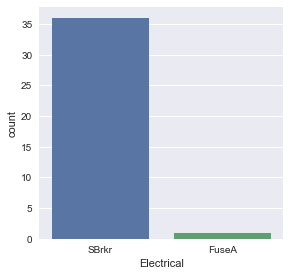

In [24]:
timber = train_data_clean[train_data_clean['Neighborhood']=='Timber']
grid = sns.factorplot(data=timber,x='Electrical',kind='count')
#Seems that in Timber Area, Most of the Electrical Circuit is SBrkr type, thus we will fill NA to 'SBrkr'
train_data_clean['Electrical']=train_data_clean['Electrical'].fillna('SBrkr')
train_data_clean['Electrical'].isnull().sum()

In [25]:
# Impute Lot Frontage
# Use square root of Lot Area to estimate the Lot Frontage
train_data_clean['LotFrontage'].fillna(np.sqrt(train_data_clean['LotArea']),inplace=True)

In [26]:
# Impute the simple replacement of NaN to 'NA' for the rest regular-missing-value-columns
train_data_clean[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish',
                   'GarageQual','GarageCond']]=train_data_clean[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish',
                   'GarageQual','GarageCond']].fillna('NA')

In [27]:
# Check if there is missing values for any feature
train_data_clean.isnull().sum().sort_values(ascending=False)[:5]
# 'GarageYrBlt still has 81 missing values

GarageYrBlt    81
Heating         0
RoofStyle       0
RoofMatl        0
Exterior1st     0
dtype: int64

In [28]:
train_data_clean[garage_features][train_data_clean['GarageYrBlt'].isnull()].head()
# Seems like that the missing value of 'GarageYrBlt' is due to no garage in the house

GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
Id                                                                           
40         NA          NaN           NA         0.0         0.0         NA   
49         NA          NaN           NA         0.0         0.0         NA   
79         NA          NaN           NA         0.0         0.0         NA   
89         NA          NaN           NA         0.0         0.0         NA   
90         NA          NaN           NA         0.0         0.0         NA   

   GarageCond  
Id             
40         NA  
49         NA  
79         NA  
89         NA  
90         NA

In [29]:
# Since the 'GarageYrBlt' contains non-numeric values (NA means no garage), thus it is diffcult to attribute it to
# numeric parameter, instead we will put it to bins and treat it as a categorical feature. We will also
# generate same year ranges for other year features. 
year_bins =[0,1950,1965,1980,1995,2010]
year_names = ['before 1950','1950-1965','1965-1980','1980-1995','1995-2010']
train_data_clean['BltGarageYrRange']=pd.cut(train_data_clean['GarageYrBlt'],bins=year_bins,labels=year_names)
train_data_clean['BltYearRange']=pd.cut(train_data_clean['YearBuilt'],bins=year_bins,labels=year_names)
train_data_clean['YearRemodAddRange']=pd.cut(train_data_clean['YearRemodAdd'],bins=year_bins,labels=year_names)
del train_data_clean['GarageYrBlt']
# Delete 'GarageYrBlt' Feature

In [30]:
train_data_clean['BltGarageYrRange'].unique()

[1995-2010, 1965-1980, 1980-1995, before 1950, 1950-1965, NaN]
Categories (5, object): [before 1950 < 1950-1965 < 1965-1980 < 1980-1995 < 1995-2010]

In [31]:
# Now all the missing values have been filled
train_data_clean.isnull().sum().sort_values(ascending=False)[:5]
# Since 'BltGarageYrRange' is categorical feature, we later can treat 'NA' as a separate level. 

BltGarageYrRange     81
YearRemodAddRange     0
BsmtQual              0
RoofMatl              0
Exterior1st           0
dtype: int64

### 2 Feature Engineering

Define Feature types

In [32]:
nominal_features=['MSSubClass','MSZoning','LandContour','LotConfig','Neighborhood',
                  'Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
                  'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
                  'Heating','GarageType','MiscFeature','SaleType','SaleCondition','BltGarageYrRange','BltYearRange',
                'YearRemodAddRange']

In [33]:
ordinal_features=['Street','Alley','LotShape','Utilities','LandSlope','OverallQual','OverallCond',
                  'ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                  'BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
                 'GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']

In [34]:
numeric_features=['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea',
                 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
                 '2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea',
                  'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
                  'ScreenPorch','PoolArea','MiscVal','YrSold']

In [35]:
numeric_discrete_features=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                          'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
                          'GarageCars','MoSold']

In [36]:
print 'Total numbers of features:',len(nominal_features)+len(ordinal_features)+len(numeric_features)+len(numeric_discrete_features)

Total numbers of features: 81


In [37]:
nominal,ordinal,numeric,discrete=0,0,0,0
for variable in train_data_raw.columns.values:
    if variable in nominal_features:
        nominal+=1
    if variable in ordinal_features:
        ordinal+=1
    if variable in numeric_features:
        numeric+=1
    if variable in numeric_discrete_features:
        discrete+=1
print 'nominal',nominal
print 'ordinal',ordinal
print 'numeric',numeric
print 'discrete',discrete

nominal 20
ordinal 26
numeric 22
discrete 10


#####  Combine levels and determine feature relevence

Combine Levels --- Nominal variable

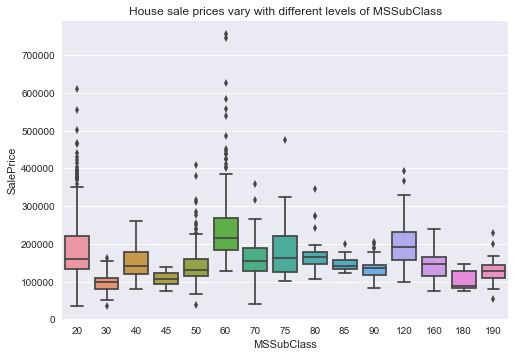

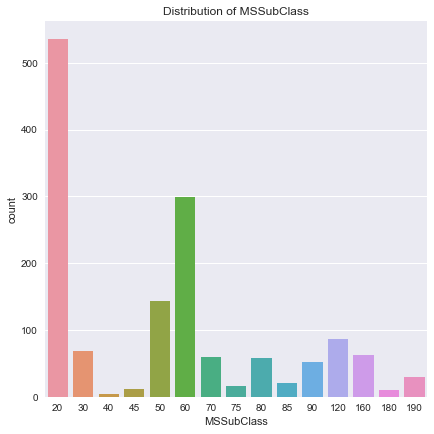

MSSubClass
20     536
30      69
40       4
45      12
50     144
60     299
70      60
75      16
80      58
85      20
90      52
120     87
160     63
180     10
190     30
Name: MSSubClass, dtype: int64


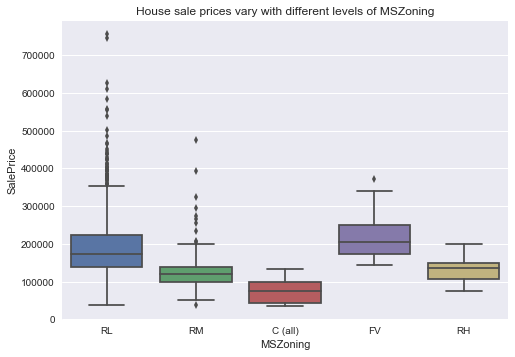

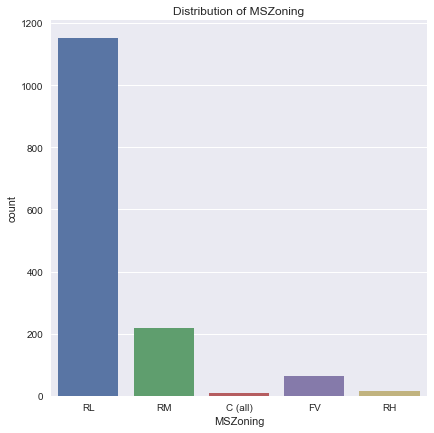

MSZoning
C (all)      10
FV           65
RH           16
RL         1151
RM          218
Name: MSZoning, dtype: int64


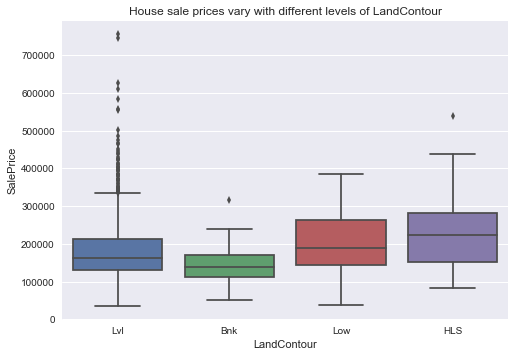

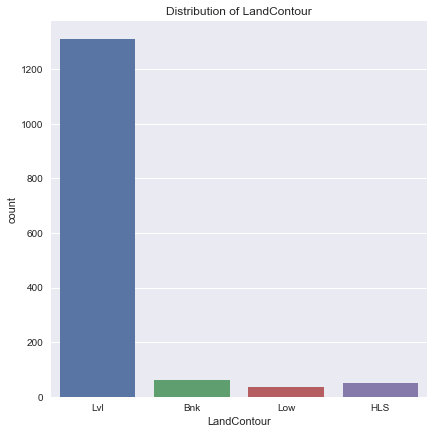

LandContour
Bnk      63
HLS      50
Low      36
Lvl    1311
Name: LandContour, dtype: int64


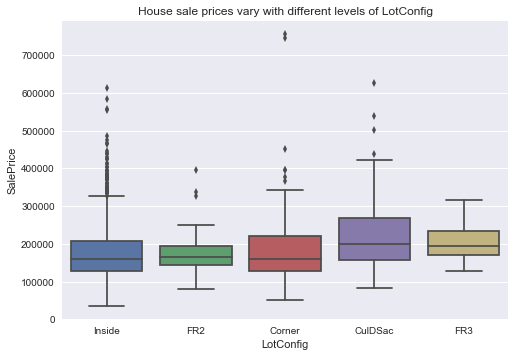

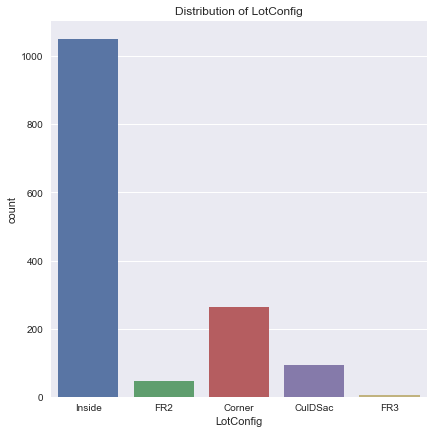

LotConfig
Corner      263
CulDSac      94
FR2          47
FR3           4
Inside     1052
Name: LotConfig, dtype: int64


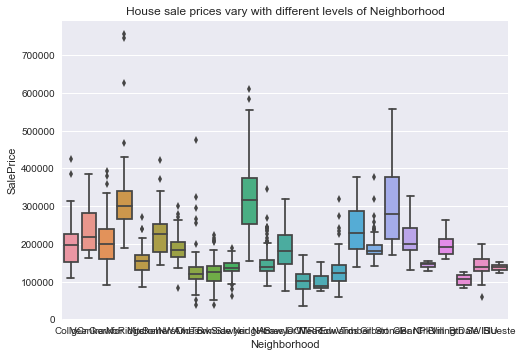

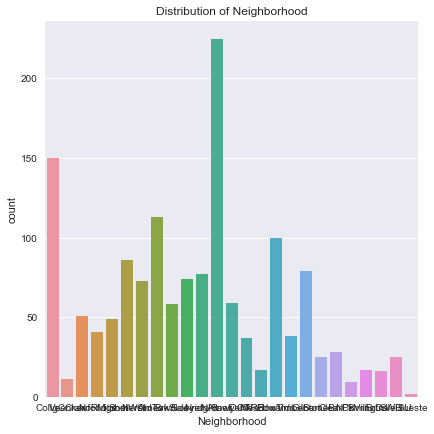

Neighborhood
Blmngtn     17
Blueste      2
BrDale      16
BrkSide     58
ClearCr     28
CollgCr    150
Crawfor     51
Edwards    100
Gilbert     79
IDOTRR      37
MeadowV     17
Mitchel     49
NAmes      225
NPkVill      9
NWAmes      73
NoRidge     41
NridgHt     77
OldTown    113
SWISU       25
Sawyer      74
SawyerW     59
Somerst     86
StoneBr     25
Timber      38
Veenker     11
Name: Neighborhood, dtype: int64


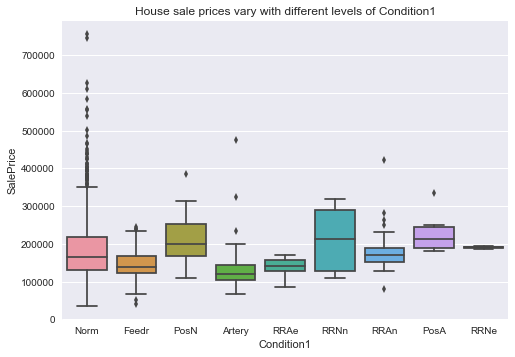

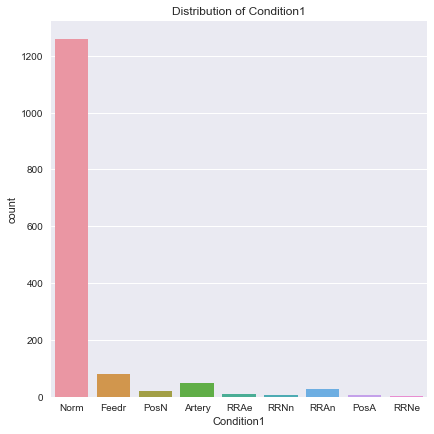

Condition1
Artery      48
Feedr       81
Norm      1260
PosA         8
PosN        19
RRAe        11
RRAn        26
RRNe         2
RRNn         5
Name: Condition1, dtype: int64


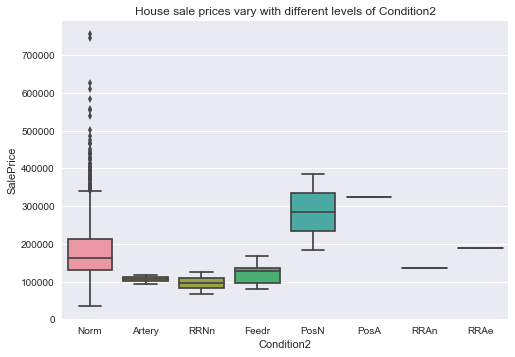

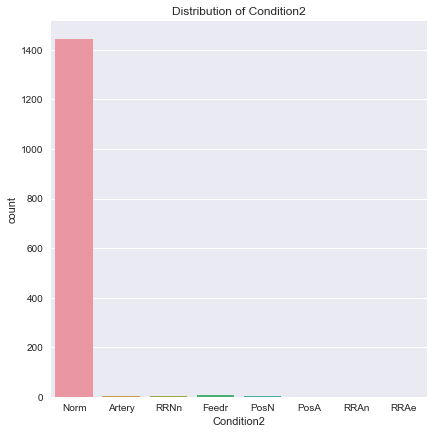

Condition2
Artery       2
Feedr        6
Norm      1445
PosA         1
PosN         2
RRAe         1
RRAn         1
RRNn         2
Name: Condition2, dtype: int64


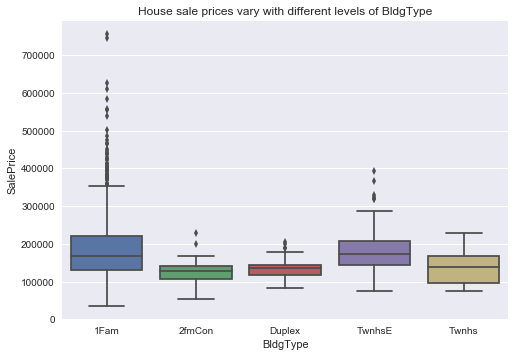

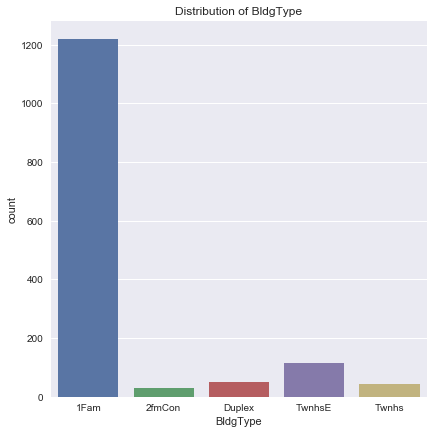

BldgType
1Fam      1220
2fmCon      31
Duplex      52
Twnhs       43
TwnhsE     114
Name: BldgType, dtype: int64


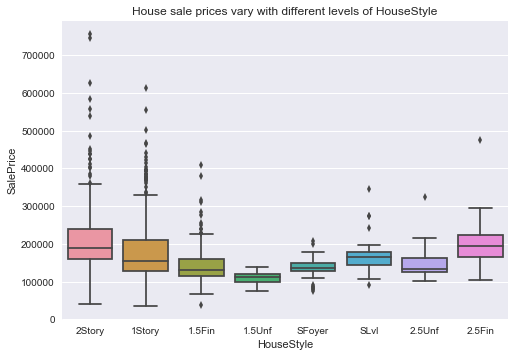

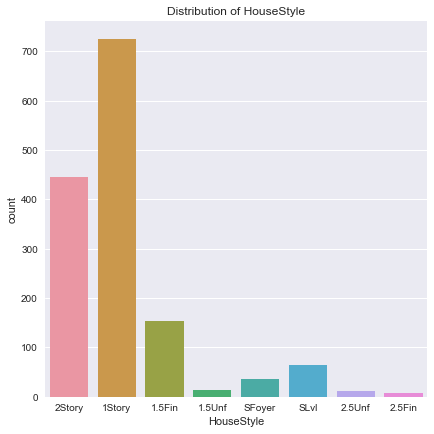

HouseStyle
1.5Fin    154
1.5Unf     14
1Story    726
2.5Fin      8
2.5Unf     11
2Story    445
SFoyer     37
SLvl       65
Name: HouseStyle, dtype: int64


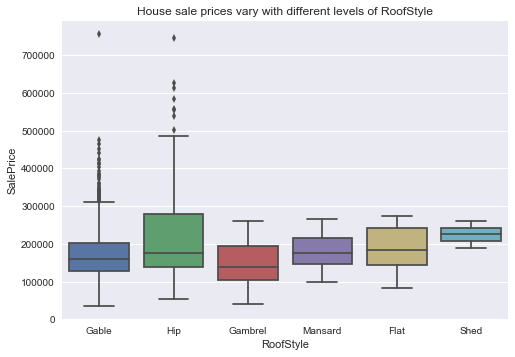

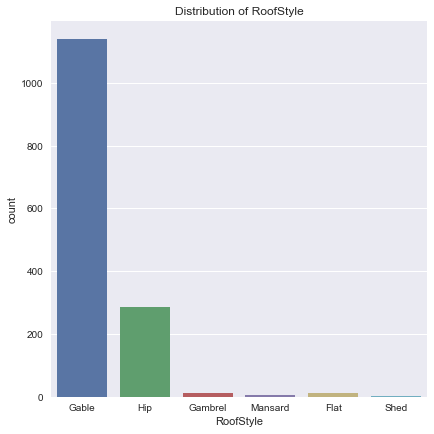

RoofStyle
Flat         13
Gable      1141
Gambrel      11
Hip         286
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64


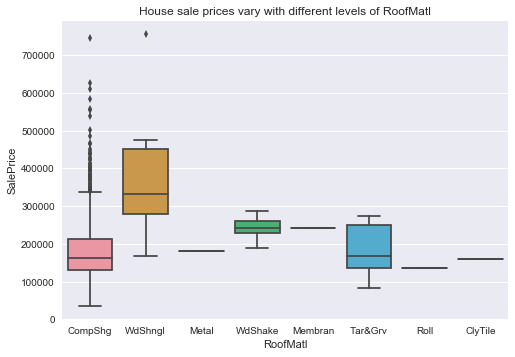

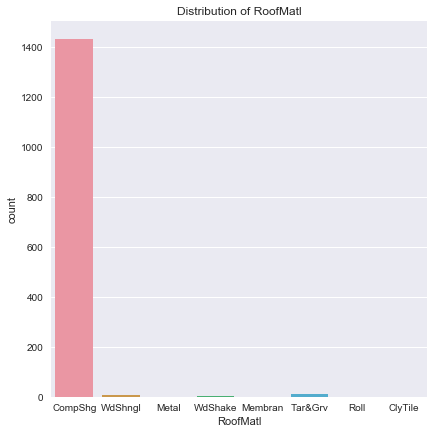

RoofMatl
ClyTile       1
CompShg    1434
Membran       1
Metal         1
Roll          1
Tar&Grv      11
WdShake       5
WdShngl       6
Name: RoofMatl, dtype: int64


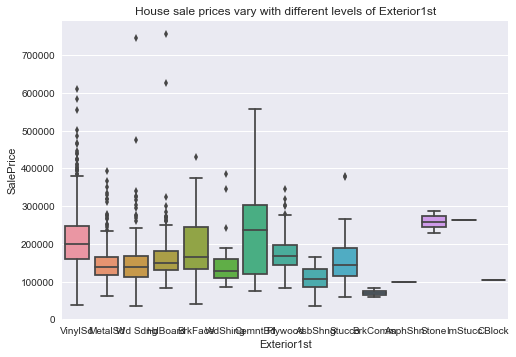

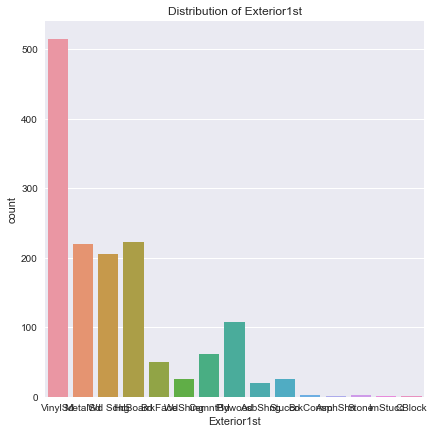

Exterior1st
AsbShng     20
AsphShn      1
BrkComm      2
BrkFace     50
CBlock       1
CemntBd     61
HdBoard    222
ImStucc      1
MetalSd    220
Plywood    108
Stone        2
Stucco      25
VinylSd    515
Wd Sdng    206
WdShing     26
Name: Exterior1st, dtype: int64


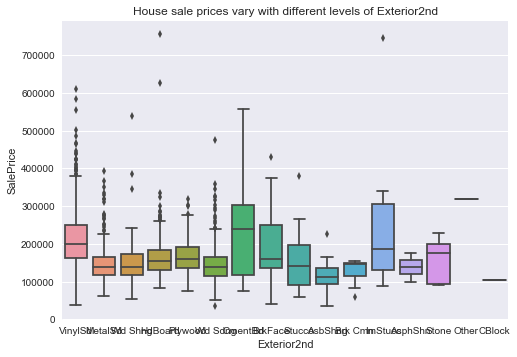

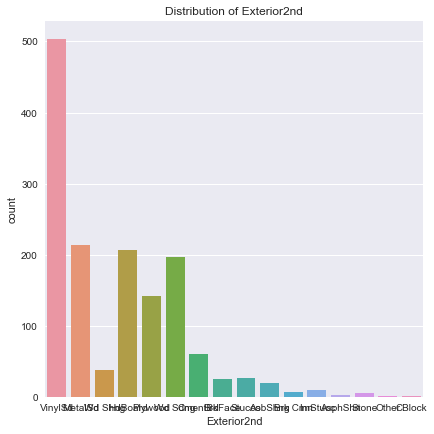

Exterior2nd
AsbShng     20
AsphShn      3
Brk Cmn      7
BrkFace     25
CBlock       1
CmentBd     60
HdBoard    207
ImStucc     10
MetalSd    214
Other        1
Plywood    142
Stone        5
Stucco      26
VinylSd    504
Wd Sdng    197
Wd Shng     38
Name: Exterior2nd, dtype: int64


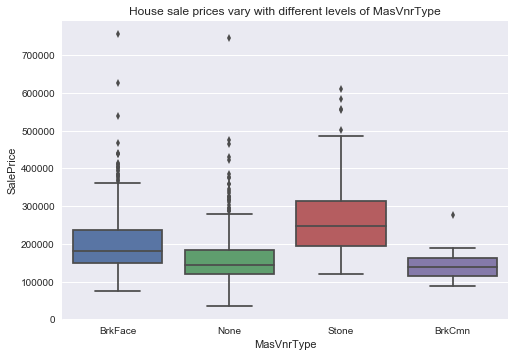

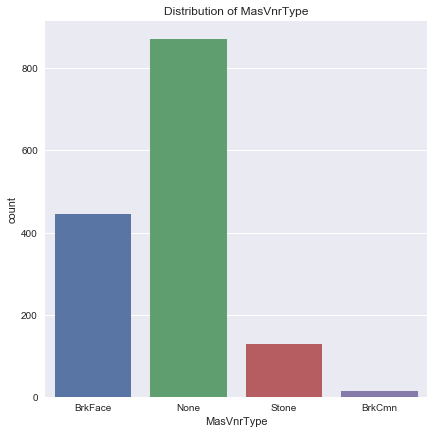

MasVnrType
BrkCmn      15
BrkFace    445
None       872
Stone      128
Name: MasVnrType, dtype: int64


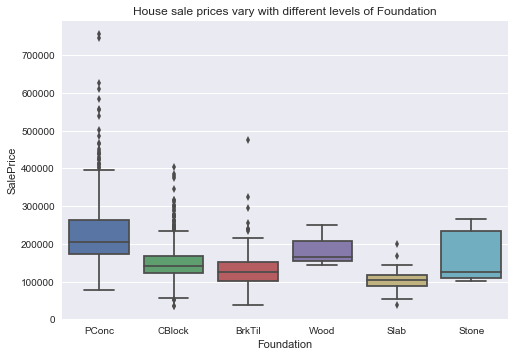

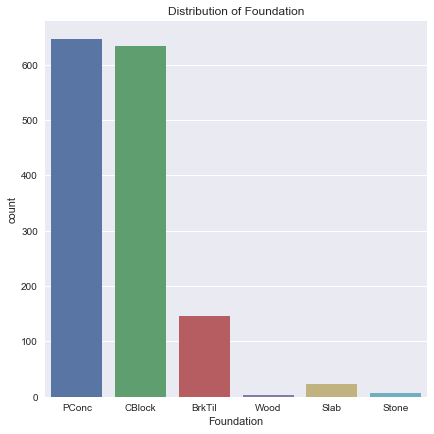

Foundation
BrkTil    146
CBlock    634
PConc     647
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64


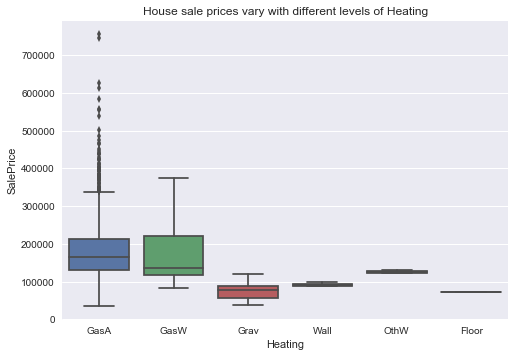

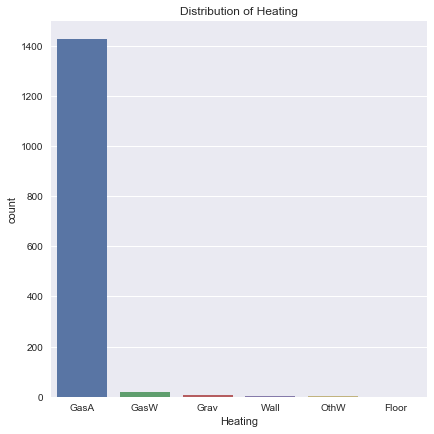

Heating
Floor       1
GasA     1428
GasW       18
Grav        7
OthW        2
Wall        4
Name: Heating, dtype: int64


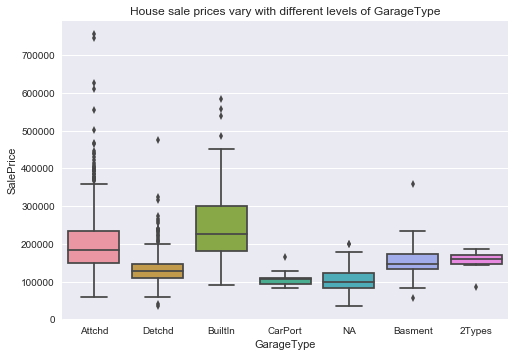

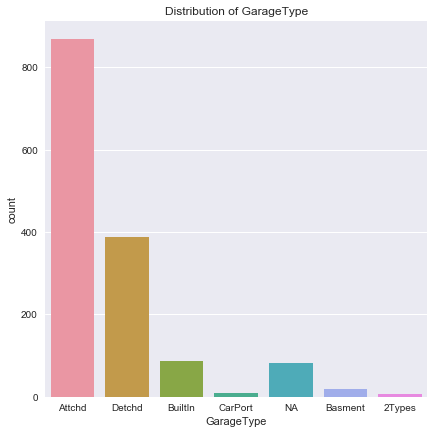

GarageType
2Types       6
Attchd     870
Basment     19
BuiltIn     88
CarPort      9
Detchd     387
NA          81
Name: GarageType, dtype: int64


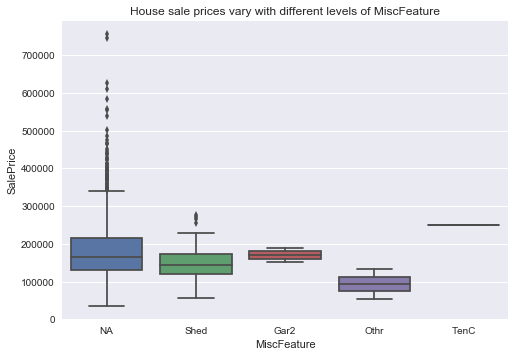

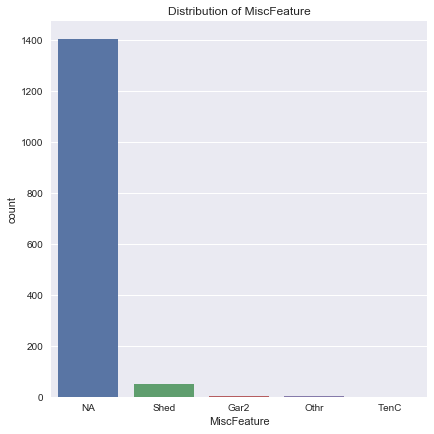

MiscFeature
Gar2       2
NA      1406
Othr       2
Shed      49
TenC       1
Name: MiscFeature, dtype: int64


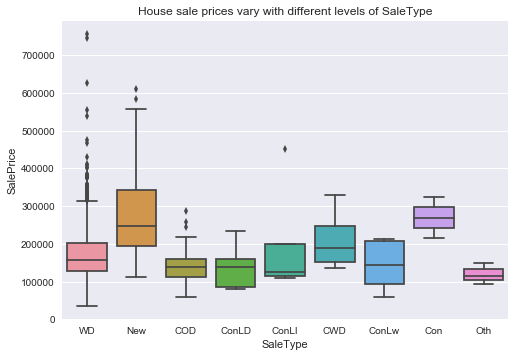

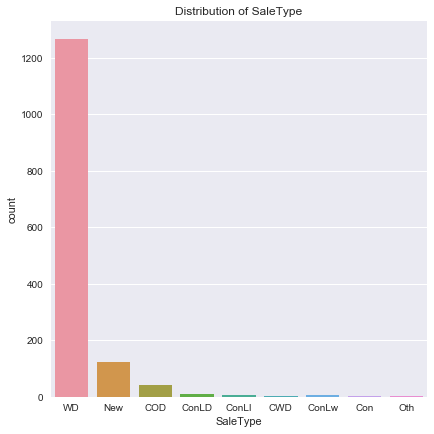

SaleType
COD        43
CWD         4
Con         2
ConLD       9
ConLI       5
ConLw       5
New       122
Oth         3
WD       1267
Name: SaleType, dtype: int64


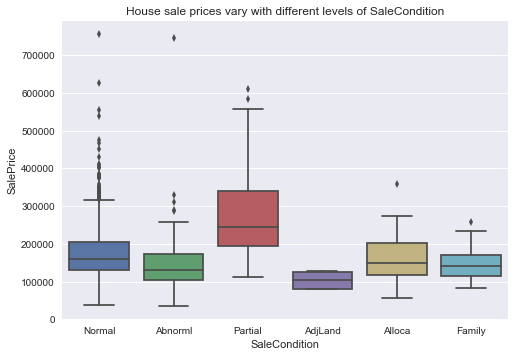

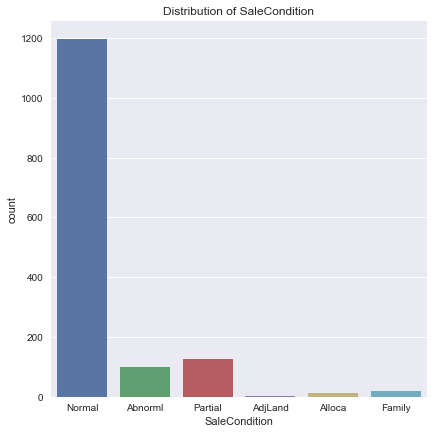

SaleCondition
Abnorml     101
AdjLand       4
Alloca       12
Family       20
Normal     1198
Partial     125
Name: SaleCondition, dtype: int64


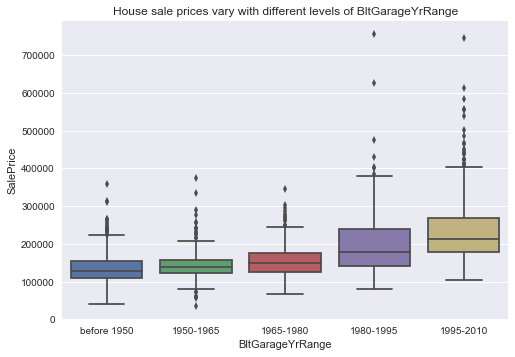

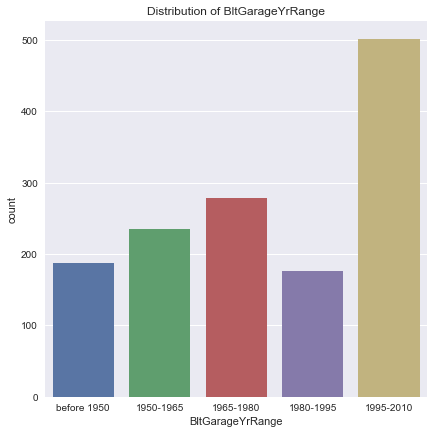

BltGarageYrRange
before 1950    188
1950-1965      235
1965-1980      278
1980-1995      176
1995-2010      502
Name: BltGarageYrRange, dtype: int64


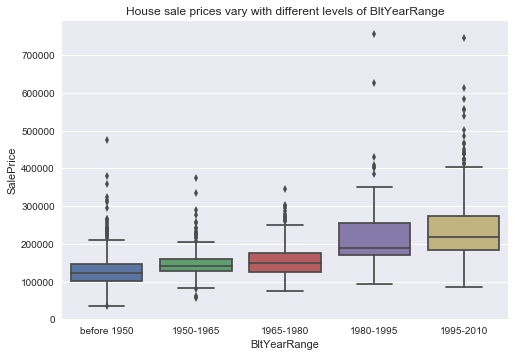

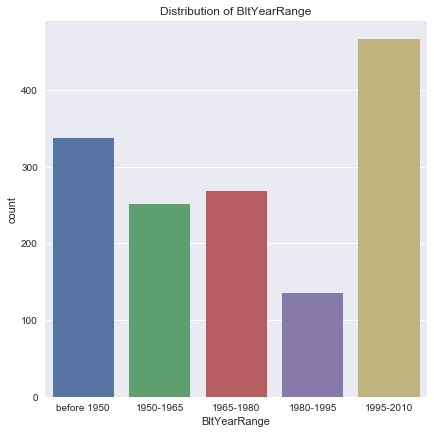

BltYearRange
before 1950    338
1950-1965      252
1965-1980      268
1980-1995      135
1995-2010      467
Name: BltYearRange, dtype: int64


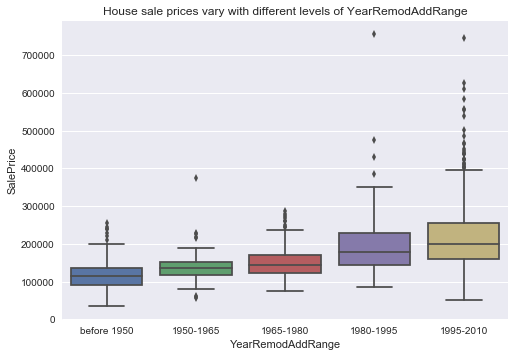

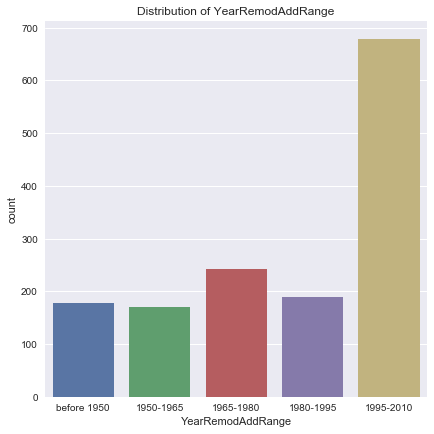

YearRemodAddRange
before 1950    178
1950-1965      171
1965-1980      243
1980-1995      189
1995-2010      679
Name: YearRemodAddRange, dtype: int64


In [38]:
# Look at distribution of all the nominal features
for var in nominal_features:
    grid = sns.boxplot(x=var,y='SalePrice',data=train_data_clean)
    plt.title('House sale prices vary with different levels of %s' % var)
    plt.show()
    g = sns.factorplot(x=var,data=train_data_clean,kind='count',size=6,aspect=1)
    plt.title('Distribution of %s' % var)
    plt.show()
    print train_data_clean[var].groupby(train_data_clean[var]).count()

In [39]:
# Step 1: Use prior knowledge to combine levels preliminarily
pre_nominal_conversion = {}
pre_nominal_conversion['MSSubClass']={20:'1Story',30:'1Story',40:'1Story',45:'1.5Stories',50:'1.5Stories',60:'2+Stories',
                                   70:'2+Stories',75:'2+Stories',80:'Other',85:'Other',90:'Other',120:'1Story',
                                    150:'1.5Stories',160:'2+Stories',180:'Other',190:'Other'}
pre_nominal_conversion['MSZoning']={'A':'A','C (all)':'C','FV':'FV','RH':'RH',
                                 'RL':'RL','RM':'RH','RP':'RL','C':'C'}
pre_nominal_conversion['BldgType']={'1Fam':'1Fam','2fmCon':'Duplex','Duplex':
                                 'Duplex','Twnhs':'Twnhs','TwnhsE':'Twnhs'}
pre_nominal_conversion['HouseStyle']={'1.5Fin':'1.5Stories','1.5Unf':'1.5Stories',
                                   '1Story':'1Story','2.5Fin':'2+Stories',
                                   '2.5Unf':'2+Stories','2Story':'2+Stories',
                                   'SFoyer':'Split','SLvl':'Split'}



In [40]:
for key in pre_nominal_conversion: 
    train_data_clean[key]=train_data_clean[key].map(pre_nominal_conversion[key])

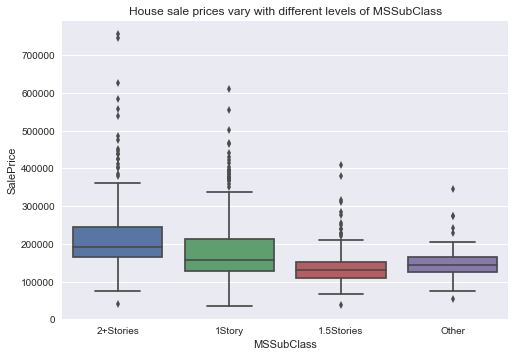

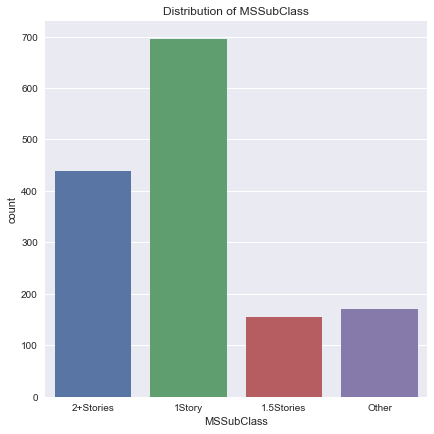

MSSubClass
1.5Stories    156
1Story        696
2+Stories     438
Other         170
Name: MSSubClass, dtype: int64


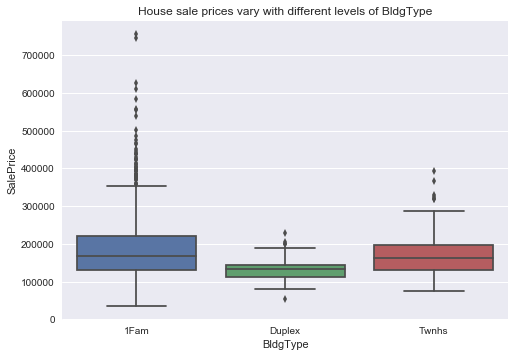

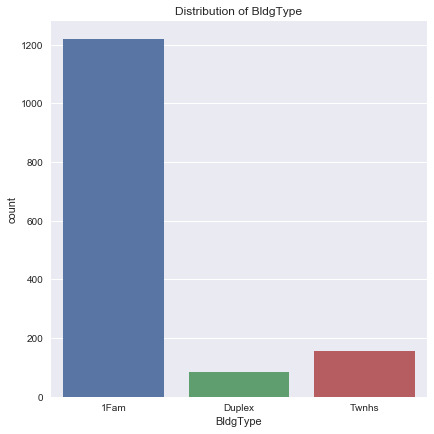

BldgType
1Fam      1220
Duplex      83
Twnhs      157
Name: BldgType, dtype: int64


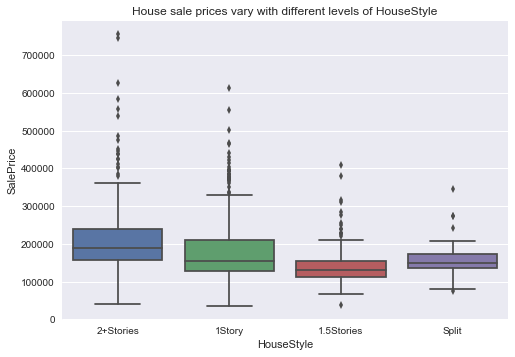

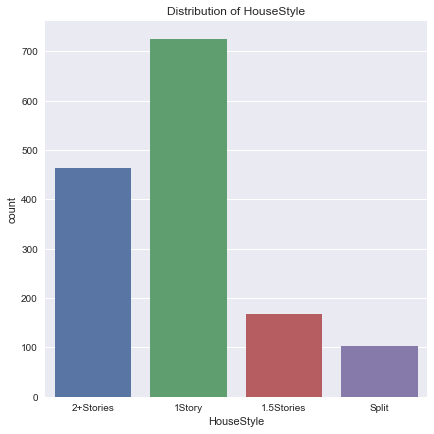

HouseStyle
1.5Stories    168
1Story        726
2+Stories     464
Split         102
Name: HouseStyle, dtype: int64


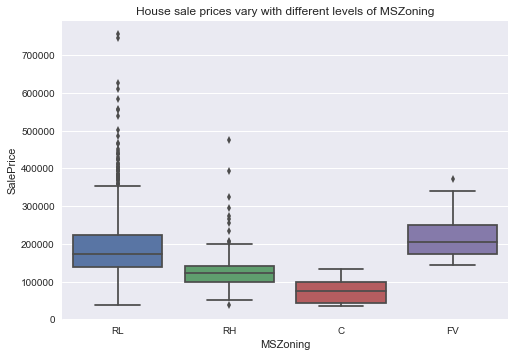

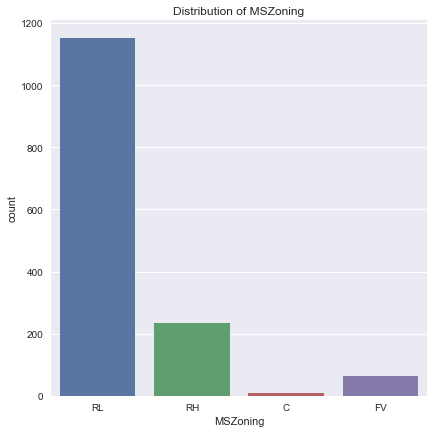

MSZoning
C       10
FV      65
RH     234
RL    1151
Name: MSZoning, dtype: int64


In [41]:
# Check the variable profile after preliminary level conversion
for var in pre_nominal_conversion:
    grid = sns.boxplot(x=var,y='SalePrice',data=train_data_clean)
    plt.title('House sale prices vary with different levels of %s' % var)
    plt.show()
    g = sns.factorplot(x=var,data=train_data_clean,kind='count',size=6,aspect=1)
    plt.title('Distribution of %s' % var)
    plt.show()
    print train_data_clean[var].groupby(train_data_clean[var]).count()

In [42]:
# Step 2 : Calculate Frequency for each level, and combine levels with <=5% frequency to 'Rare' Category. 
def combine_rare_levels(df):
    tb = pd.DataFrame(df.groupby(df).count())
    tb.columns=['Count']
    tb['Freq']=tb['Count']/tb['Count'].sum()
    all_levels = tb.index.values
    rare_levels = tb[tb['Freq']<=0.05].index.values
    convert_map = {}
    for lv in all_levels:
        if lv in rare_levels:
            convert_map[lv]='Rare'
        else:
            convert_map[lv]=lv
    return convert_map

In [43]:
# Perform 'combine_rare_levels' to all the nominal_features
nominal_lookup = {}
for var in nominal_features:
    lookup = combine_rare_levels(train_data_clean[var])
    train_data_clean[var]=train_data_clean[var].map(lookup)
    nominal_lookup[var]=lookup
    

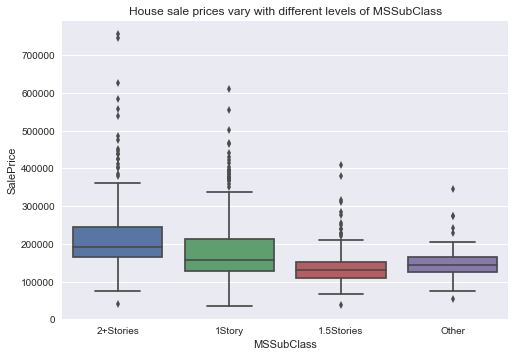

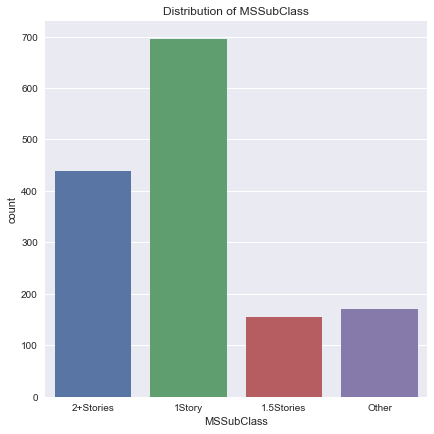

MSSubClass
1.5Stories    156
1Story        696
2+Stories     438
Other         170
Name: MSSubClass, dtype: int64


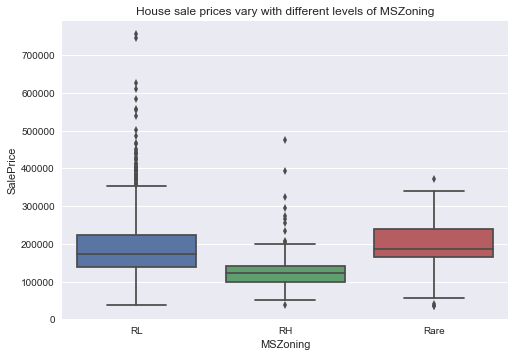

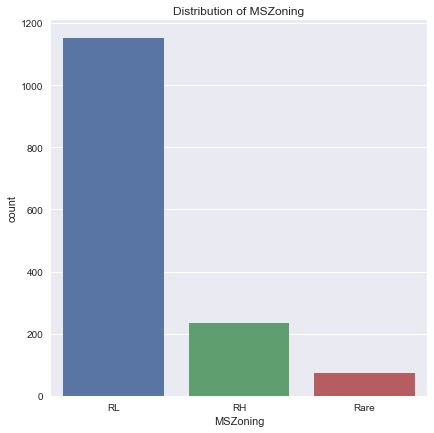

MSZoning
RH       234
RL      1151
Rare      75
Name: MSZoning, dtype: int64


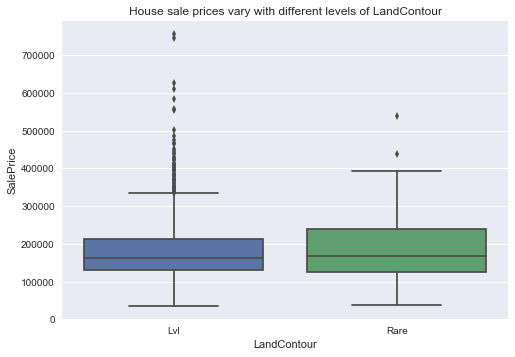

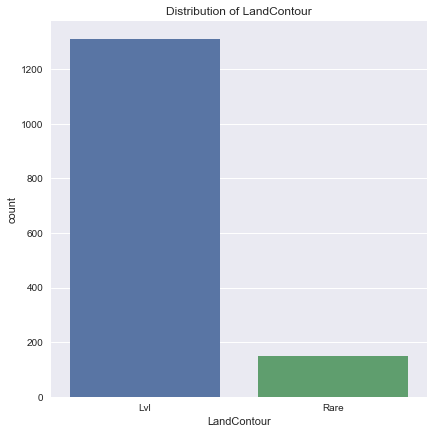

LandContour
Lvl     1311
Rare     149
Name: LandContour, dtype: int64


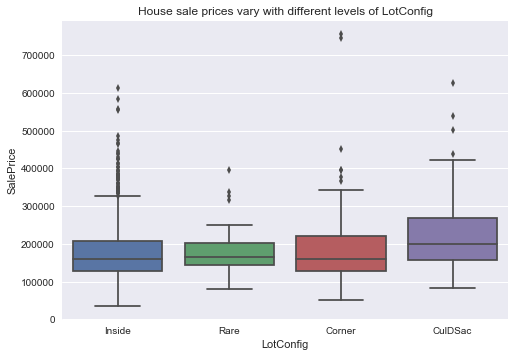

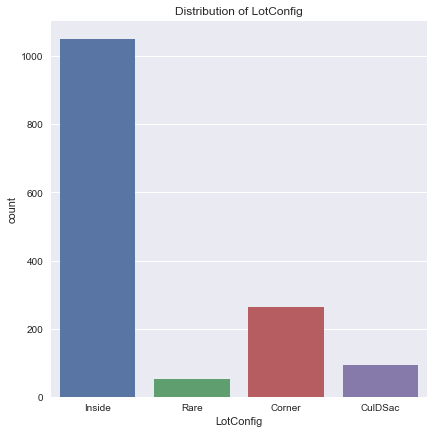

LotConfig
Corner      263
CulDSac      94
Inside     1052
Rare         51
Name: LotConfig, dtype: int64


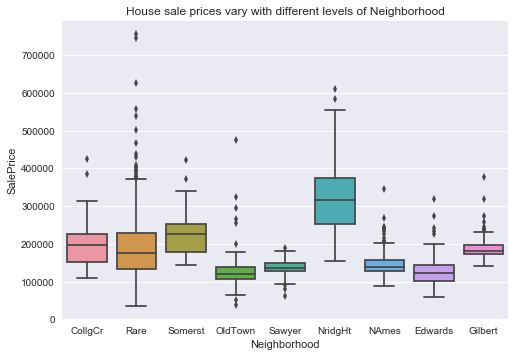

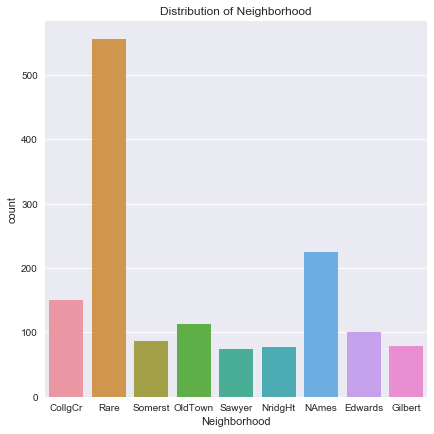

Neighborhood
CollgCr    150
Edwards    100
Gilbert     79
NAmes      225
NridgHt     77
OldTown    113
Rare       556
Sawyer      74
Somerst     86
Name: Neighborhood, dtype: int64


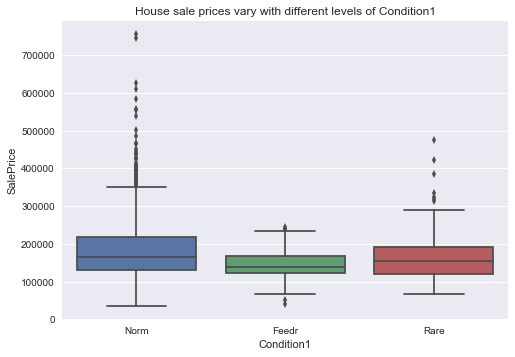

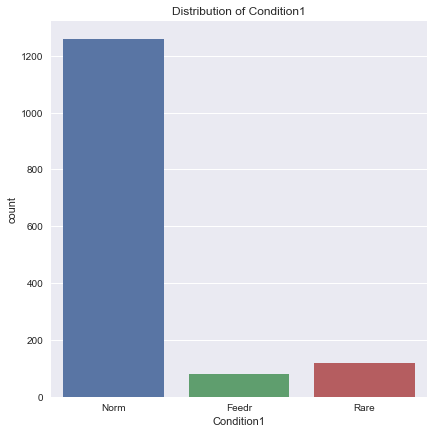

Condition1
Feedr      81
Norm     1260
Rare      119
Name: Condition1, dtype: int64


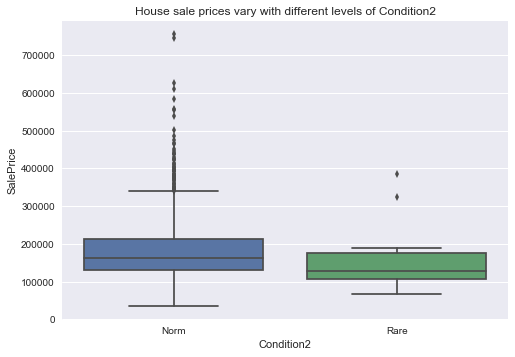

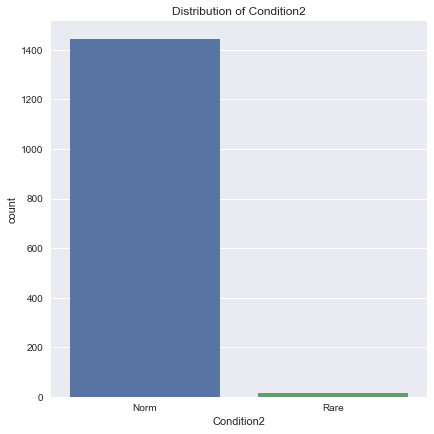

Condition2
Norm    1445
Rare      15
Name: Condition2, dtype: int64


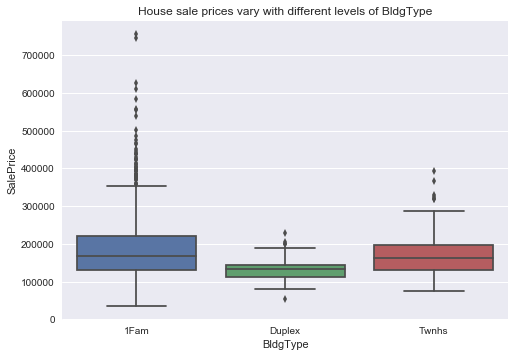

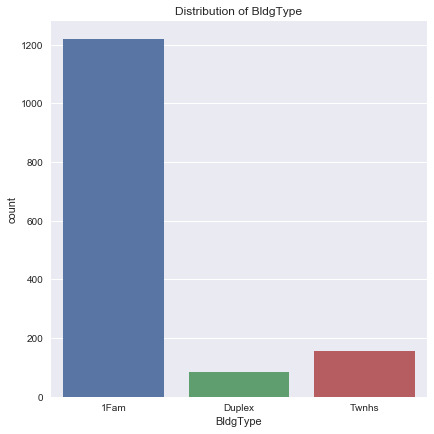

BldgType
1Fam      1220
Duplex      83
Twnhs      157
Name: BldgType, dtype: int64


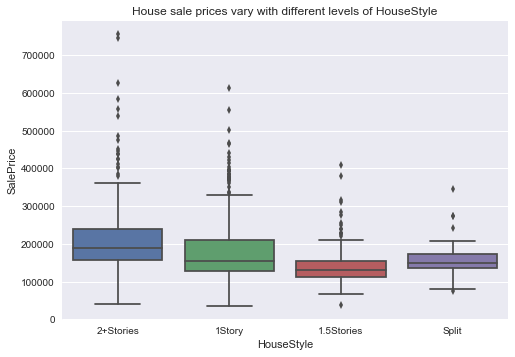

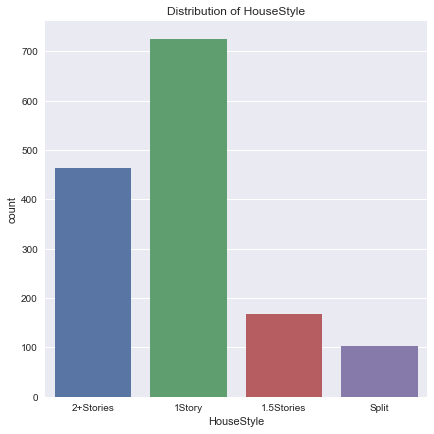

HouseStyle
1.5Stories    168
1Story        726
2+Stories     464
Split         102
Name: HouseStyle, dtype: int64


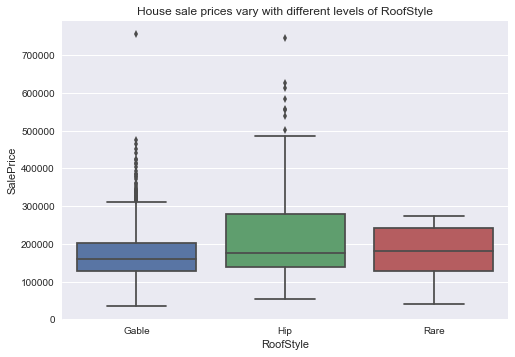

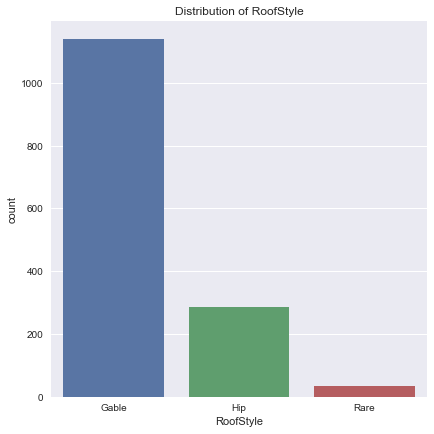

RoofStyle
Gable    1141
Hip       286
Rare       33
Name: RoofStyle, dtype: int64


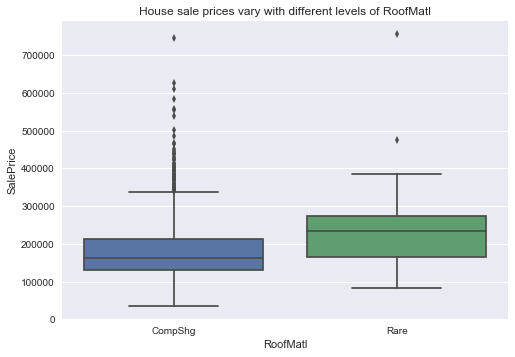

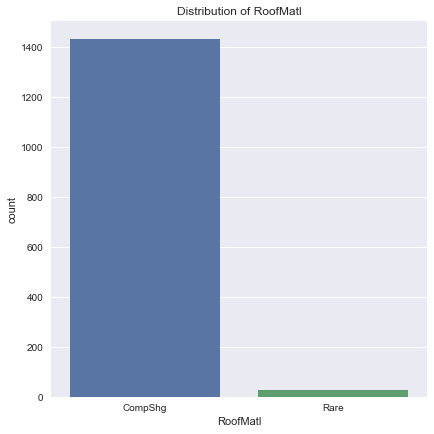

RoofMatl
CompShg    1434
Rare         26
Name: RoofMatl, dtype: int64


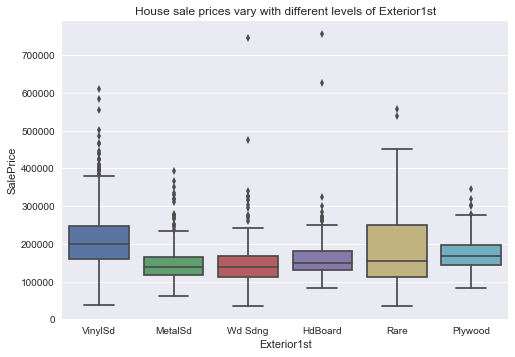

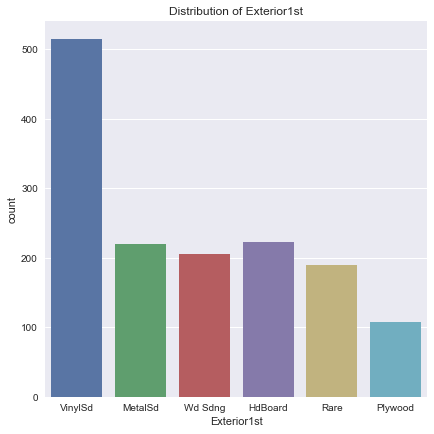

Exterior1st
HdBoard    222
MetalSd    220
Plywood    108
Rare       189
VinylSd    515
Wd Sdng    206
Name: Exterior1st, dtype: int64


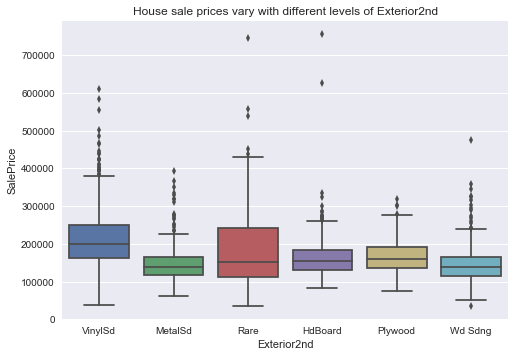

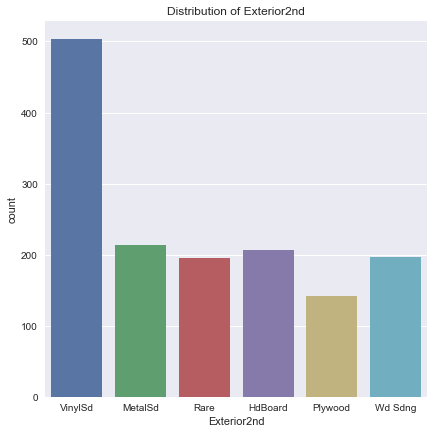

Exterior2nd
HdBoard    207
MetalSd    214
Plywood    142
Rare       196
VinylSd    504
Wd Sdng    197
Name: Exterior2nd, dtype: int64


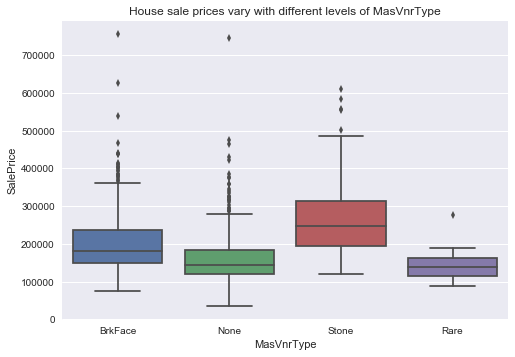

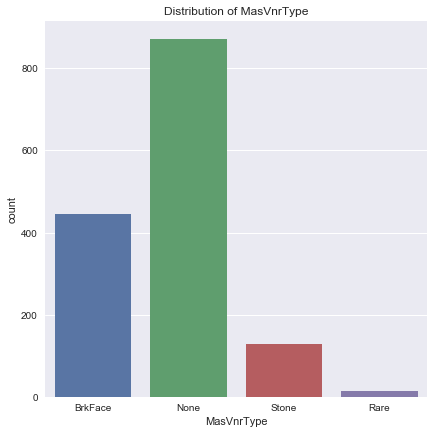

MasVnrType
BrkFace    445
None       872
Rare        15
Stone      128
Name: MasVnrType, dtype: int64


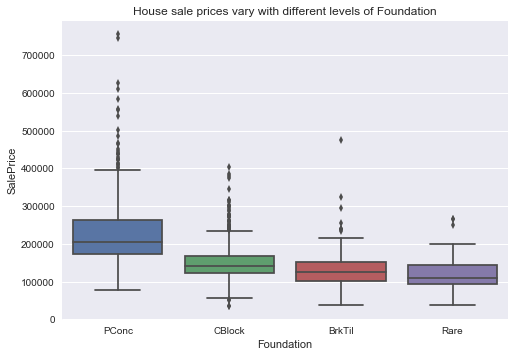

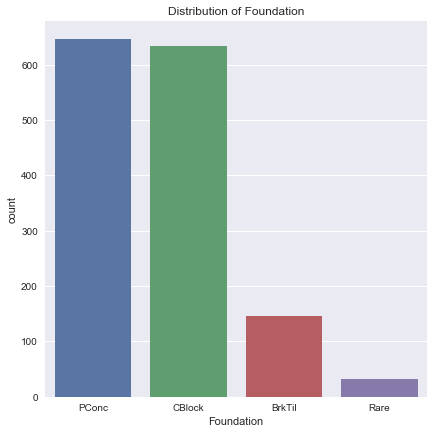

Foundation
BrkTil    146
CBlock    634
PConc     647
Rare       33
Name: Foundation, dtype: int64


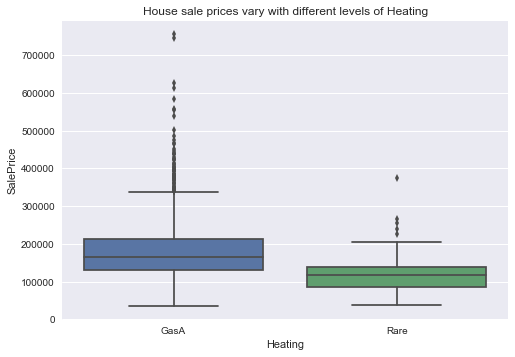

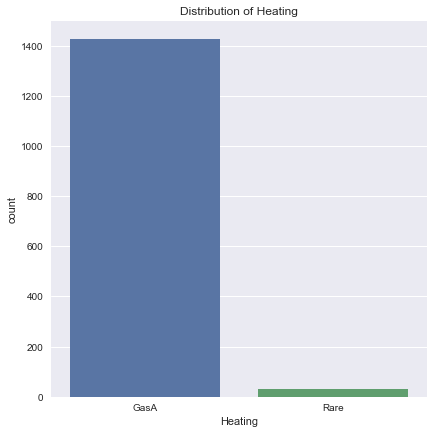

Heating
GasA    1428
Rare      32
Name: Heating, dtype: int64


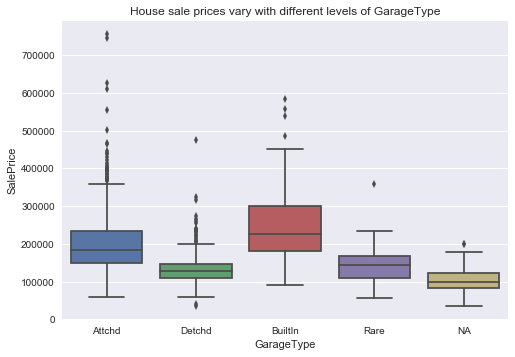

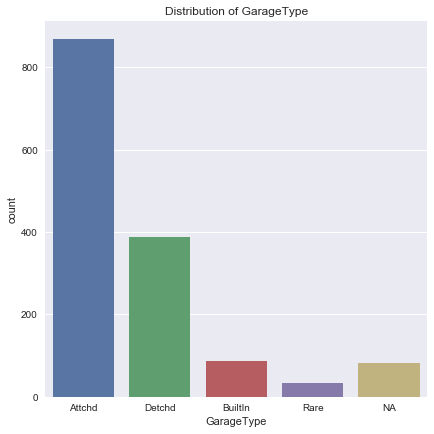

GarageType
Attchd     870
BuiltIn     88
Detchd     387
NA          81
Rare        34
Name: GarageType, dtype: int64


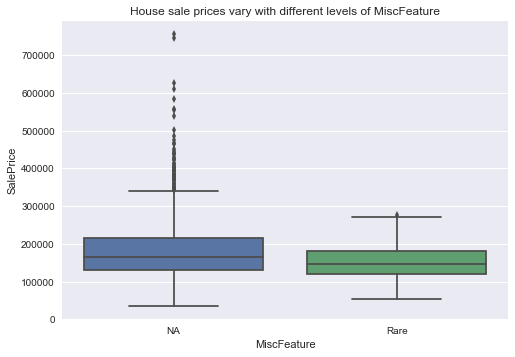

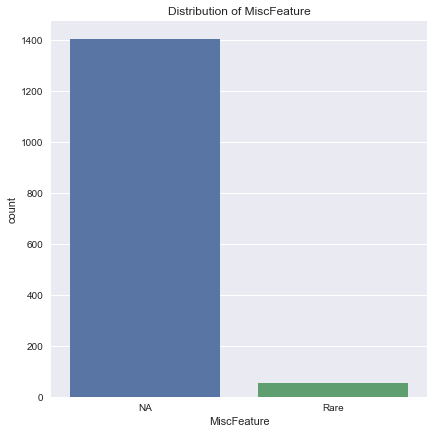

MiscFeature
NA      1406
Rare      54
Name: MiscFeature, dtype: int64


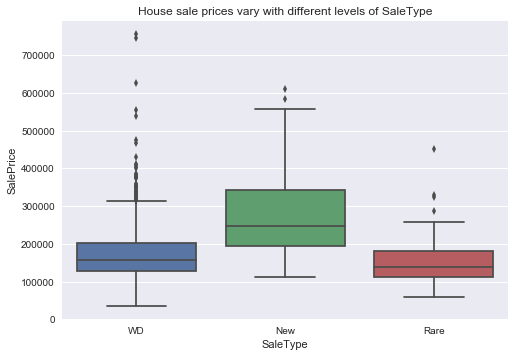

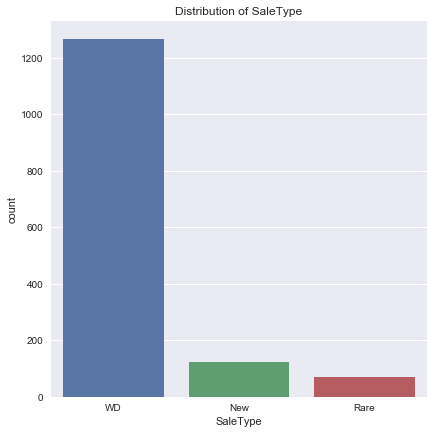

SaleType
New      122
Rare      71
WD      1267
Name: SaleType, dtype: int64


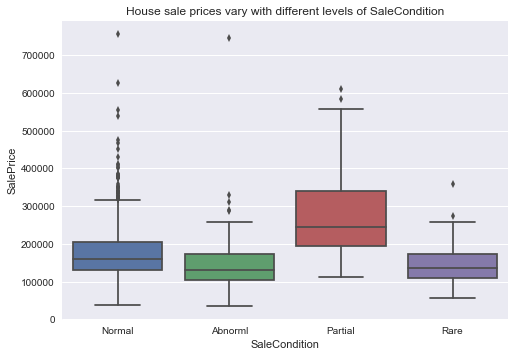

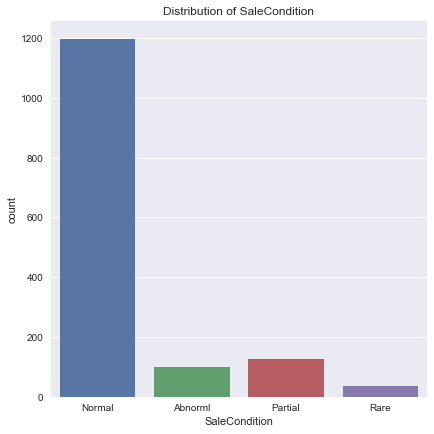

SaleCondition
Abnorml     101
Normal     1198
Partial     125
Rare         36
Name: SaleCondition, dtype: int64


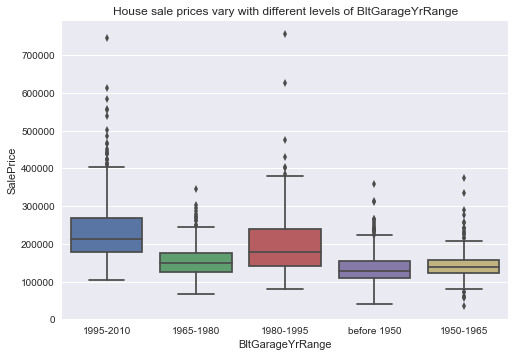

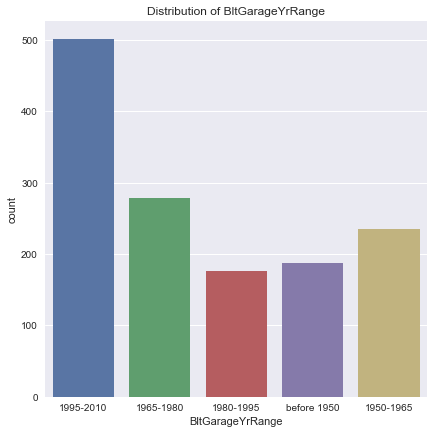

BltGarageYrRange
1950-1965      235
1965-1980      278
1980-1995      176
1995-2010      502
before 1950    188
Name: BltGarageYrRange, dtype: int64


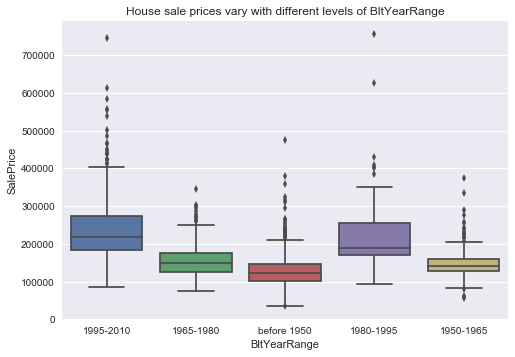

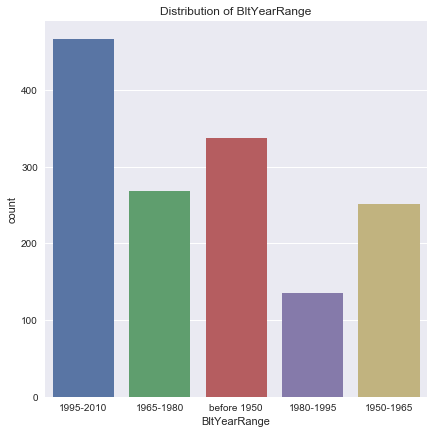

BltYearRange
1950-1965      252
1965-1980      268
1980-1995      135
1995-2010      467
before 1950    338
Name: BltYearRange, dtype: int64


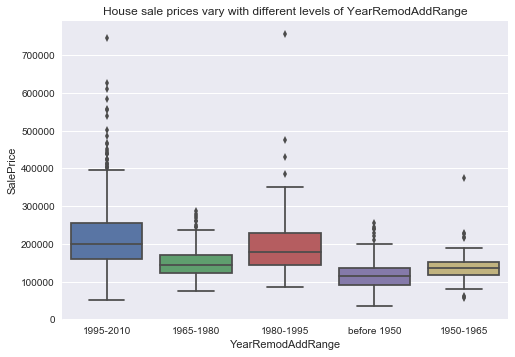

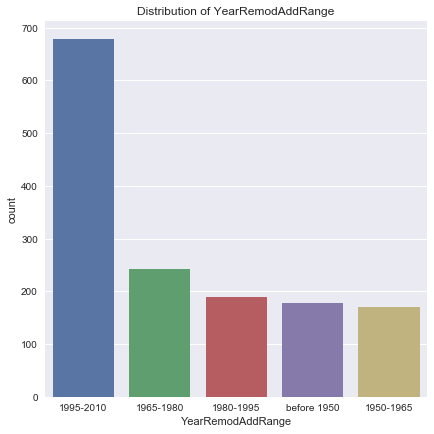

YearRemodAddRange
1950-1965      171
1965-1980      243
1980-1995      189
1995-2010      679
before 1950    178
Name: YearRemodAddRange, dtype: int64


In [44]:
# Check the distribution after combining to make sure everything is normal
for var in nominal_features:
    grid = sns.boxplot(x=var,y='SalePrice',data=train_data_clean)
    plt.title('House sale prices vary with different levels of %s' % var)
    plt.show()
    g = sns.factorplot(x=var,data=train_data_clean,kind='count',size=6,aspect=1)
    plt.title('Distribution of %s' % var)
    plt.show()
    print train_data_clean[var].groupby(train_data_clean[var]).count()

In [45]:
# Calculate ANOVA p-value for each nominal feature
def anova_calculator(df,features,response):
    F_list=[]
    p_list=[]
    for var in features:
        grps = df[var].unique()
        t_table={grp:df[response][df[var]==grp] for grp in grps}
        Fvalue,pvalue = stats.f_oneway(*t_table.values())
        F_list.append(Fvalue)
        p_list.append(pvalue)
    return F_list,p_list  

In [46]:
# List the Anova F,p values for each nominal feature
F_list,p_list = anova_calculator(train_data_clean,nominal_features,'SalePrice')
anova_nominal = pd.DataFrame({'Feature':nominal_features,'F-value':F_list,'p-value':p_list})
anova_nominal.sort_values(ascending=False,by='p-value')
# for 'LandContour' and 'Condition2',the p-value is larger than significant level 0.05, thus we accept null hypothesis
# for these 2 features. Accepting null hypothesis indicates the means of all levels are equal, and we can not 
# differentiate the levels, thus both features need to be discarded since they do not offer help to predict Price. 

C:\Users\huang\Anaconda2\lib\site-packages\scipy\stats\stats.py:2966: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


F-value            Feature        p-value
2     1.107030        LandContour   2.929028e-01
6     1.373321         Condition2   2.414336e-01
17    7.661035        MiscFeature   5.713986e-03
15   12.590608            Heating   3.999856e-04
10   16.099124           RoofMatl   6.316189e-05
5    12.231344         Condition1   5.396294e-06
3    10.231411          LotConfig   1.144917e-06
7    20.437747           BldgType   1.762889e-09
9    43.059021          RoofStyle   6.784277e-19
8    41.567943         HouseStyle   8.995163e-26
1    71.348484           MSZoning   2.746650e-30
0    55.554999         MSSubClass   5.333308e-34
12   37.197665        Exterior2nd   5.673119e-36
11   37.416107        Exterior1st   3.523374e-36
18  109.523693           SaleType   4.872132e-45
19   75.220910      SaleCondition   3.112266e-45
13  108.911305         MasVnrType   1.279704e-63
22  115.937639  YearRemodAddRange   6.829941e-86
16  119.625443         GarageType   2.660279e-88
14  164.607744         Foundation   7.101563e-92
4    74.717916       Neighborhood  3.252949e-103
21  182.701298       BltYearRange  6.357710e-127
20         NaN   BltGarageYrRange            NaN

In [47]:
# Discarded nominal features
discarded_features = ['LandContour','Condition2','MiscFeature','Heating','RoofMatl']
# The last 3 features has a second level with less than 5% frequency. 

Combine Levels --- Ordinal variable

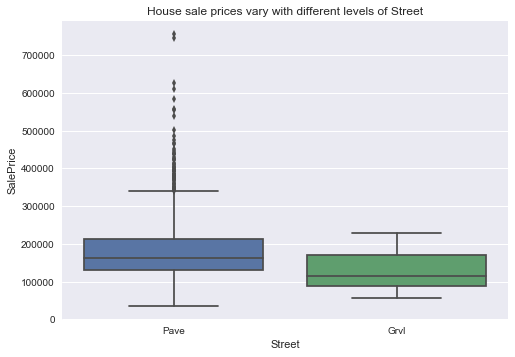

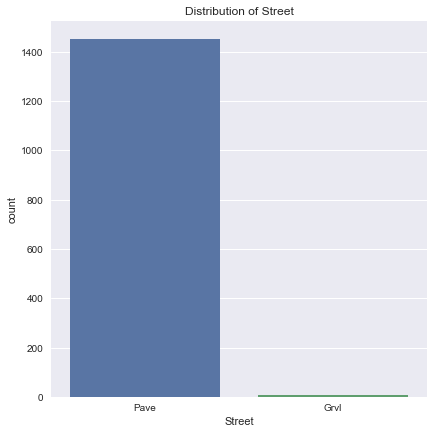

Street
Grvl       6
Pave    1454
Name: Street, dtype: int64


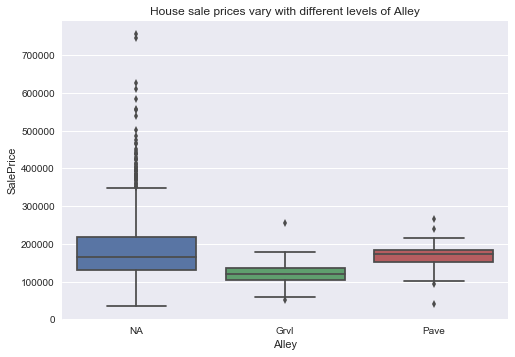

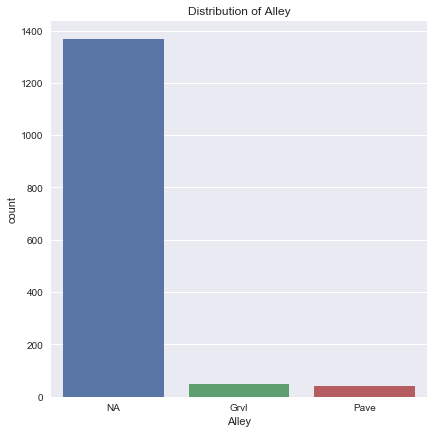

Alley
Grvl      50
NA      1369
Pave      41
Name: Alley, dtype: int64


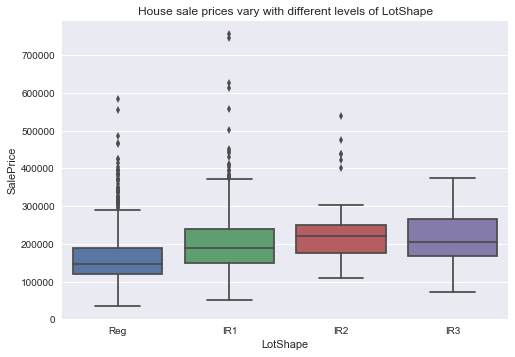

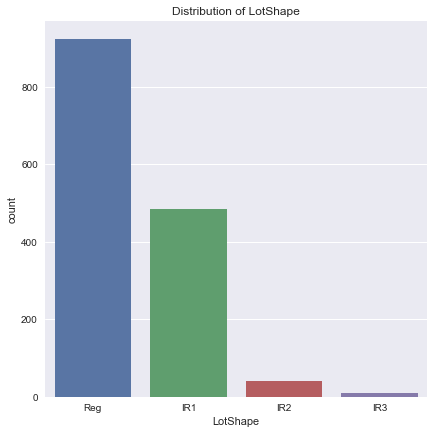

LotShape
IR1    484
IR2     41
IR3     10
Reg    925
Name: LotShape, dtype: int64


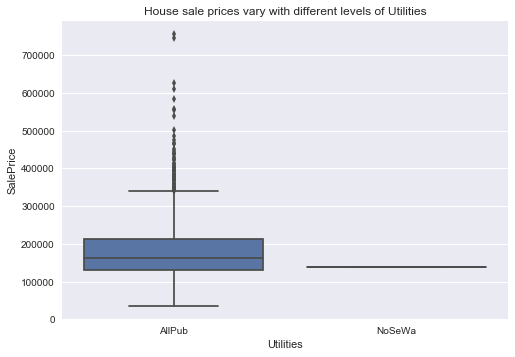

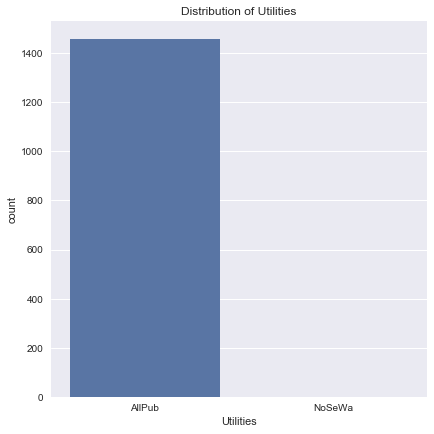

Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


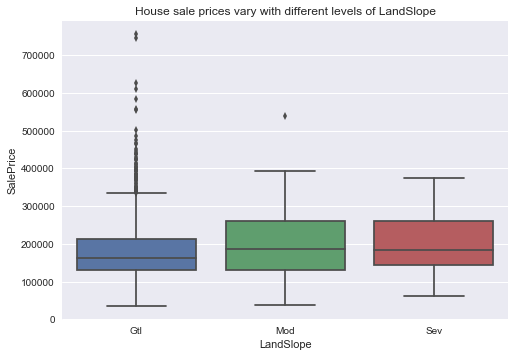

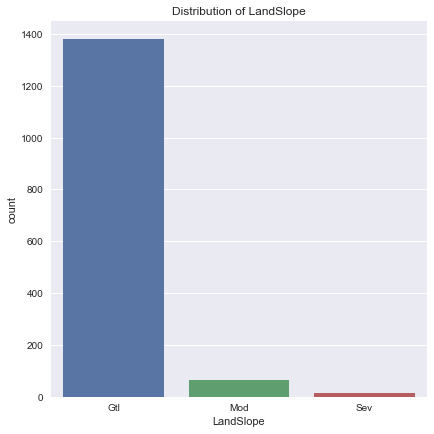

LandSlope
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


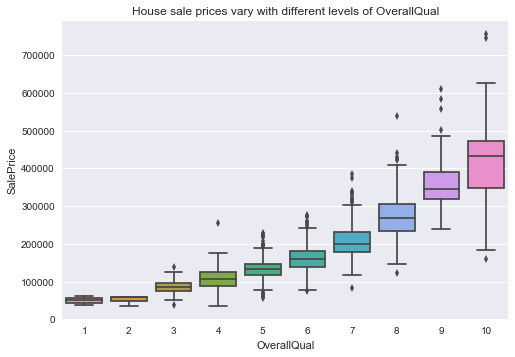

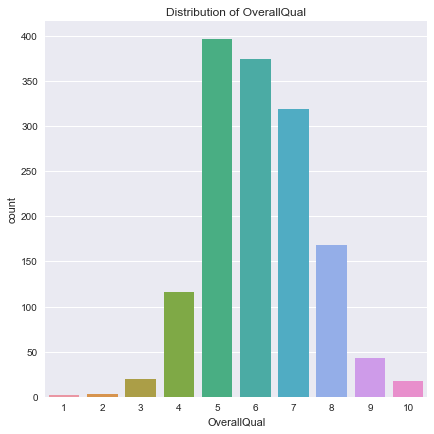

OverallQual
1       2
2       3
3      20
4     116
5     397
6     374
7     319
8     168
9      43
10     18
Name: OverallQual, dtype: int64


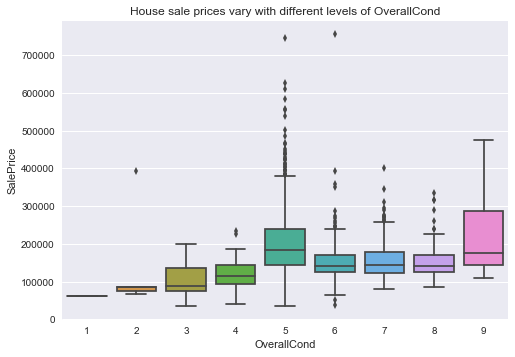

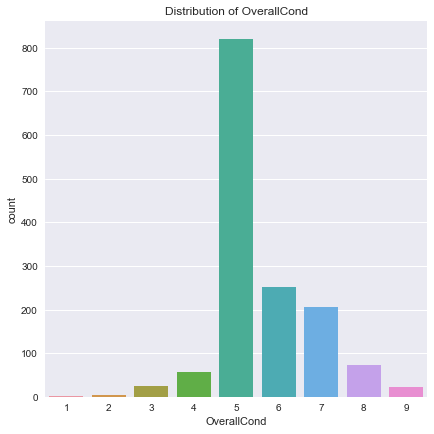

OverallCond
1      1
2      5
3     25
4     57
5    821
6    252
7    205
8     72
9     22
Name: OverallCond, dtype: int64


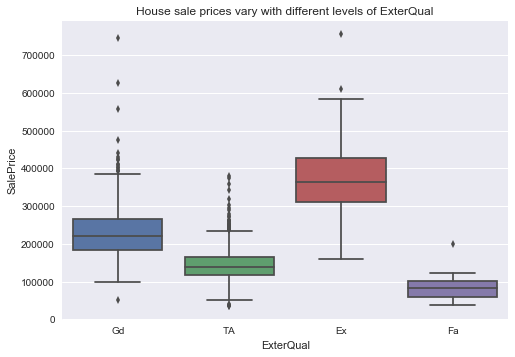

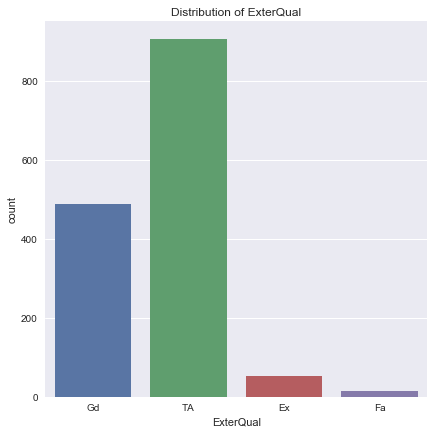

ExterQual
Ex     52
Fa     14
Gd    488
TA    906
Name: ExterQual, dtype: int64


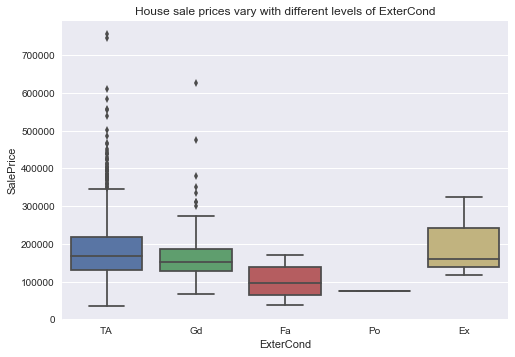

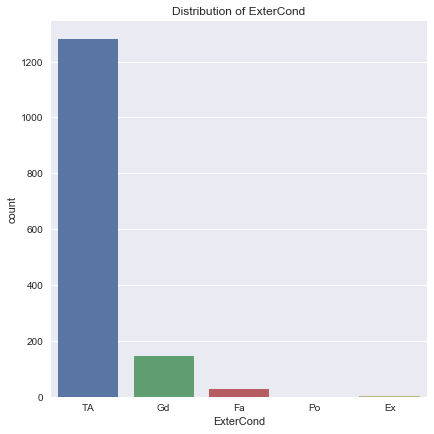

ExterCond
Ex       3
Fa      28
Gd     146
Po       1
TA    1282
Name: ExterCond, dtype: int64


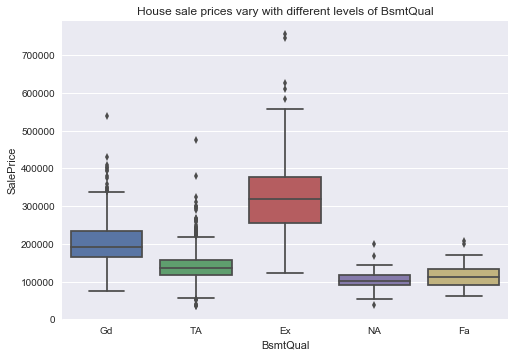

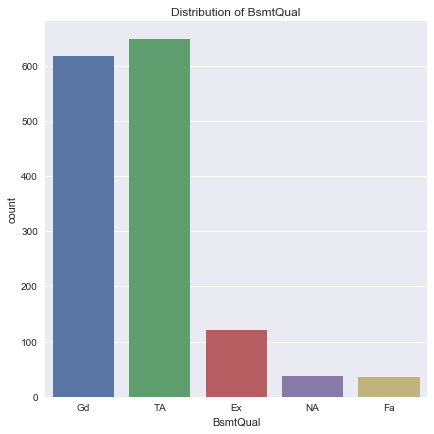

BsmtQual
Ex    121
Fa     35
Gd    618
NA     37
TA    649
Name: BsmtQual, dtype: int64


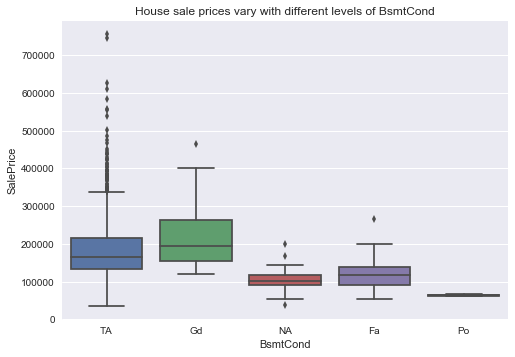

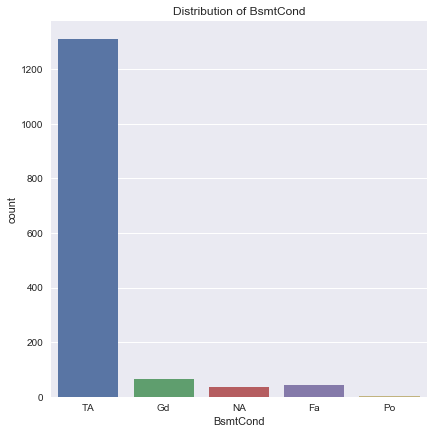

BsmtCond
Fa      45
Gd      65
NA      37
Po       2
TA    1311
Name: BsmtCond, dtype: int64


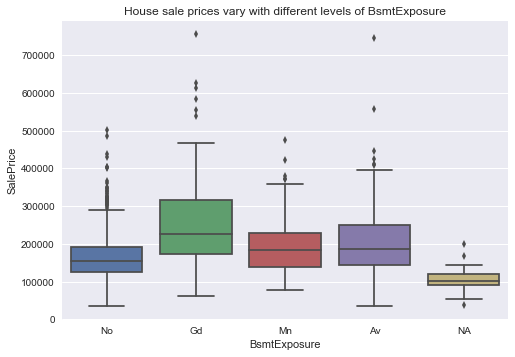

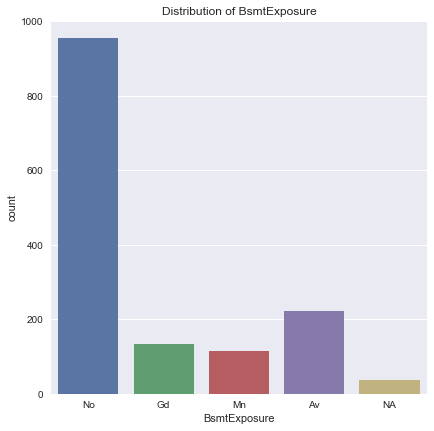

BsmtExposure
Av    221
Gd    134
Mn    114
NA     37
No    954
Name: BsmtExposure, dtype: int64


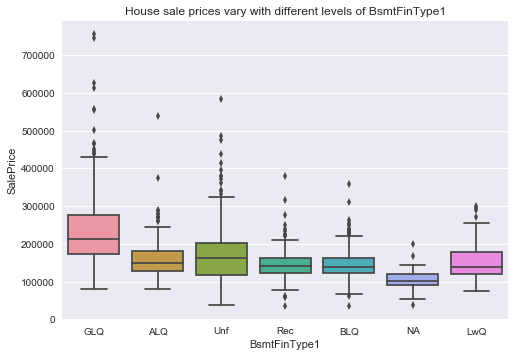

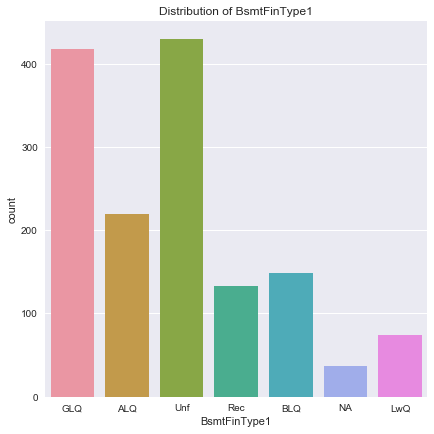

BsmtFinType1
ALQ    220
BLQ    148
GLQ    418
LwQ     74
NA      37
Rec    133
Unf    430
Name: BsmtFinType1, dtype: int64


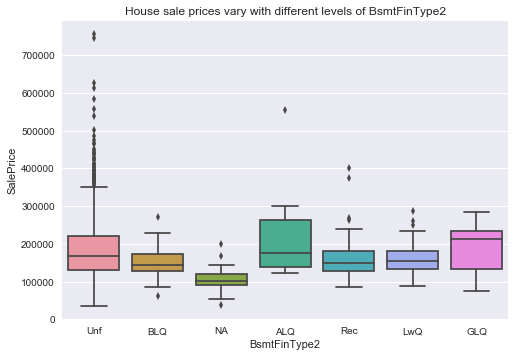

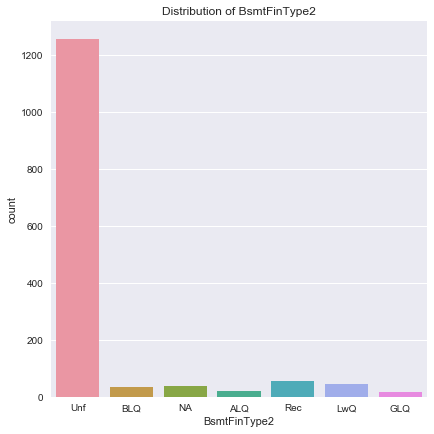

BsmtFinType2
ALQ      19
BLQ      33
GLQ      15
LwQ      46
NA       37
Rec      54
Unf    1256
Name: BsmtFinType2, dtype: int64


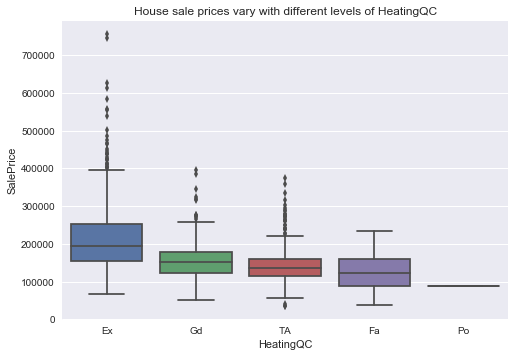

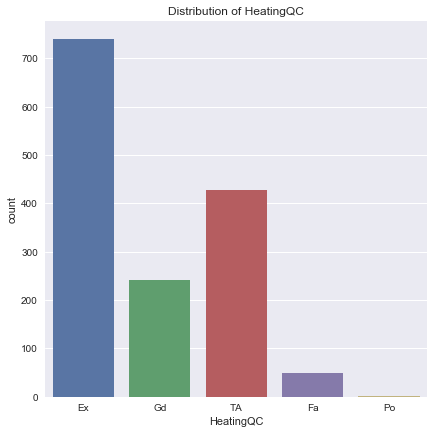

HeatingQC
Ex    741
Fa     49
Gd    241
Po      1
TA    428
Name: HeatingQC, dtype: int64


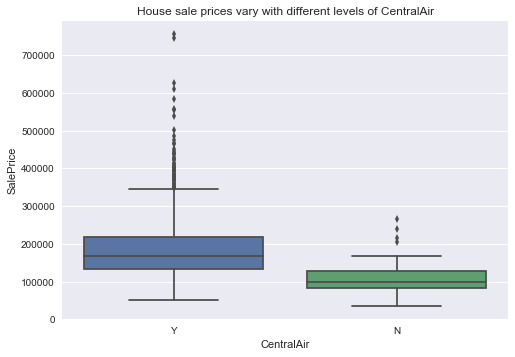

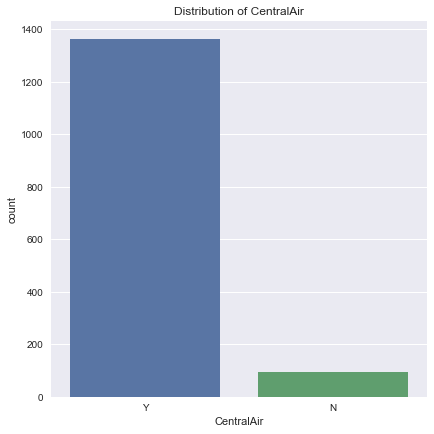

CentralAir
N      95
Y    1365
Name: CentralAir, dtype: int64


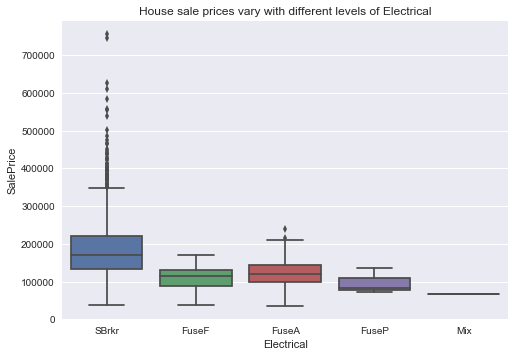

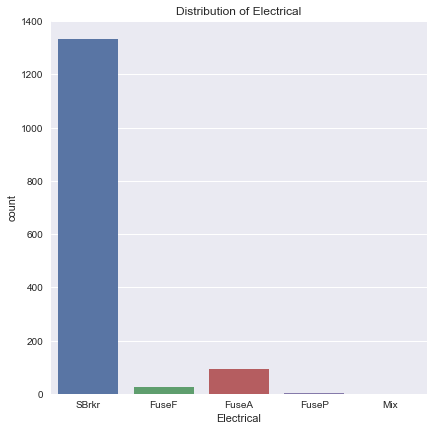

Electrical
FuseA      94
FuseF      27
FuseP       3
Mix         1
SBrkr    1335
Name: Electrical, dtype: int64


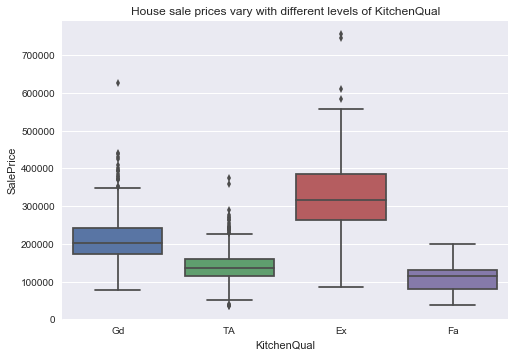

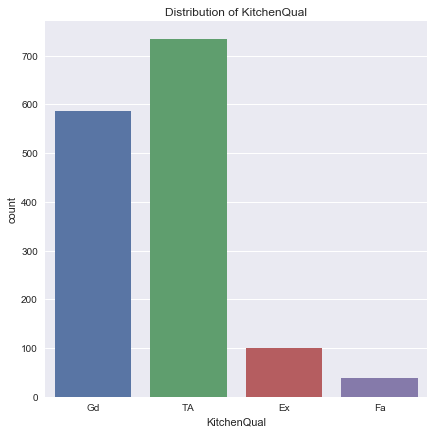

KitchenQual
Ex    100
Fa     39
Gd    586
TA    735
Name: KitchenQual, dtype: int64


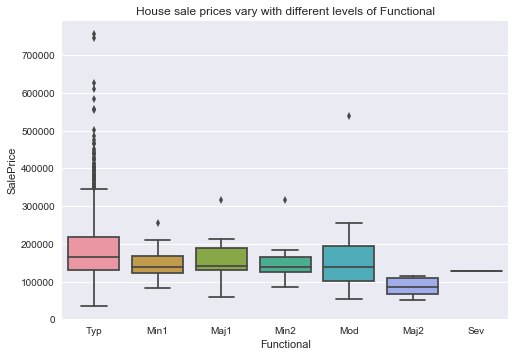

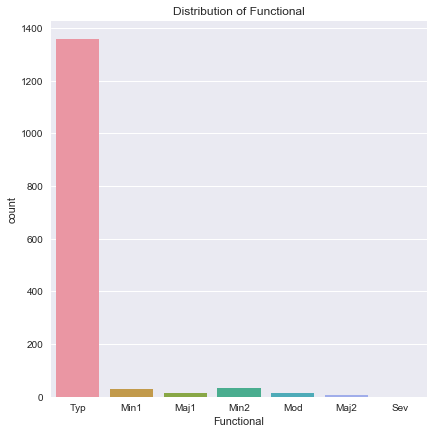

Functional
Maj1      14
Maj2       5
Min1      31
Min2      34
Mod       15
Sev        1
Typ     1360
Name: Functional, dtype: int64


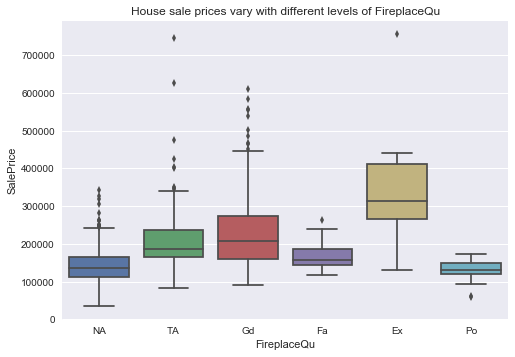

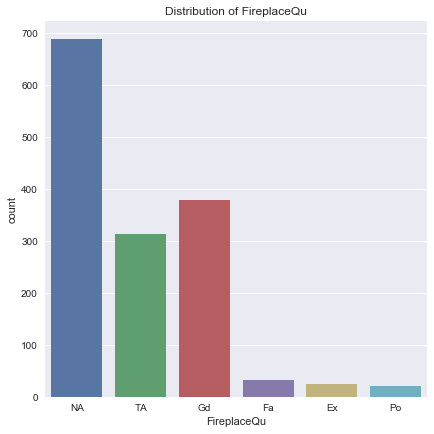

FireplaceQu
Ex     24
Fa     33
Gd    380
NA    690
Po     20
TA    313
Name: FireplaceQu, dtype: int64


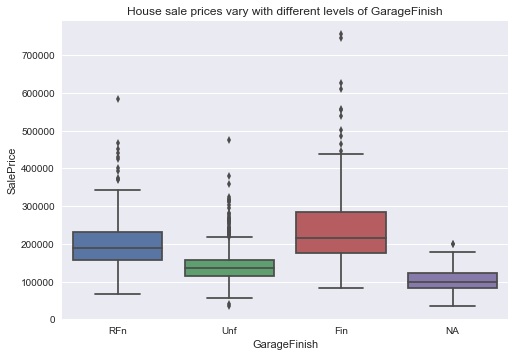

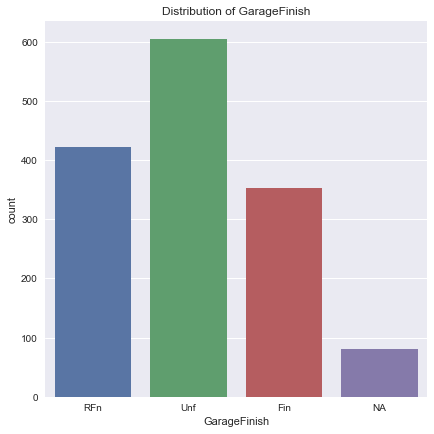

GarageFinish
Fin    352
NA      81
RFn    422
Unf    605
Name: GarageFinish, dtype: int64


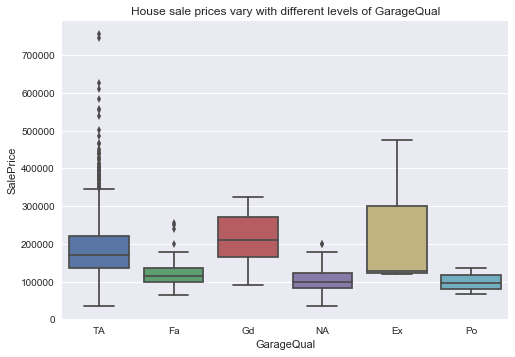

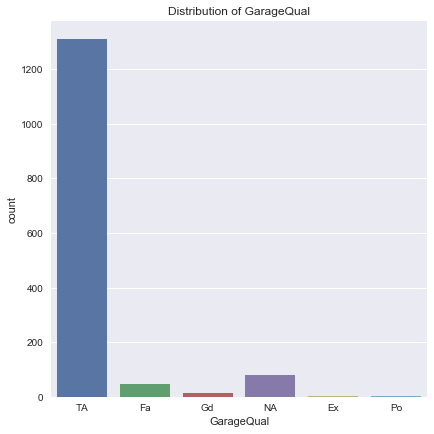

GarageQual
Ex       3
Fa      48
Gd      14
NA      81
Po       3
TA    1311
Name: GarageQual, dtype: int64


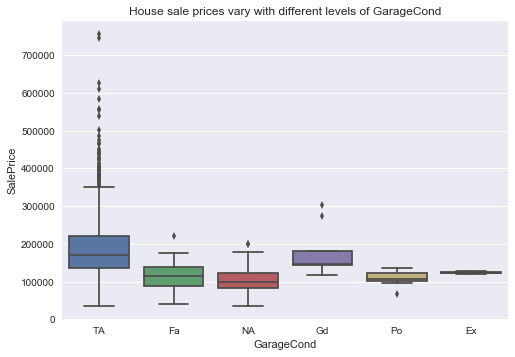

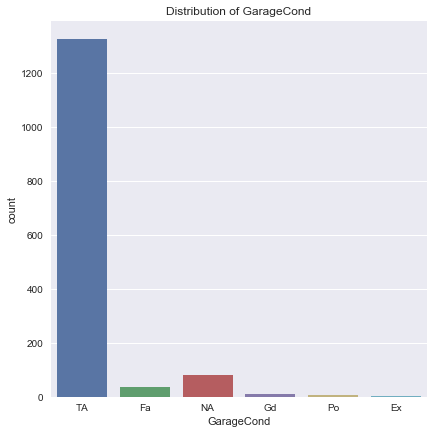

GarageCond
Ex       2
Fa      35
Gd       9
NA      81
Po       7
TA    1326
Name: GarageCond, dtype: int64


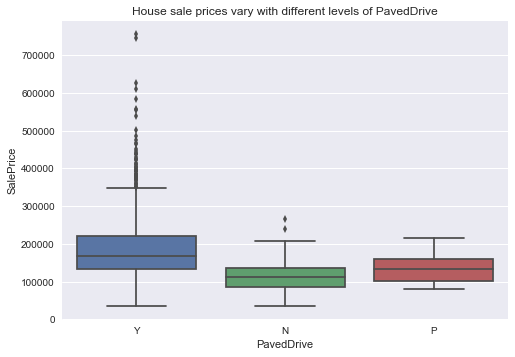

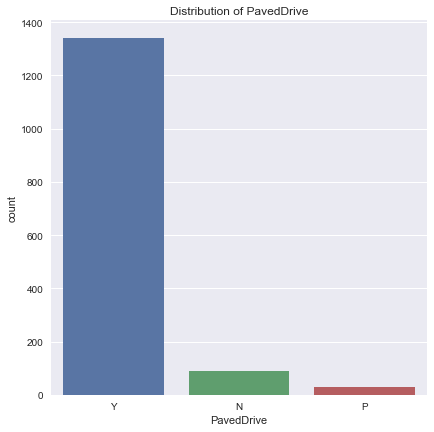

PavedDrive
N      90
P      30
Y    1340
Name: PavedDrive, dtype: int64


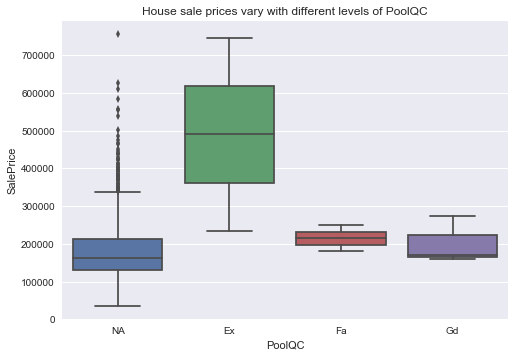

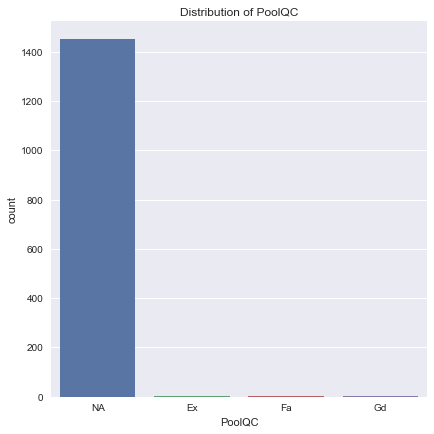

PoolQC
Ex       2
Fa       2
Gd       3
NA    1453
Name: PoolQC, dtype: int64


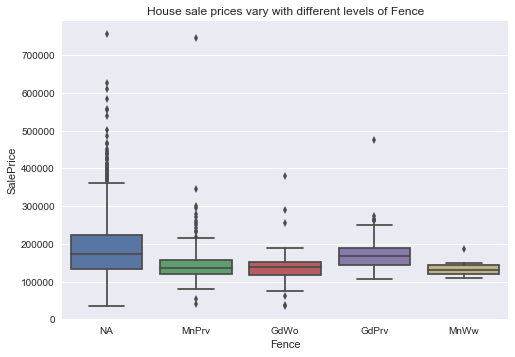

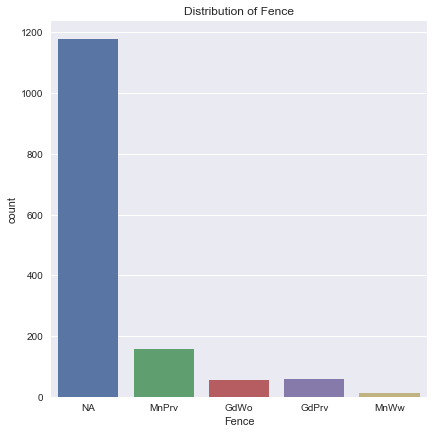

Fence
GdPrv      59
GdWo       54
MnPrv     157
MnWw       11
NA       1179
Name: Fence, dtype: int64


In [48]:
# Look at distribution of each ordinal feature
for var in ordinal_features:
    grid = sns.boxplot(x=var,y='SalePrice',data=train_data_clean)
    plt.title('House sale prices vary with different levels of %s' % var)
    plt.show()
    g = sns.factorplot(x=var,data=train_data_clean,kind='count',size=6,aspect=1)
    plt.title('Distribution of %s' % var)
    plt.show()
    print train_data_clean[var].groupby(train_data_clean[var]).count()

In [49]:
# Use prior knowledge to combine levels preliminarily
pre_ordinal_conversion={}
pre_ordinal_conversion['LotShape']={'Reg':'Reg','IR1':'IR','IR2':'IR','IR3':'IR'}
pre_ordinal_conversion['LandSlope']={'Gtl':'Gtl','Mod':'Mod','Sev':'Mod'}
pre_ordinal_conversion['OverallQual']={1:'Po',2:'Po',3:'Po',4:'Po',5:'Fa',6:'TA',7:'Gd',8:'Ex',9:'Ex',10:'Ex'}
pre_ordinal_conversion['OverallCond']={1:'Po',2:'Po',3:'Po',4:'Po',5:'Fa',6:'TA',7:'Gd',8:'Ex',9:'Ex',10:'Ex'}
pre_ordinal_conversion['ExterQual']={'Fa':'TA','TA':'TA','Gd':'Gd','Ex':'Ex'}
pre_ordinal_conversion['ExterCond']={'Po':'TA','Fa':'TA','TA':'TA','Gd':'Gd','Ex':'Gd'}
pre_ordinal_conversion['BsmtCond']={'NA':'Fa','Po':'Fa','Fa':'Fa','TA':'TA','Gd':'Gd'}
pre_ordinal_conversion['BsmtFinType2']={'ALQ':'GLQ','BLQ':'GLQ','GLQ':'GLQ','Rec':'GLQ','Unf':'Unf','LwQ':'LwQ','NA':'LwQ'}
pre_ordinal_conversion['FireplaceQu']={'Ex':'Gd','Gd':'Gd','TA':'TA','Fa':'Fa','Po':'Fa','NA':'NA'}
pre_ordinal_conversion['GarageQual']={'Ex':'TA','Gd':'TA','TA':'TA','Fa':'Fa','Po':'Fa','NA':'NA'}
pre_ordinal_conversion['GarageCond']={'Ex':'TA','Gd':'TA','TA':'TA','Fa':'Fa','Po':'Fa','NA':'NA'}
pre_ordinal_conversion['PavedDrive']={'N':'N','P':'N','Y':'Y'}
pre_ordinal_conversion['Fence']={'GdPrv':'Y','GdWo':'Y','MnPrv':'Y','MnWw':'Y','NA':'N'}



In [50]:
for key in pre_ordinal_conversion:
    train_data_clean[key]=train_data_clean[key].map(pre_ordinal_conversion[key])

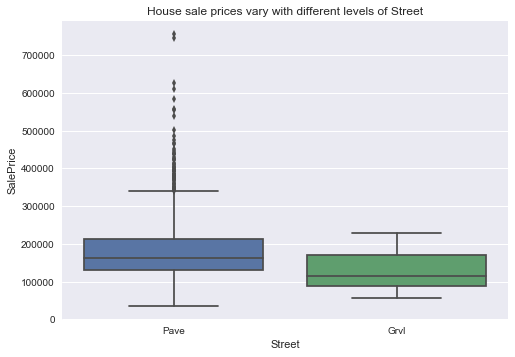

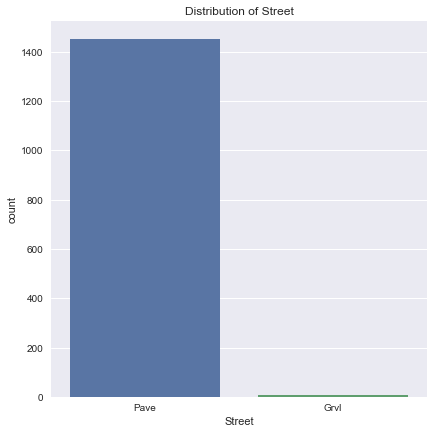

Street
Grvl       6
Pave    1454
Name: Street, dtype: int64


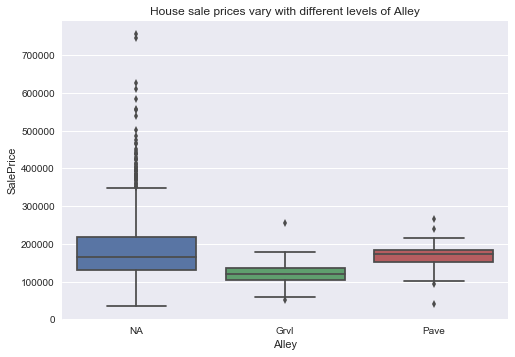

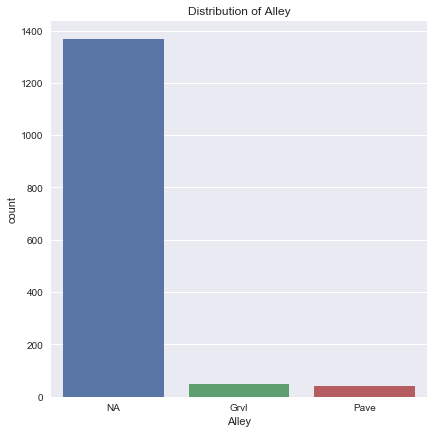

Alley
Grvl      50
NA      1369
Pave      41
Name: Alley, dtype: int64


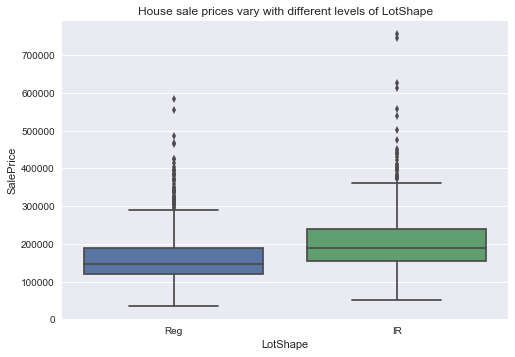

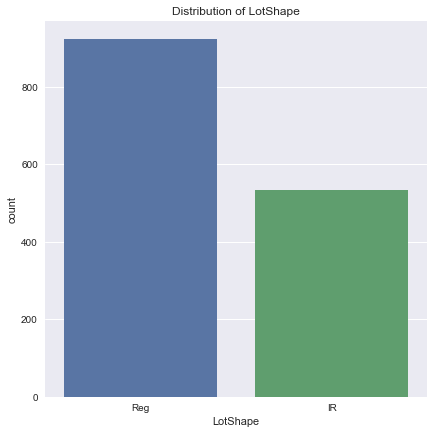

LotShape
IR     535
Reg    925
Name: LotShape, dtype: int64


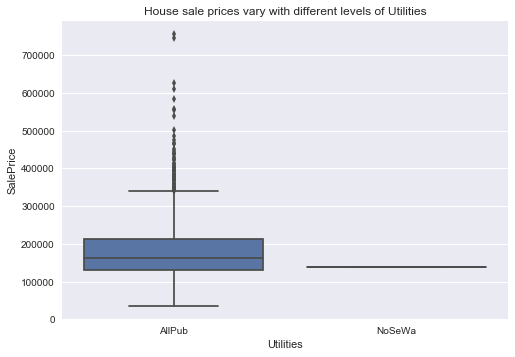

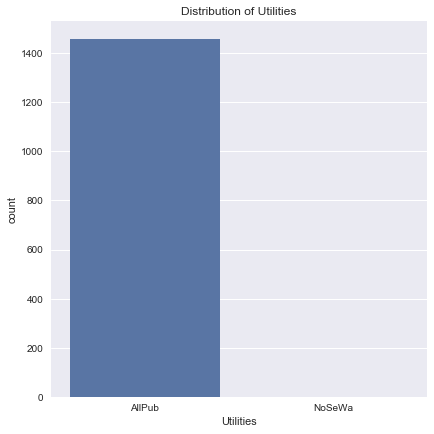

Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


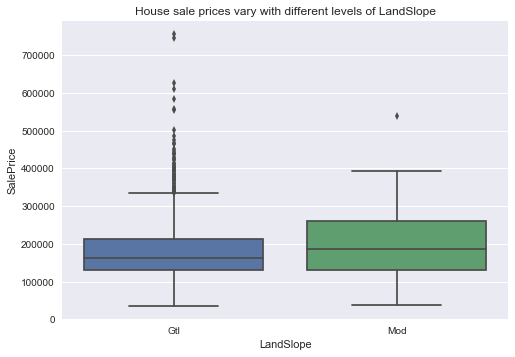

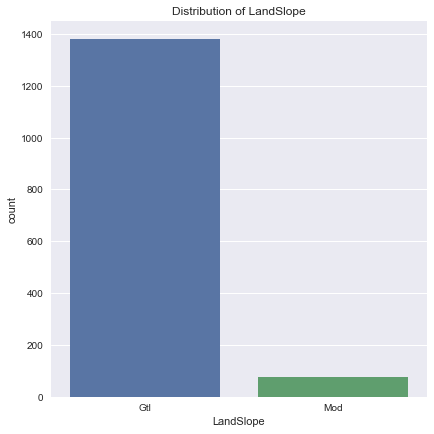

LandSlope
Gtl    1382
Mod      78
Name: LandSlope, dtype: int64


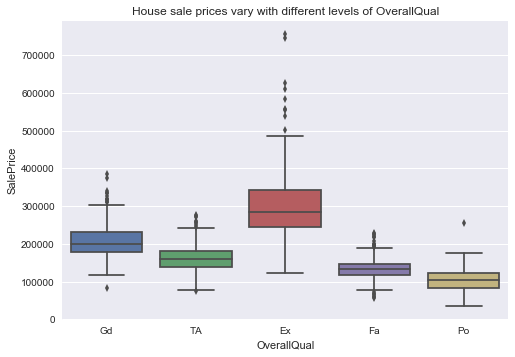

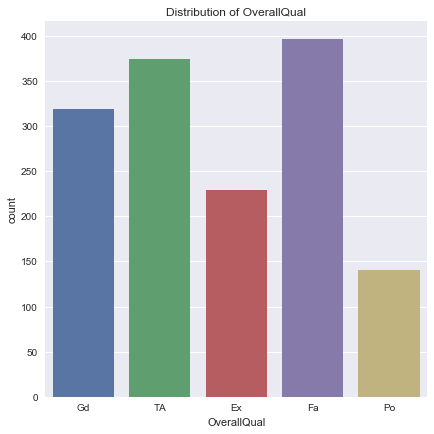

OverallQual
Ex    229
Fa    397
Gd    319
Po    141
TA    374
Name: OverallQual, dtype: int64


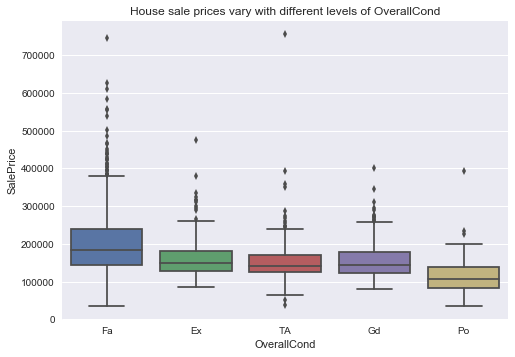

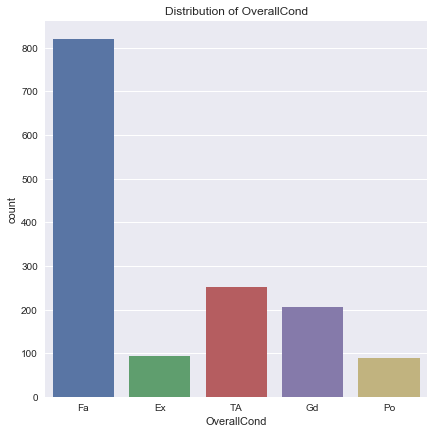

OverallCond
Ex     94
Fa    821
Gd    205
Po     88
TA    252
Name: OverallCond, dtype: int64


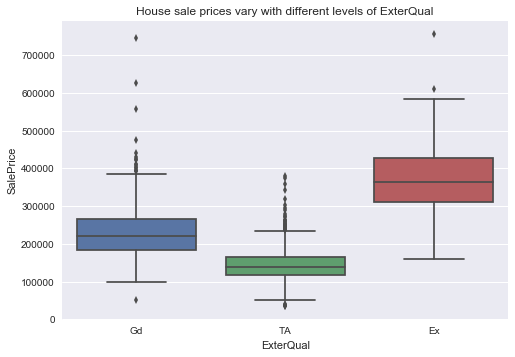

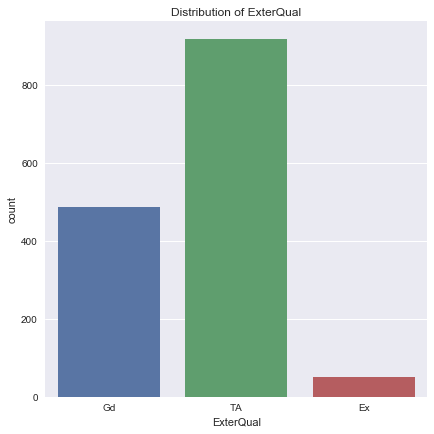

ExterQual
Ex     52
Gd    488
TA    920
Name: ExterQual, dtype: int64


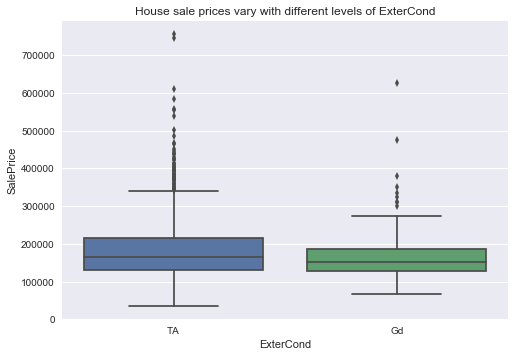

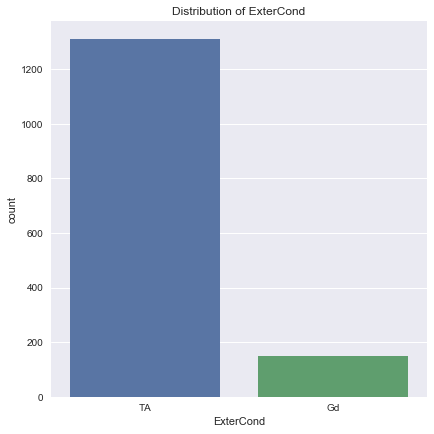

ExterCond
Gd     149
TA    1311
Name: ExterCond, dtype: int64


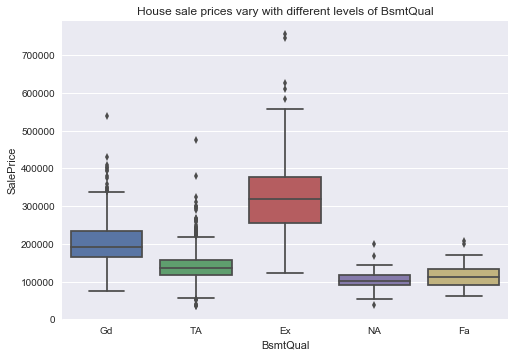

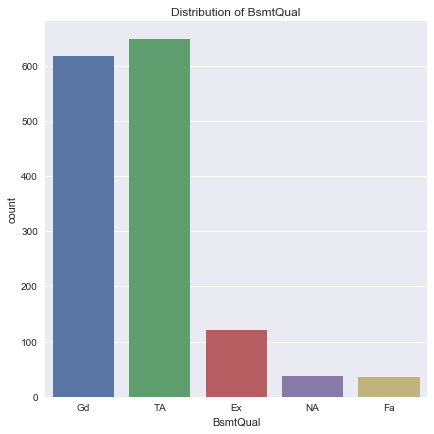

BsmtQual
Ex    121
Fa     35
Gd    618
NA     37
TA    649
Name: BsmtQual, dtype: int64


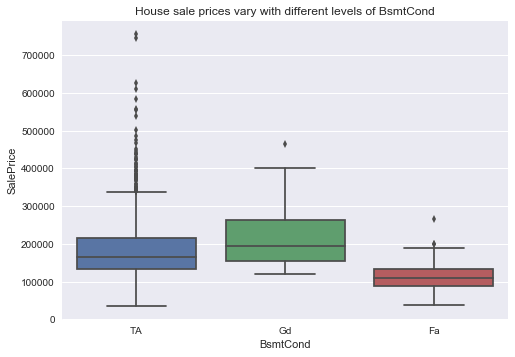

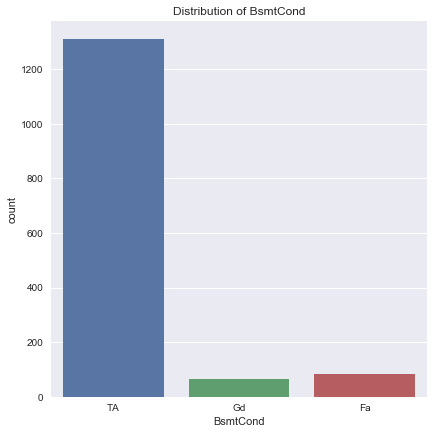

BsmtCond
Fa      84
Gd      65
TA    1311
Name: BsmtCond, dtype: int64


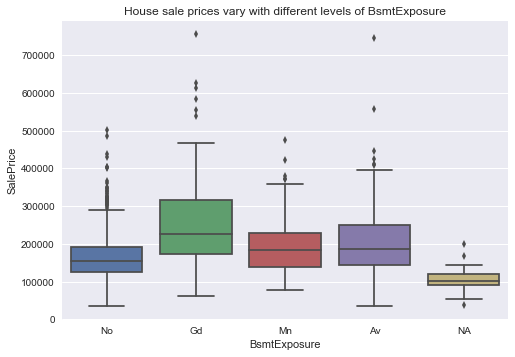

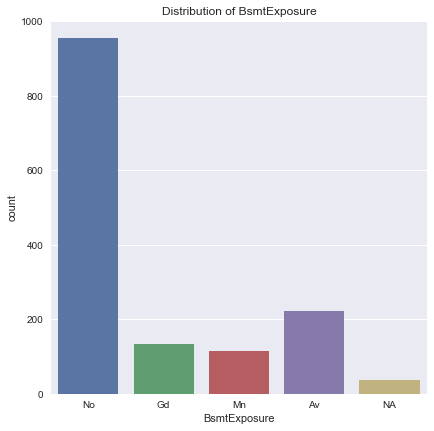

BsmtExposure
Av    221
Gd    134
Mn    114
NA     37
No    954
Name: BsmtExposure, dtype: int64


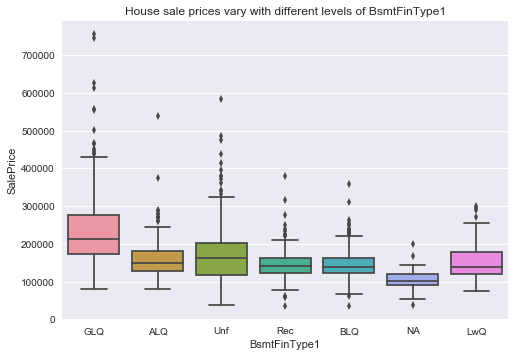

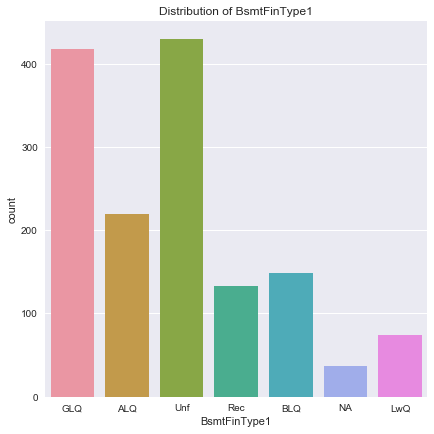

BsmtFinType1
ALQ    220
BLQ    148
GLQ    418
LwQ     74
NA      37
Rec    133
Unf    430
Name: BsmtFinType1, dtype: int64


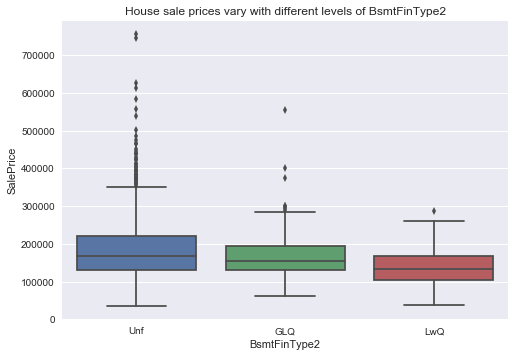

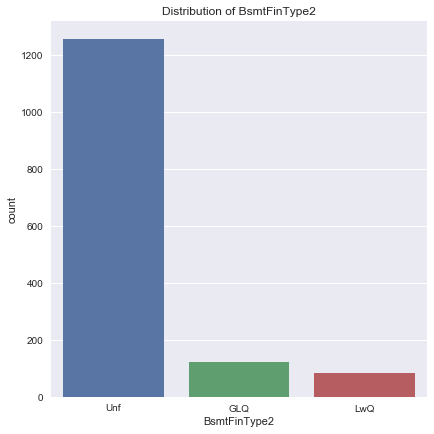

BsmtFinType2
GLQ     121
LwQ      83
Unf    1256
Name: BsmtFinType2, dtype: int64


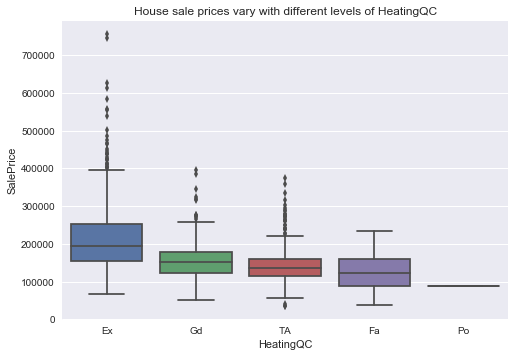

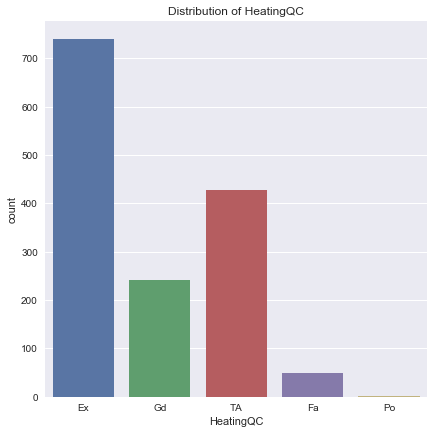

HeatingQC
Ex    741
Fa     49
Gd    241
Po      1
TA    428
Name: HeatingQC, dtype: int64


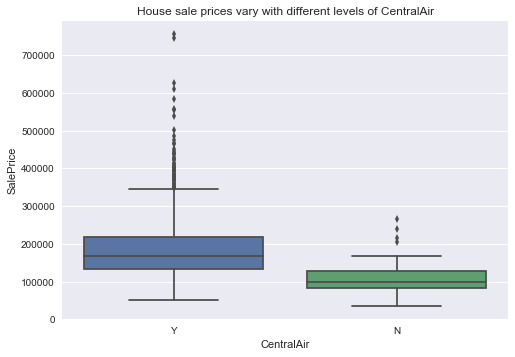

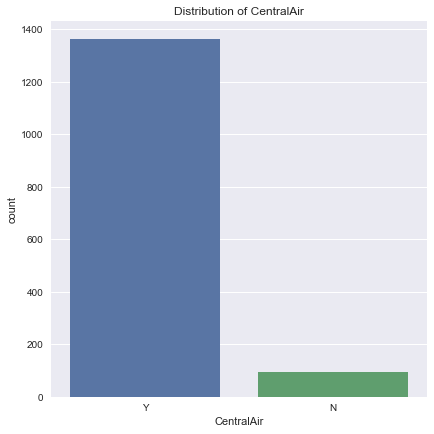

CentralAir
N      95
Y    1365
Name: CentralAir, dtype: int64


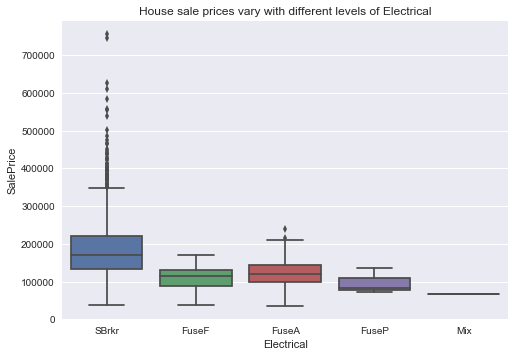

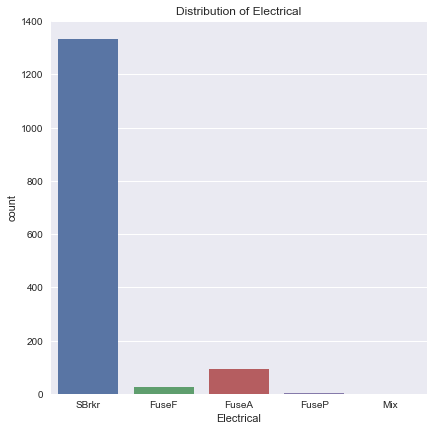

Electrical
FuseA      94
FuseF      27
FuseP       3
Mix         1
SBrkr    1335
Name: Electrical, dtype: int64


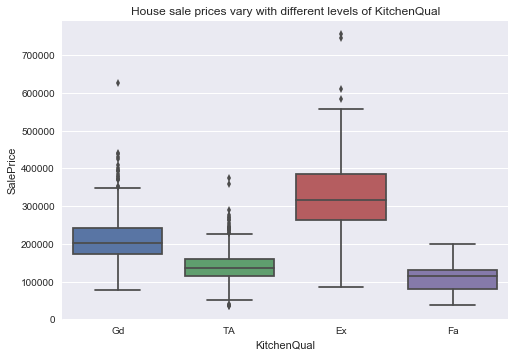

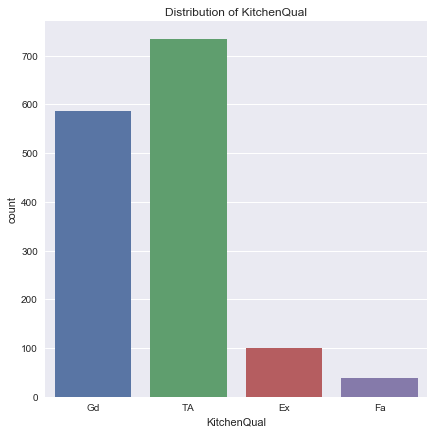

KitchenQual
Ex    100
Fa     39
Gd    586
TA    735
Name: KitchenQual, dtype: int64


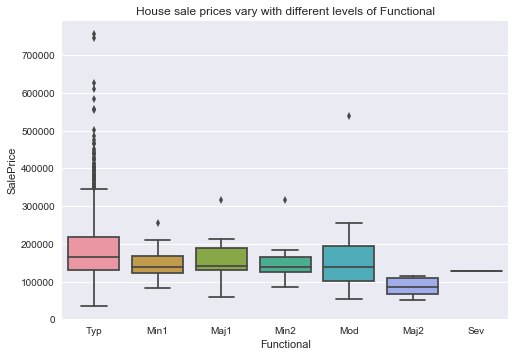

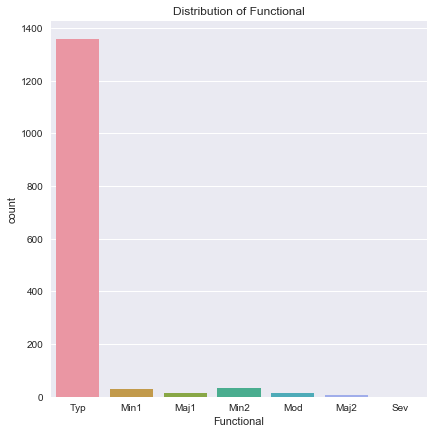

Functional
Maj1      14
Maj2       5
Min1      31
Min2      34
Mod       15
Sev        1
Typ     1360
Name: Functional, dtype: int64


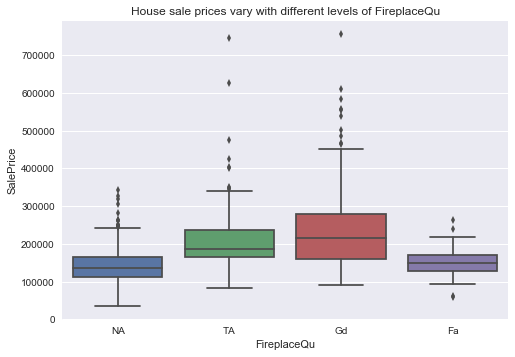

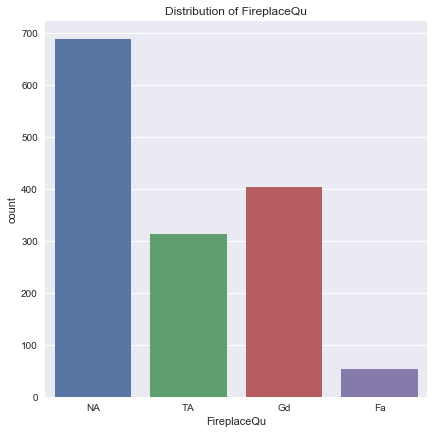

FireplaceQu
Fa     53
Gd    404
NA    690
TA    313
Name: FireplaceQu, dtype: int64


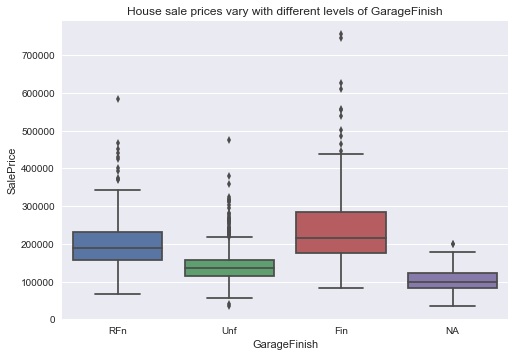

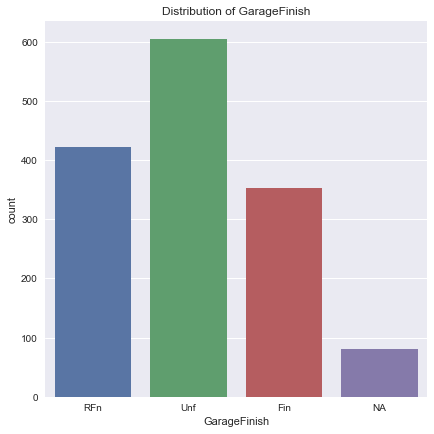

GarageFinish
Fin    352
NA      81
RFn    422
Unf    605
Name: GarageFinish, dtype: int64


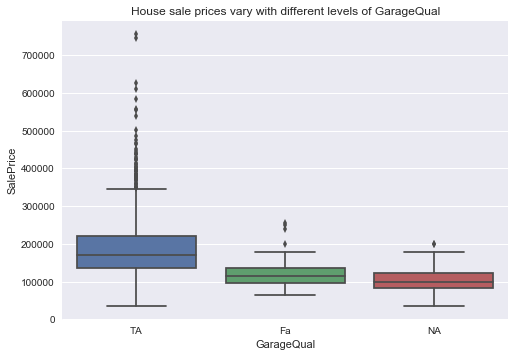

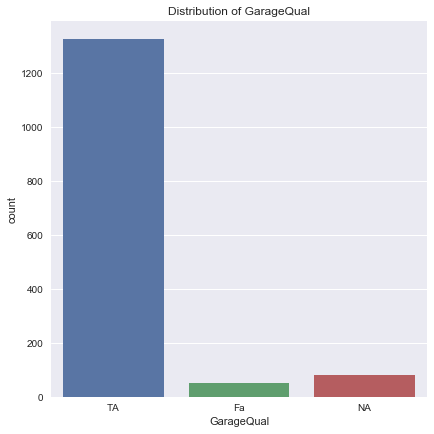

GarageQual
Fa      51
NA      81
TA    1328
Name: GarageQual, dtype: int64


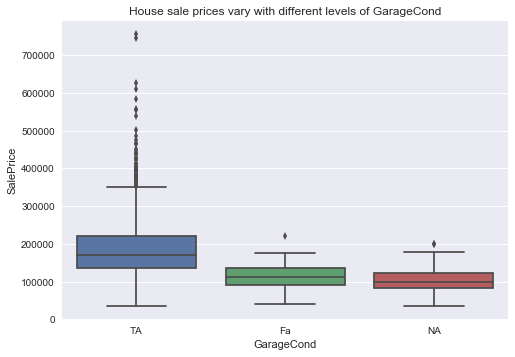

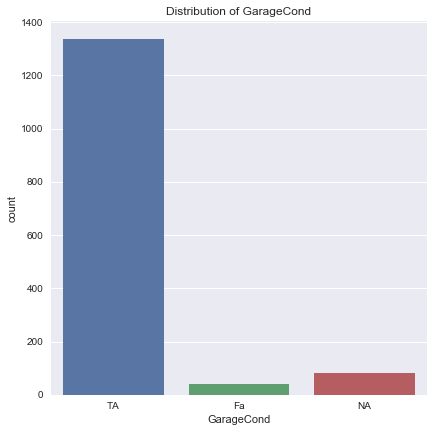

GarageCond
Fa      42
NA      81
TA    1337
Name: GarageCond, dtype: int64


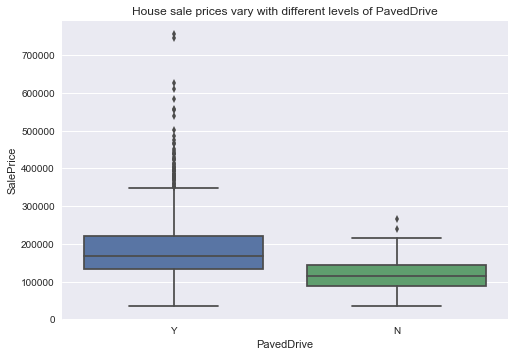

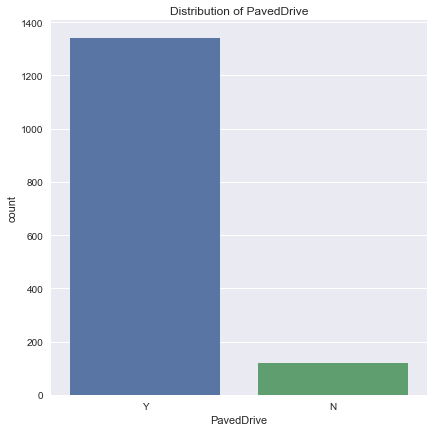

PavedDrive
N     120
Y    1340
Name: PavedDrive, dtype: int64


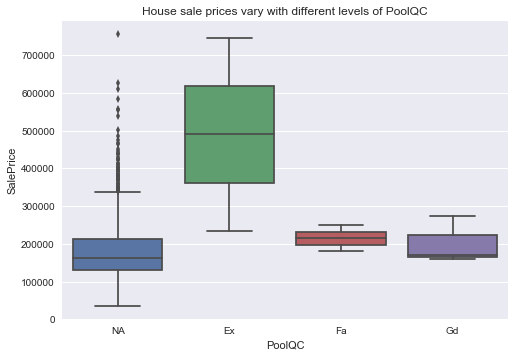

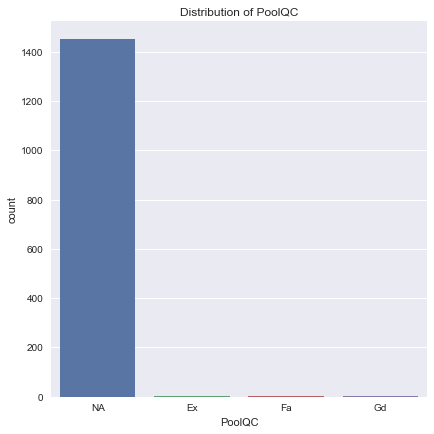

PoolQC
Ex       2
Fa       2
Gd       3
NA    1453
Name: PoolQC, dtype: int64


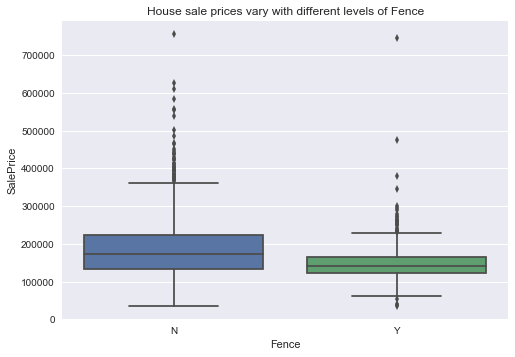

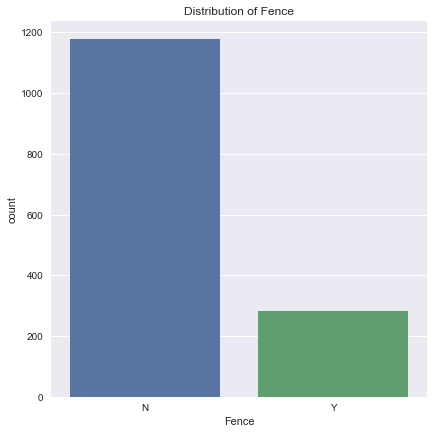

Fence
N    1179
Y     281
Name: Fence, dtype: int64


In [51]:
# Check distribution of each ordinal feature after preliminary level conversion
for var in ordinal_features:
    grid = sns.boxplot(x=var,y='SalePrice',data=train_data_clean)
    plt.title('House sale prices vary with different levels of %s' % var)
    plt.show()
    g = sns.factorplot(x=var,data=train_data_clean,kind='count',size=6,aspect=1)
    plt.title('Distribution of %s' % var)
    plt.show()
    print train_data_clean[var].groupby(train_data_clean[var]).count()

In [52]:
# Step 2 Perform 'combine_rare_levels' function to combine levels with less than 5% frequency to "Rare" Category
ordinal_lookup = {}
for var in ordinal_features:
    lookup = combine_rare_levels(train_data_clean[var])
    train_data_clean[var]=train_data_clean[var].map(lookup)
    ordinal_lookup[var]=lookup

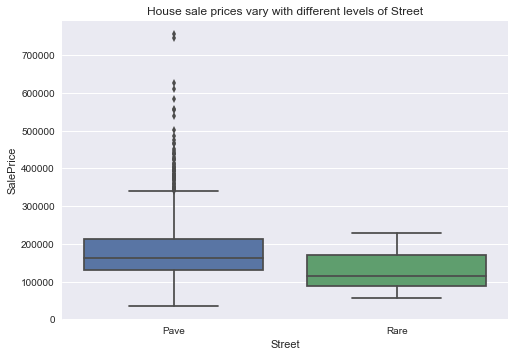

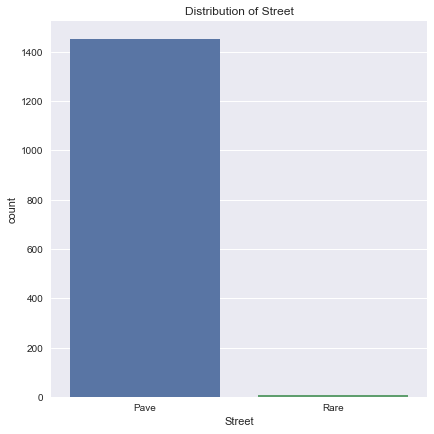

Street
Pave    1454
Rare       6
Name: Street, dtype: int64


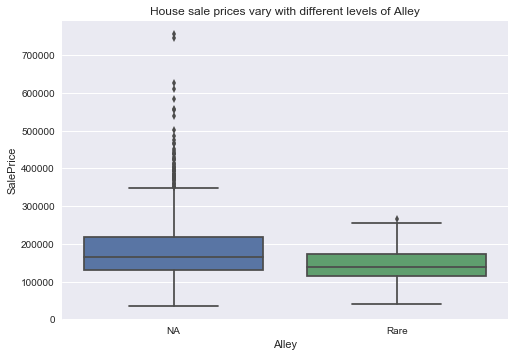

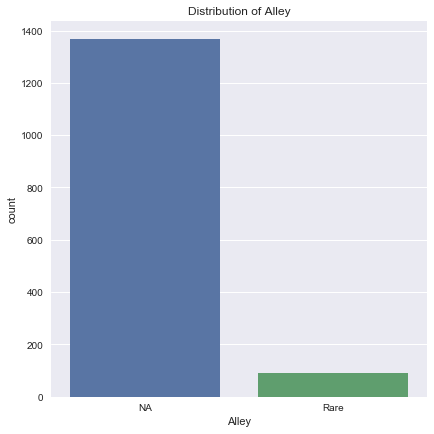

Alley
NA      1369
Rare      91
Name: Alley, dtype: int64


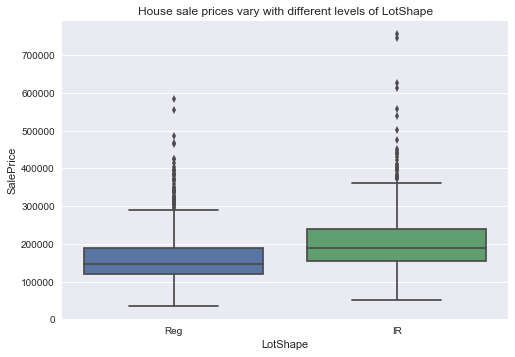

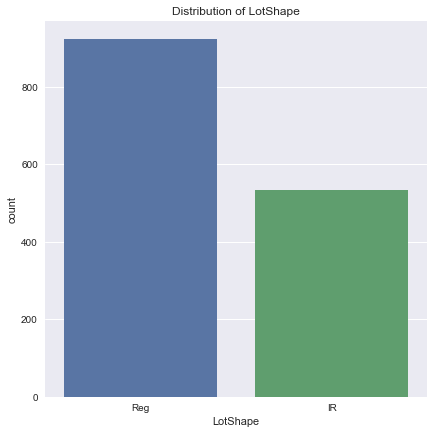

LotShape
IR     535
Reg    925
Name: LotShape, dtype: int64


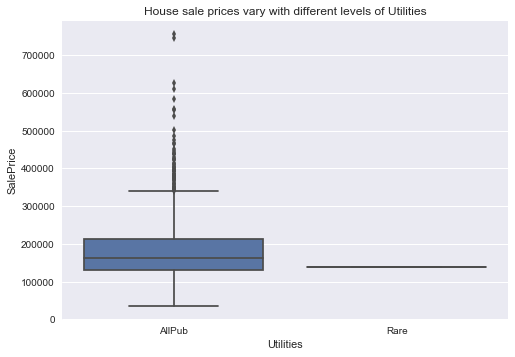

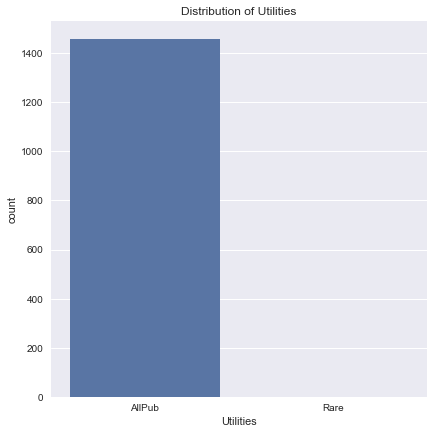

Utilities
AllPub    1459
Rare         1
Name: Utilities, dtype: int64


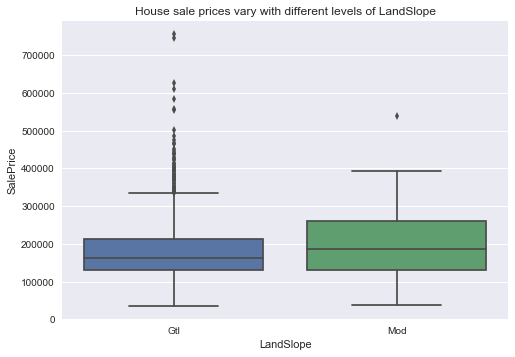

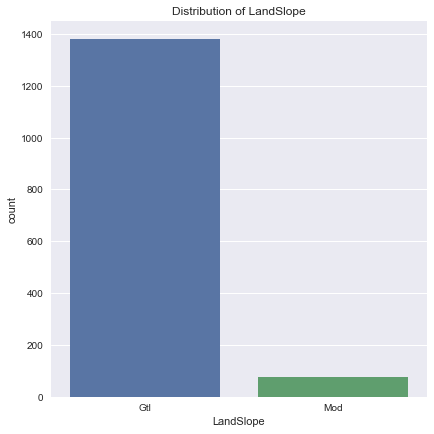

LandSlope
Gtl    1382
Mod      78
Name: LandSlope, dtype: int64


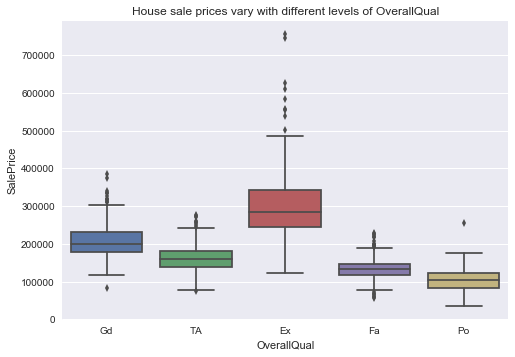

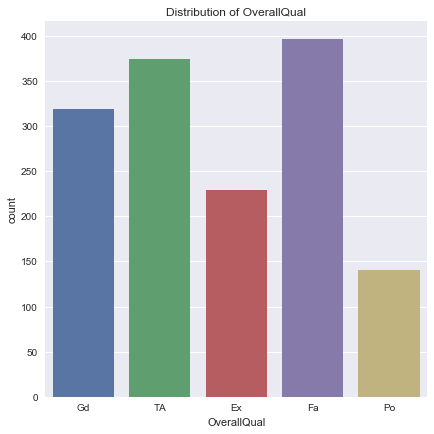

OverallQual
Ex    229
Fa    397
Gd    319
Po    141
TA    374
Name: OverallQual, dtype: int64


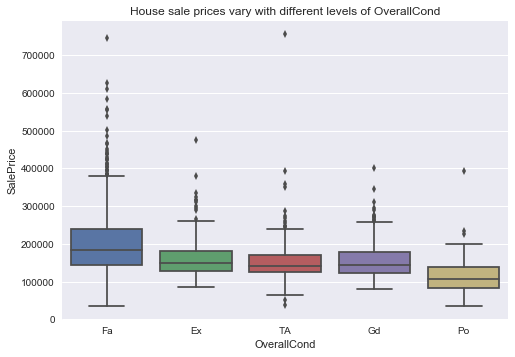

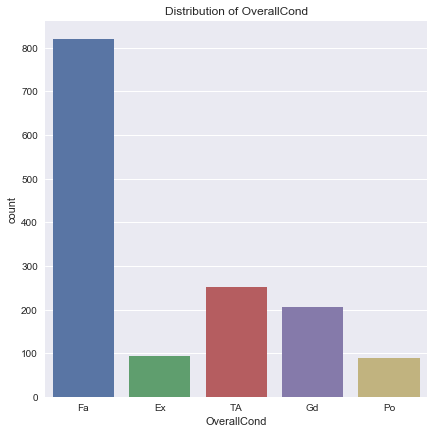

OverallCond
Ex     94
Fa    821
Gd    205
Po     88
TA    252
Name: OverallCond, dtype: int64


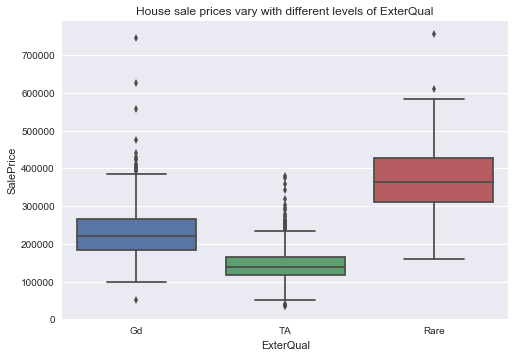

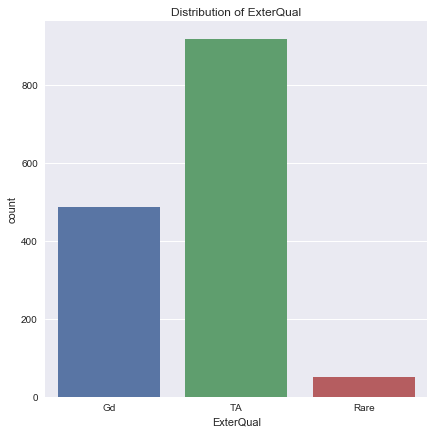

ExterQual
Gd      488
Rare     52
TA      920
Name: ExterQual, dtype: int64


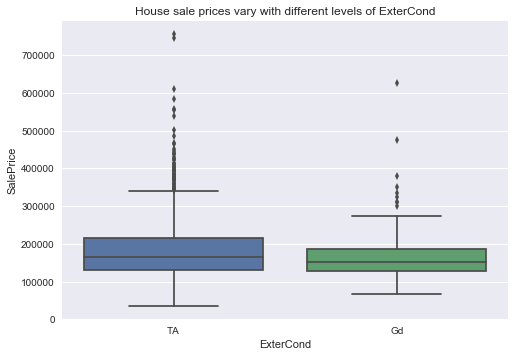

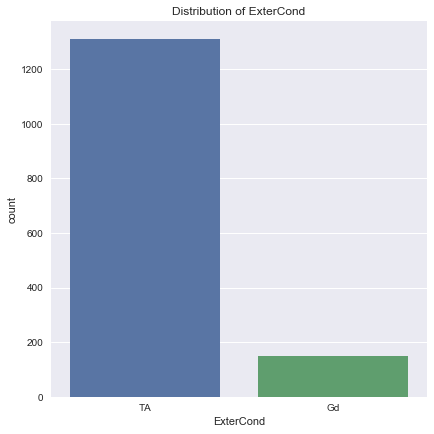

ExterCond
Gd     149
TA    1311
Name: ExterCond, dtype: int64


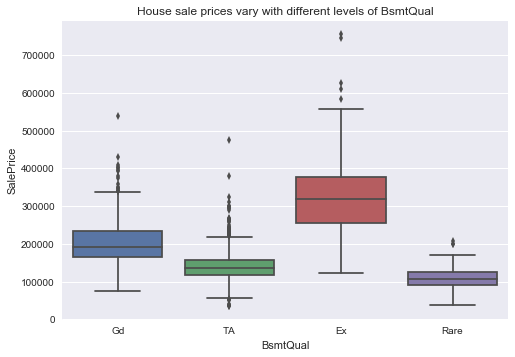

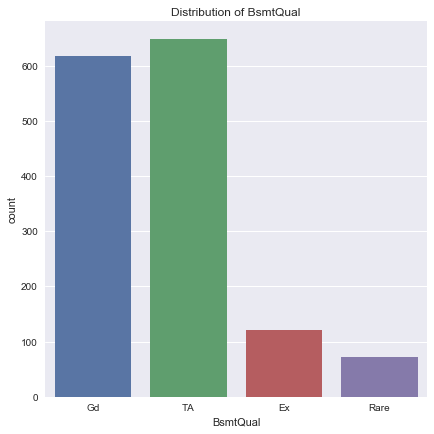

BsmtQual
Ex      121
Gd      618
Rare     72
TA      649
Name: BsmtQual, dtype: int64


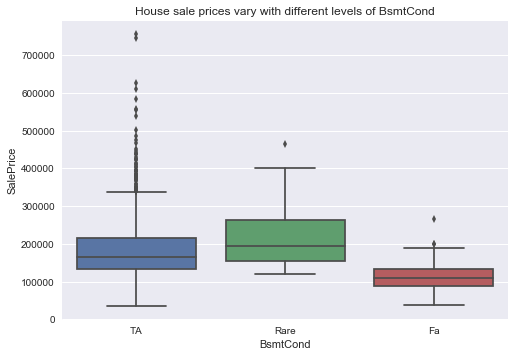

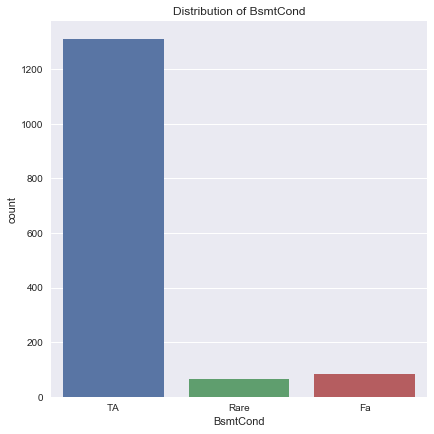

BsmtCond
Fa        84
Rare      65
TA      1311
Name: BsmtCond, dtype: int64


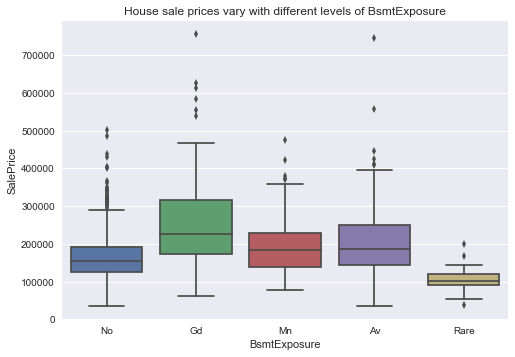

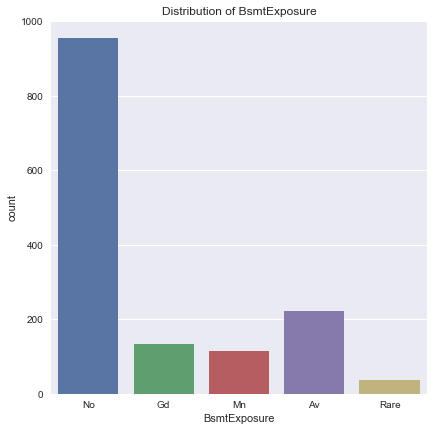

BsmtExposure
Av      221
Gd      134
Mn      114
No      954
Rare     37
Name: BsmtExposure, dtype: int64


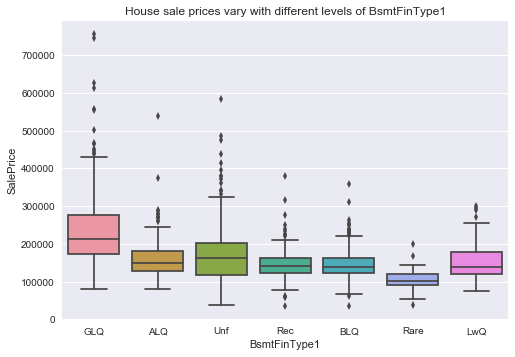

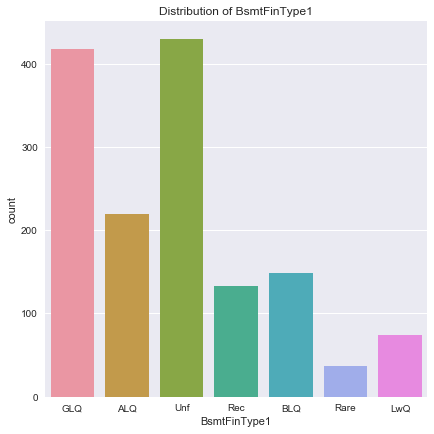

BsmtFinType1
ALQ     220
BLQ     148
GLQ     418
LwQ      74
Rare     37
Rec     133
Unf     430
Name: BsmtFinType1, dtype: int64


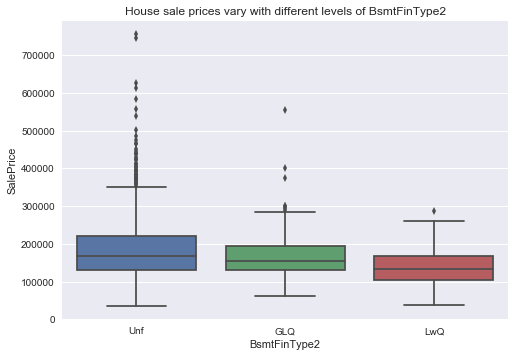

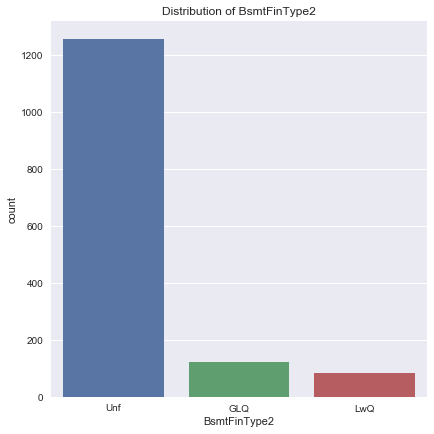

BsmtFinType2
GLQ     121
LwQ      83
Unf    1256
Name: BsmtFinType2, dtype: int64


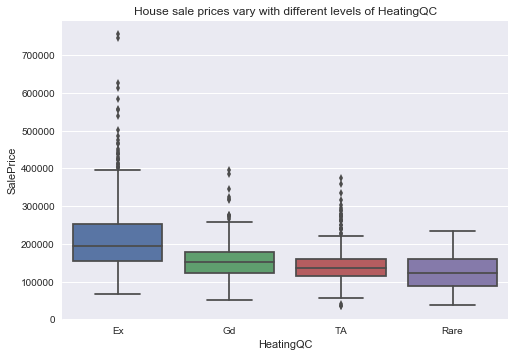

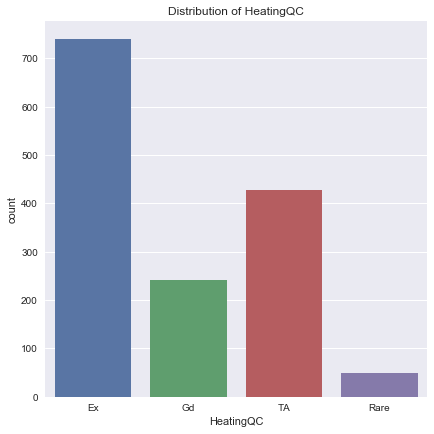

HeatingQC
Ex      741
Gd      241
Rare     50
TA      428
Name: HeatingQC, dtype: int64


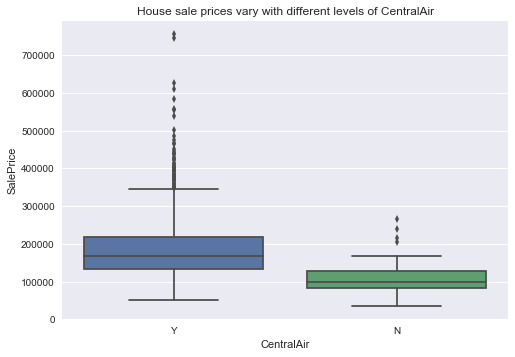

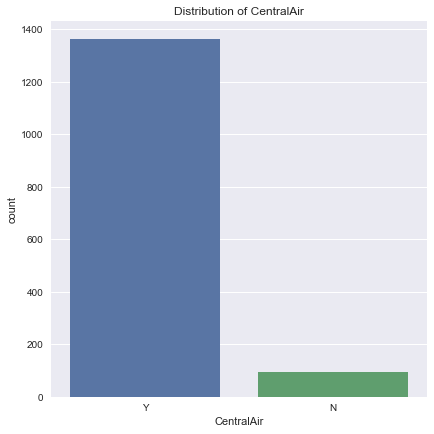

CentralAir
N      95
Y    1365
Name: CentralAir, dtype: int64


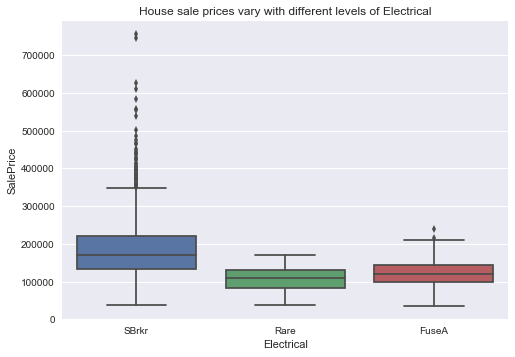

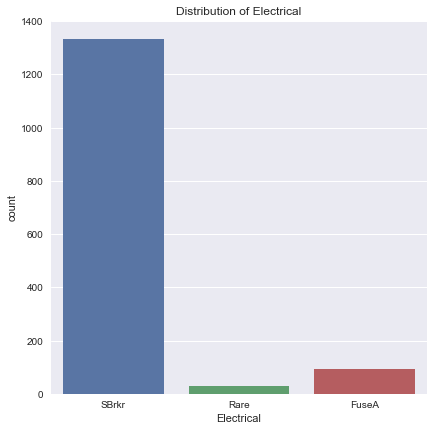

Electrical
FuseA      94
Rare       31
SBrkr    1335
Name: Electrical, dtype: int64


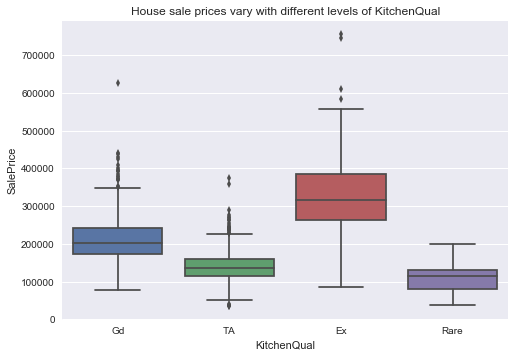

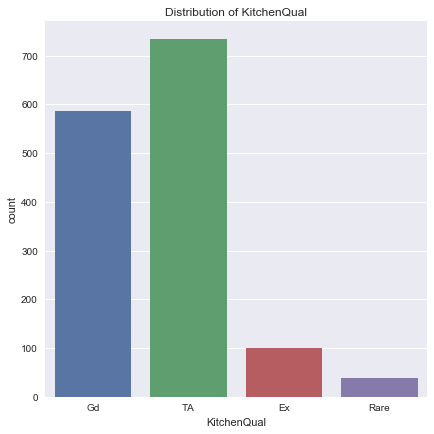

KitchenQual
Ex      100
Gd      586
Rare     39
TA      735
Name: KitchenQual, dtype: int64


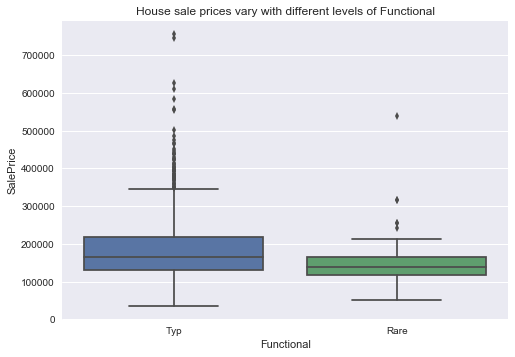

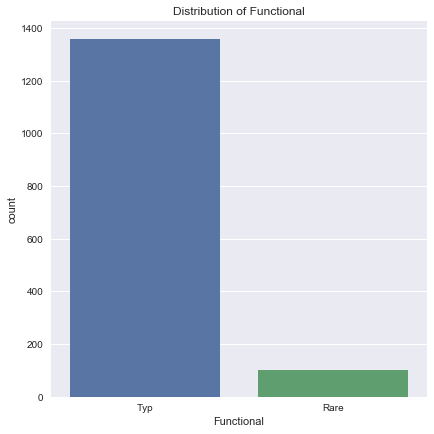

Functional
Rare     100
Typ     1360
Name: Functional, dtype: int64


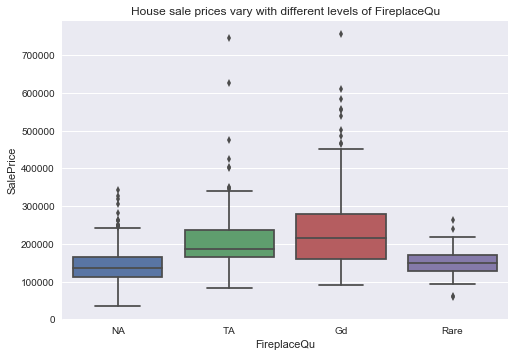

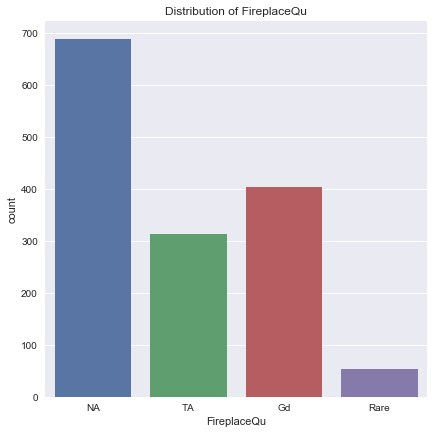

FireplaceQu
Gd      404
NA      690
Rare     53
TA      313
Name: FireplaceQu, dtype: int64


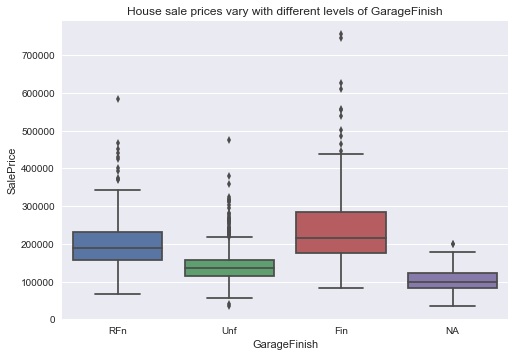

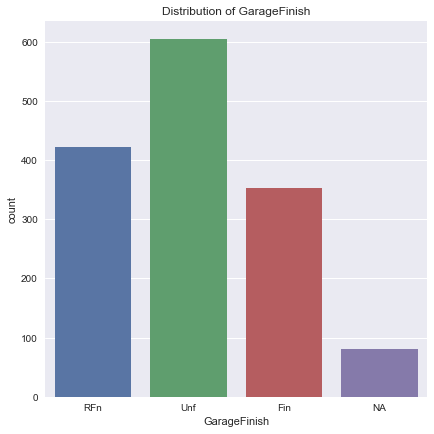

GarageFinish
Fin    352
NA      81
RFn    422
Unf    605
Name: GarageFinish, dtype: int64


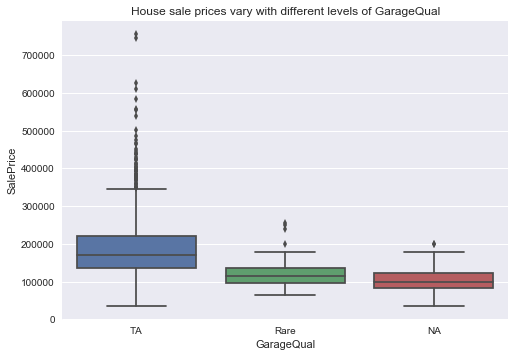

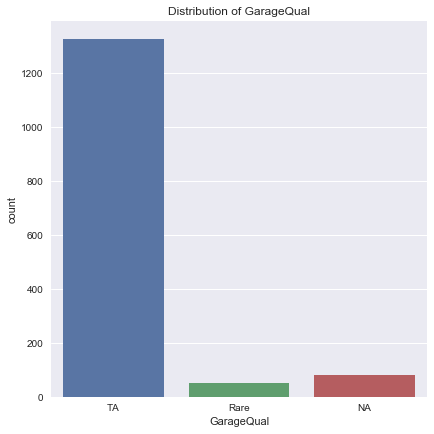

GarageQual
NA        81
Rare      51
TA      1328
Name: GarageQual, dtype: int64


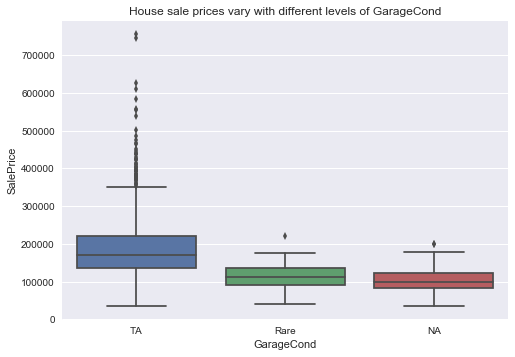

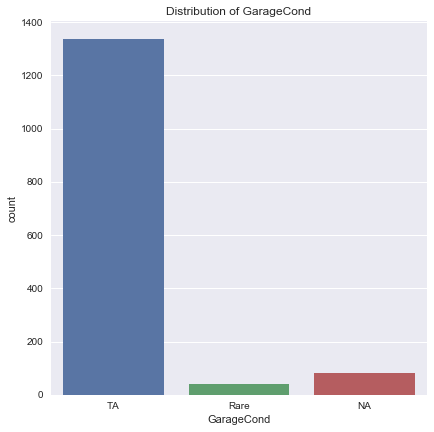

GarageCond
NA        81
Rare      42
TA      1337
Name: GarageCond, dtype: int64


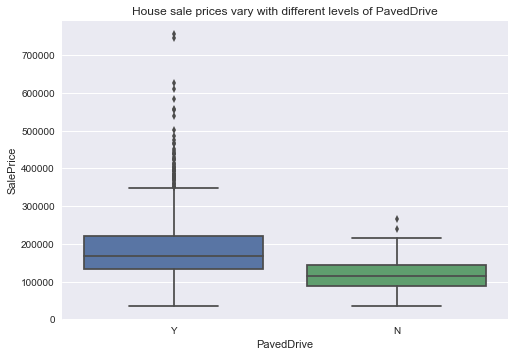

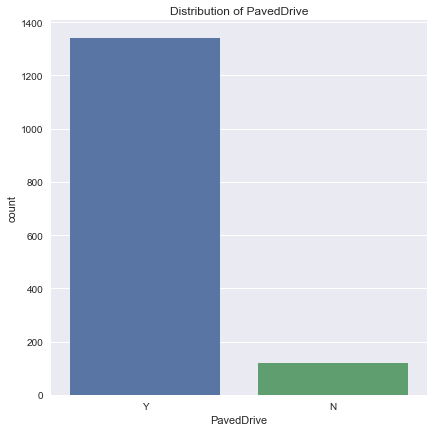

PavedDrive
N     120
Y    1340
Name: PavedDrive, dtype: int64


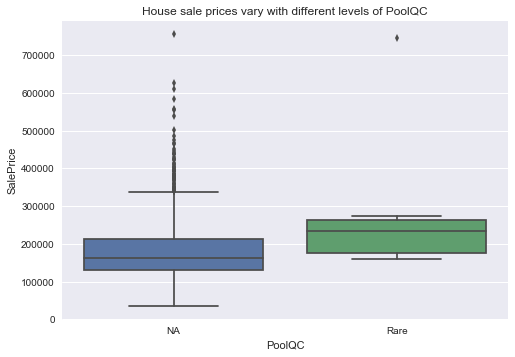

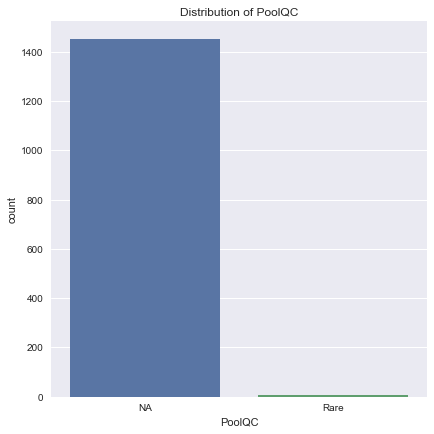

PoolQC
NA      1453
Rare       7
Name: PoolQC, dtype: int64


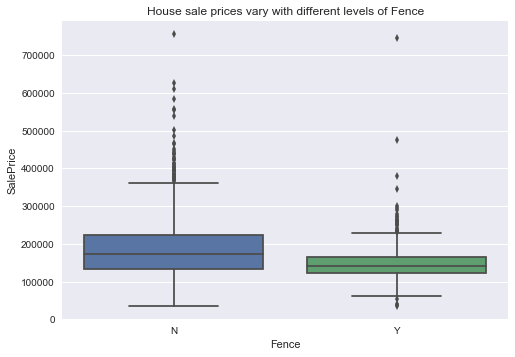

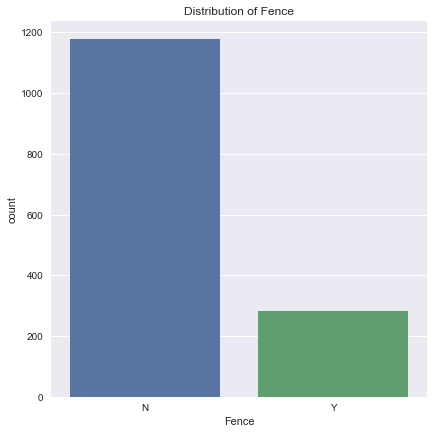

Fence
N    1179
Y     281
Name: Fence, dtype: int64


In [53]:
# Check distribution after Step 2 conversion
for var in ordinal_features:
    grid = sns.boxplot(x=var,y='SalePrice',data=train_data_clean)
    plt.title('House sale prices vary with different levels of %s' % var)
    plt.show()
    g = sns.factorplot(x=var,data=train_data_clean,kind='count',size=6,aspect=1)
    plt.title('Distribution of %s' % var)
    plt.show()
    print train_data_clean[var].groupby(train_data_clean[var]).count()

In [54]:
# Calculate ANOVA test and generate a F,p value table for every ordinal feature (desecending order by p-value)
F_list,p_list = anova_calculator(train_data_clean,ordinal_features,'SalePrice')
anova_ordinal = pd.DataFrame({'Feature':ordinal_features,'F-value':F_list,'p-value':p_list})
anova_ordinal.sort_values(ascending=False,by='p-value')
# 'Utilities', 'Street', 'ExterCond', and 'LandSlope' will be removed since we cannot reject null hypothesis. 
# And We will remove 'PoolQC' also since extremly unbalanced distribution. 

F-value       Feature        p-value
3     0.298804     Utilities   5.847168e-01
0     2.459290        Street   1.170486e-01
8     3.404940     ExterCond   6.520415e-02
4     3.819531     LandSlope   5.084934e-02
24   12.916430        PoolQC   3.365524e-04
18   20.047358    Functional   8.143129e-06
1    22.623543         Alley   2.165713e-06
13   14.622794  BsmtFinType2   5.155815e-07
25   44.546462         Fence   3.519164e-11
10   38.567401      BsmtCond   4.772081e-17
23   82.915376    PavedDrive   2.741414e-19
16   46.050442    Electrical   4.047816e-20
15   98.305344    CentralAir   1.809506e-22
2   112.525263      LotShape   2.244374e-25
21   62.593032    GarageQual   8.339781e-27
22   63.672512    GarageCond   3.088376e-27
6    48.370682   OverallCond   3.092954e-38
11   64.301816  BsmtExposure   4.103076e-50
14  117.831521     HeatingQC   2.571331e-68
12   64.688200  BsmtFinType1   2.386358e-71
19  171.990178   FireplaceQu   1.938292e-95
20  213.867028  GarageFinish  6.228747e-115
17  407.806352   KitchenQual  3.032213e-192
9   421.487545      BsmtQual  4.778224e-197
7   652.889258     ExterQual  3.628033e-203
5   573.706068   OverallQual  3.462840e-297

In [55]:
# Calculate effect size
def effect_size(df,features,response):
    SSB=[]
    SST=[]
    N = float(df.shape[0])
    for var in features:
        n = df.groupby(var).size().astype(float)
        total_squared = (df[response].sum())**2/N
        SSB_val = sum(((df.groupby(var).sum()[response])**2).divide(n))-total_squared
        SSB.append(SSB_val)
        sum_y_squared = sum([value**2 for value in df[response].values])
        SST_val = sum_y_squared - total_squared
        SST.append(SST_val)
    return SSB,SST
        

In [56]:
# Stats Table shows the SSB,SST,SSE and Effect Size of each independent variable. 
SSB,SST = effect_size(train_data_clean,ordinal_features,'SalePrice')
stat_ordinal = pd.DataFrame({'Ordinal':ordinal_features,'SSBetween':SSB,'SSTotal':SST})
stat_ordinal['SSError']=stat_ordinal['SSTotal']-stat_ordinal['SSBetween']
stat_ordinal['EffectSize']=stat_ordinal['SSBetween']/stat_ordinal['SSTotal'].astype(float)
stat_ordinal.sort_values(by='EffectSize',ascending=False)
# The 4 most important ordinal features are 'OverallQual','ExterQual','BsmtQual','KitchenQual' with 
# above or around 50% explained variance

Ordinal     SSBetween       SSTotal       SSError  EffectSize
5    OverallQual  5.635074e+12  9.207911e+12  3.572837e+12    0.611982
7      ExterQual  4.351957e+12  9.207911e+12  4.855955e+12    0.472632
9       BsmtQual  4.279809e+12  9.207911e+12  4.928103e+12    0.464797
17   KitchenQual  4.204320e+12  9.207911e+12  5.003592e+12    0.456599
20  GarageFinish  2.816458e+12  9.207911e+12  6.391453e+12    0.305874
19   FireplaceQu  2.409271e+12  9.207911e+12  6.798641e+12    0.261652
12  BsmtFinType1  1.941124e+12  9.207911e+12  7.266788e+12    0.210810
14     HeatingQC  1.798815e+12  9.207911e+12  7.409096e+12    0.195355
11  BsmtExposure  1.383210e+12  9.207911e+12  7.824702e+12    0.150220
6    OverallCond  1.080734e+12  9.207911e+12  8.127177e+12    0.117370
22    GarageCond  7.401050e+11  9.207911e+12  8.467806e+12    0.080377
21    GarageQual  7.285503e+11  9.207911e+12  8.479361e+12    0.079122
2       LotShape  6.597300e+11  9.207911e+12  8.548181e+12    0.071648
15    CentralAir  5.816255e+11  9.207911e+12  8.626286e+12    0.063166
16    Electrical  5.474510e+11  9.207911e+12  8.660460e+12    0.059454
23    PavedDrive  4.954701e+11  9.207911e+12  8.712441e+12    0.053809
10      BsmtCond  4.629648e+11  9.207911e+12  8.744947e+12    0.050279
25         Fence  2.729898e+11  9.207911e+12  8.934922e+12    0.029647
13  BsmtFinType2  1.811886e+11  9.207911e+12  9.026723e+12    0.019677
1          Alley  1.406945e+11  9.207911e+12  9.067217e+12    0.015280
18    Functional  1.248906e+11  9.207911e+12  9.083021e+12    0.013563
24        PoolQC  8.085663e+10  9.207911e+12  9.127055e+12    0.008781
4      LandSlope  2.405899e+10  9.207911e+12  9.183852e+12    0.002613
8      ExterCond  2.145359e+10  9.207911e+12  9.186458e+12    0.002330
0         Street  1.550534e+10  9.207911e+12  9.192406e+12    0.001684
3      Utilities  1.886693e+09  9.207911e+12  9.206025e+12    0.000205

In [57]:
discarded_features = discarded_features+['Street','Utilities','PoolQC','LandSlope','ExterCond','Functional','Alley','BsmtFinType2','Fence']
discarded_features

['LandContour',
 'Condition2',
 'MiscFeature',
 'Heating',
 'RoofMatl',
 'Street',
 'Utilities',
 'PoolQC',
 'LandSlope',
 'ExterCond',
 'Functional',
 'Alley',
 'BsmtFinType2',
 'Fence']

Feature Engineering -- Numeric Features

In [58]:
print 'Number of numeric features(continuous):',len(numeric_features)
print 'Number of numeric features(discrete):',len(numeric_discrete_features)

Number of numeric features(continuous): 22
Number of numeric features(discrete): 10


In [59]:
# Check all numeric features are of float or int type
all_numeric_features = numeric_features+numeric_discrete_features
train_data_clean[all_numeric_features].dtypes

LotFrontage      float64
LotArea            int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
YrSold             int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars       float64
MoSold             int64
dtype: object

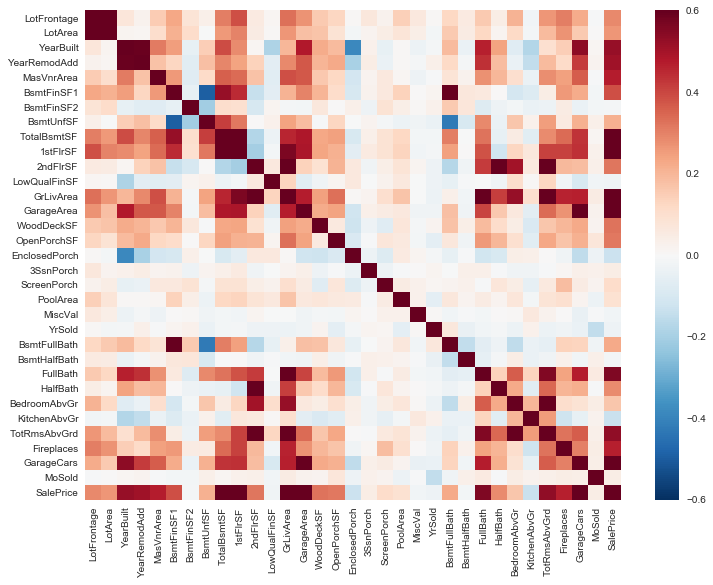

In [60]:
# Visualize Correlation Matrix to get a rough idea of the importance of each numeric features
all_numeric_features.append('SalePrice')
corrmat = train_data_clean[all_numeric_features].corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.6)
# From the heatmap, the most important numeric features are:

In [61]:
## Pearson's r shows the correlation with 'SalePrice' in a descending order
corrmat['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
LotFrontage      0.286676
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

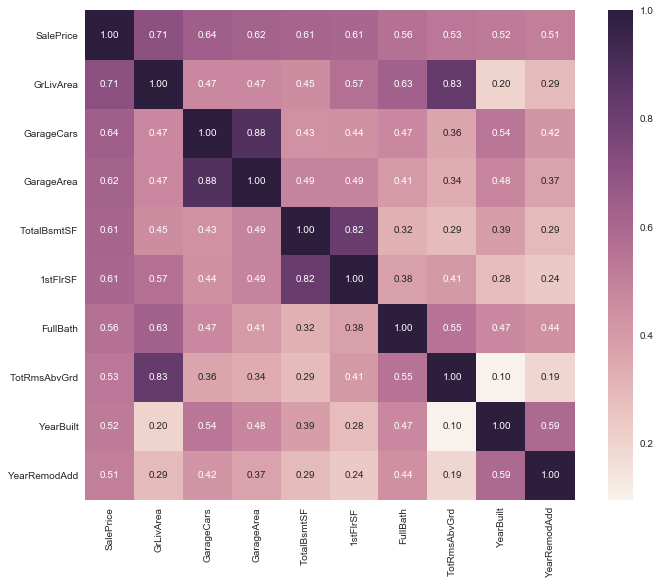

In [62]:
# get the top N factors correlate with SalePrice the most
k = 10
corr = corrmat.nlargest(k,'SalePrice')
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr[corr['SalePrice'].index],cbar=True,annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
# The most important numeric features are: GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbrGrd,
# YearBuilt, YearRemodAdd

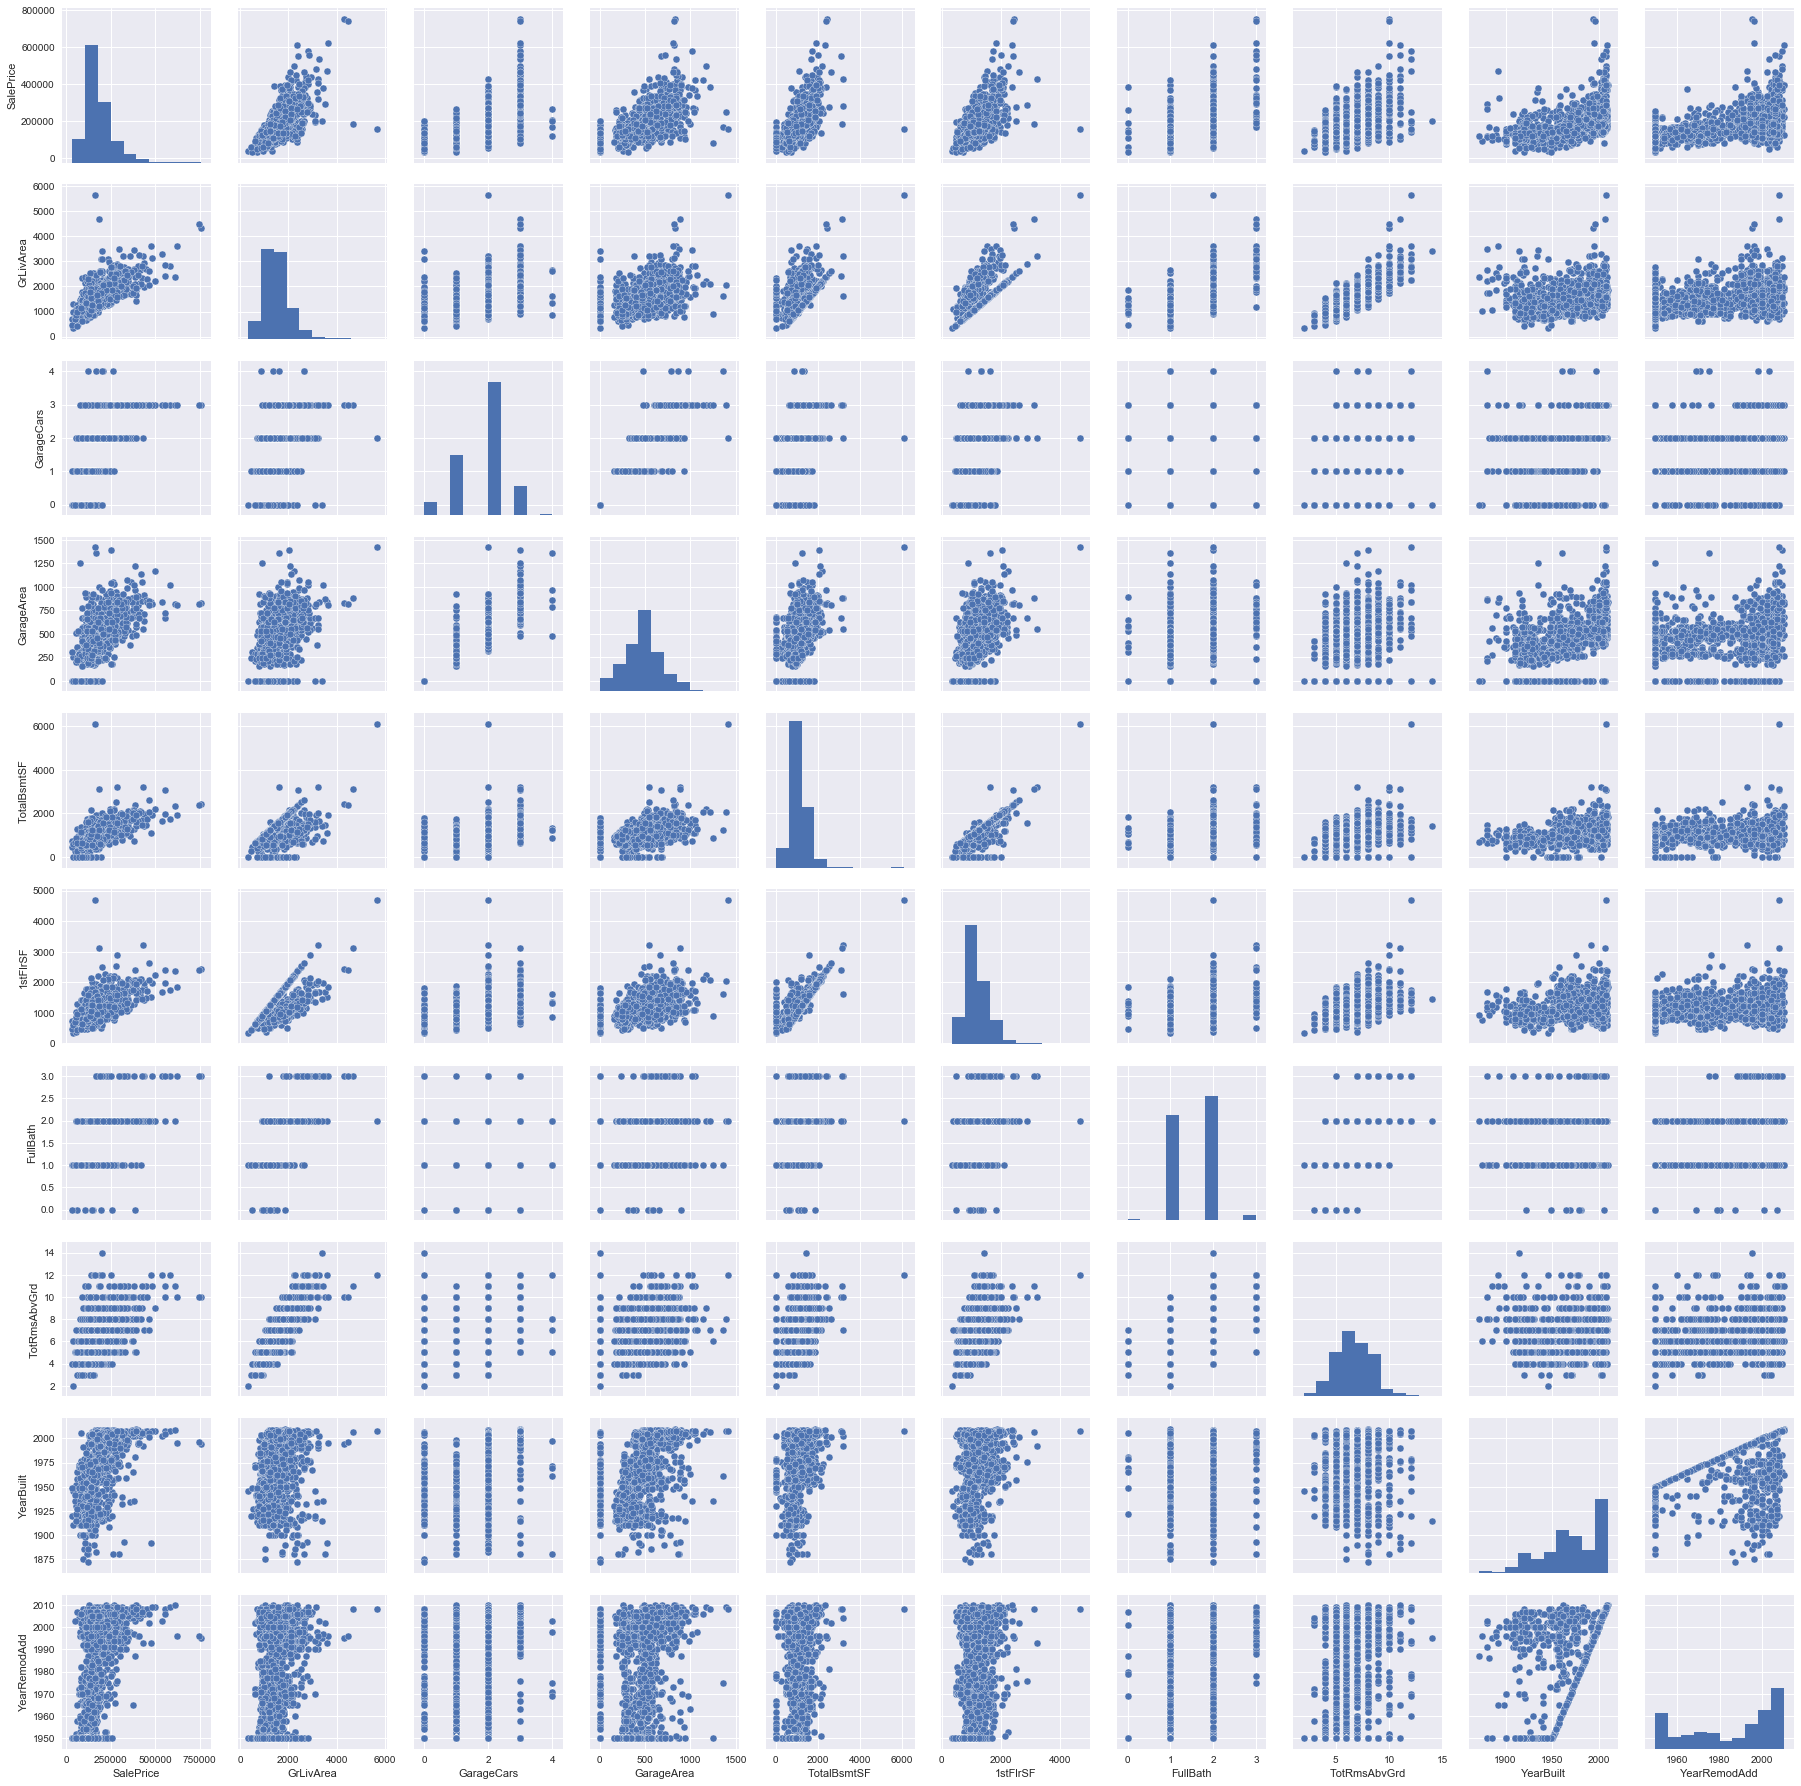

In [63]:
sns.pairplot(train_data_clean[corr['SalePrice'].index])
# The pairplots show the interaction between any pair of parameters. It is found that in some plots there are some 
# limiting lines that confine the scatter points in a certain region of the plot. For example, pairplot between 
# GrLivArea and FirstFlrSF, YearBuilt and YearRemodAdd, and etc. This is due to the fact that YearBuilt is always 
# earlier or at the time as YearRemodAdd, which forms the boundary-like limiting line. Other pairs with limiting lines
# follows the same argument. 


Repeat missing imputation and feature engineering for test set

In [64]:
missing_total = test_data_raw.isnull().sum().sort_values(ascending=False)
missing_percentage = (test_data_raw.isnull().sum()/test_data_raw.isnull().count()).sort_values(ascending=False)
missing_data = pd.DataFrame(missing_total,columns=['Total'])
missing_data['Percentage']=missing_percentage
missing_data.head(35)

Total  Percentage
PoolQC         1456    0.997944
MiscFeature    1408    0.965045
Alley          1352    0.926662
Fence          1169    0.801234
FireplaceQu     730    0.500343
LotFrontage     227    0.155586
GarageFinish     78    0.053461
GarageQual       78    0.053461
GarageCond       78    0.053461
GarageYrBlt      78    0.053461
GarageType       76    0.052090
BsmtCond         45    0.030843
BsmtExposure     44    0.030158
BsmtQual         44    0.030158
BsmtFinType1     42    0.028787
BsmtFinType2     42    0.028787
MasVnrType       16    0.010966
MasVnrArea       15    0.010281
MSZoning          4    0.002742
Functional        2    0.001371
Utilities         2    0.001371
BsmtHalfBath      2    0.001371
BsmtFullBath      2    0.001371
Exterior2nd       1    0.000685
Exterior1st       1    0.000685
KitchenQual       1    0.000685
TotalBsmtSF       1    0.000685
GarageArea        1    0.000685
BsmtUnfSF         1    0.000685
BsmtFinSF2        1    0.000685
GarageCars        1    0.000685
BsmtFinSF1        1    0.000685
SaleType          1    0.000685
YearRemodAdd      0    0.000000
RoofMatl          0    0.000000

In [65]:
def fill_most_frequent(df,feature):
    most_frequent = df.dropna(subset=[feature])[feature].value_counts().idxmax()
    return most_frequent

In [66]:
test_data_clean=test_data_raw.copy()
test_data_clean[['GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','BsmtUnfSF']]=test_data_clean[
    ['GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','BsmtUnfSF']].fillna(0)
test_data_clean['SaleType']=test_data_clean['SaleType'].fillna(fill_most_frequent(test_data_clean,'SaleType'))
test_data_clean['KitchenQual']=test_data_clean['KitchenQual'].fillna(fill_most_frequent(test_data_clean,'KitchenQual'))
test_data_clean['Exterior1st']=test_data_clean['Exterior1st'].fillna(fill_most_frequent(test_data_clean,'Exterior1st'))
test_data_clean['Exterior2nd']=test_data_clean['Exterior2nd'].fillna(fill_most_frequent(test_data_clean,'Exterior2nd'))

In [67]:
fill_0 = ['GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','BsmtUnfSF','BsmtFullBath','BsmtHalfBath',
          'MasVnrArea']
frequent = ['SaleType','KitchenQual','Exterior1st','Exterior2nd','Utilities','Functional','MSZoning']
fill_none = ['MasVnrType']
fill_na = ['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType1','BsmtFinType2','GarageFinish','GarageQual','GarageCond',
          'GarageType','FireplaceQu','Fence','Alley','MiscFeature','PoolQC']

In [68]:
test_data_clean[fill_0]=test_data_clean[fill_0].fillna(0)
test_data_clean[fill_none]=test_data_clean[fill_none].fillna('None')
test_data_clean[fill_na]=test_data_clean[fill_na].fillna('NA')
for var in frequent:
    test_data_clean[var]=test_data_clean[var].fillna(fill_most_frequent(test_data_clean,var))

In [69]:
test_data_clean['LotFrontage'].fillna(np.sqrt(test_data_clean['LotArea']),inplace=True)

In [70]:
year_bins =[0,1950,1965,1980,1995,2010]
year_names = ['before 1950','1950-1965','1965-1980','1980-1995','1995-2010']
test_data_clean['BltGarageYrRange']=pd.cut(test_data_clean['GarageYrBlt'],bins=year_bins,labels=year_names)
test_data_clean['BltYearRange']=pd.cut(test_data_clean['YearBuilt'],bins=year_bins,labels=year_names)
test_data_clean['YearRemodAddRange']=pd.cut(test_data_clean['YearRemodAdd'],bins=year_bins,labels=year_names)
del test_data_clean['GarageYrBlt']

## There is a entry in test set, its 'GarageYrBlt' is 2207 which will be treated as NA


In [71]:
# Preliminary conversion(nominal features)
for key in pre_nominal_conversion:
    test_data_clean[key]=test_data_clean[key].map(pre_nominal_conversion[key])
    

In [72]:
# Perform 'combine_rare_levels' to all the nominal_features
for var in nominal_features:
    test_data_clean[var]=test_data_clean[var].map(nominal_lookup[var])


In [73]:
# Preliminary conversion(ordinary features)
for key in pre_ordinal_conversion:
    test_data_clean[key]=test_data_clean[key].map(pre_ordinal_conversion[key])

In [74]:
# Perform 'combine_rare_levels' to all the ordinal_features
for var in ordinal_features:
    test_data_clean[var]=test_data_clean[var].map(ordinal_lookup[var])

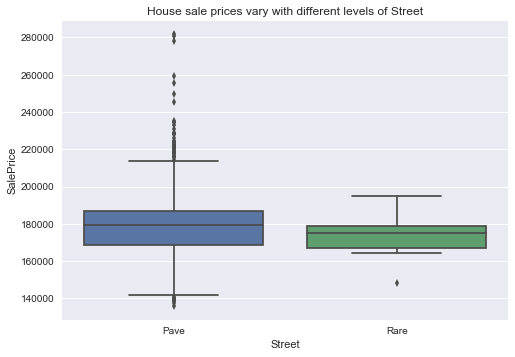

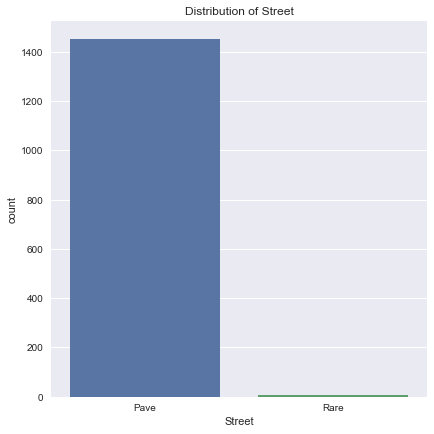

Street
Pave    1453
Rare       6
Name: Street, dtype: int64


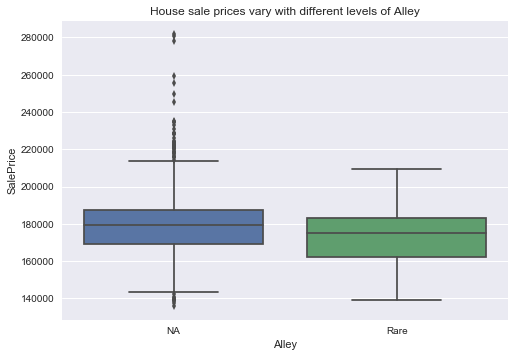

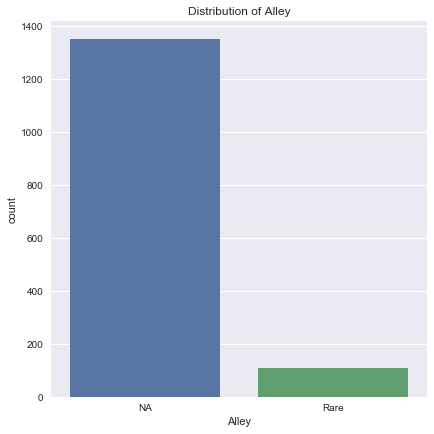

Alley
NA      1352
Rare     107
Name: Alley, dtype: int64


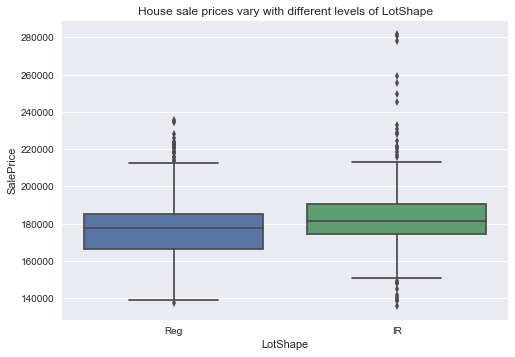

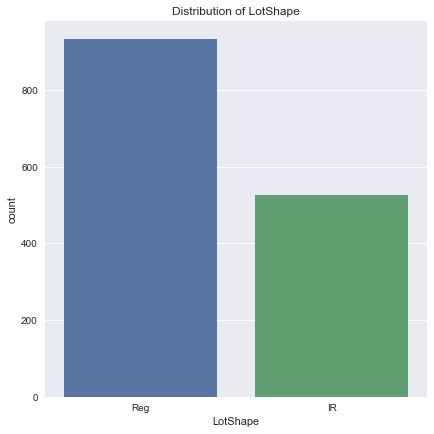

LotShape
IR     525
Reg    934
Name: LotShape, dtype: int64


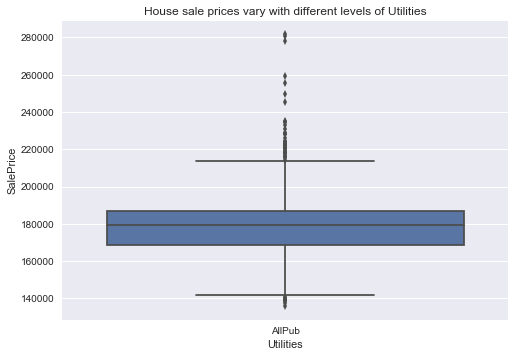

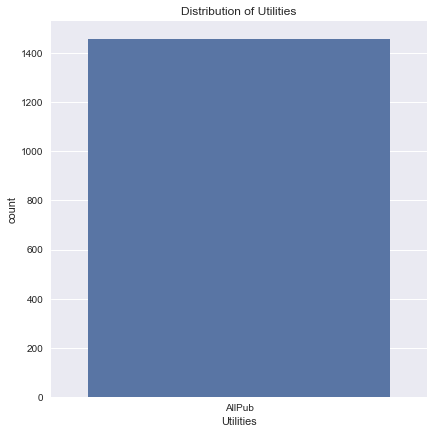

Utilities
AllPub    1459
Name: Utilities, dtype: int64


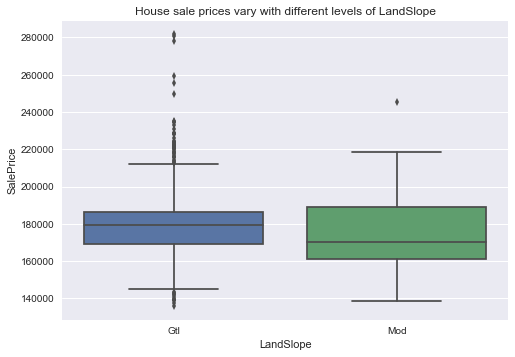

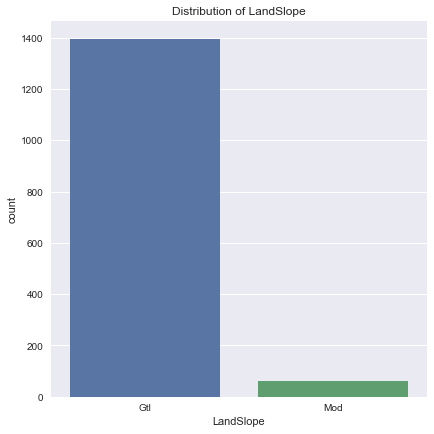

LandSlope
Gtl    1396
Mod      63
Name: LandSlope, dtype: int64


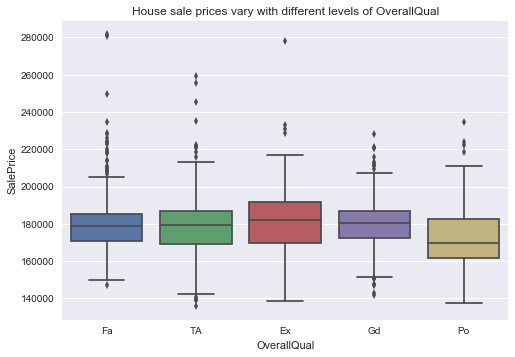

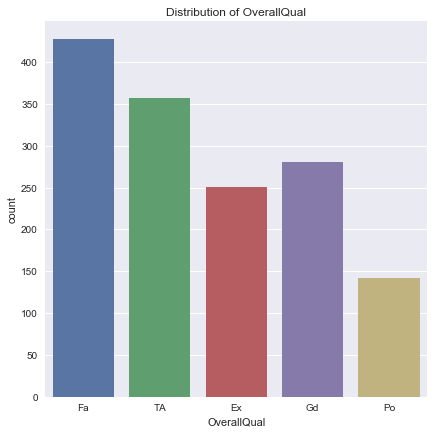

OverallQual
Ex    251
Fa    428
Gd    281
Po    142
TA    357
Name: OverallQual, dtype: int64


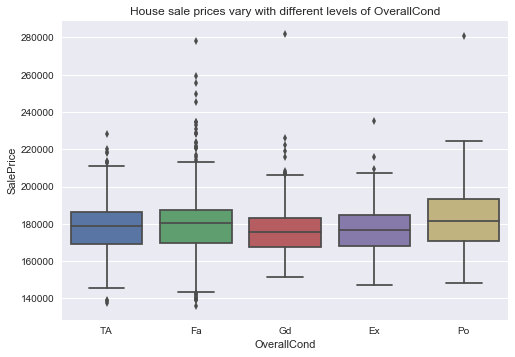

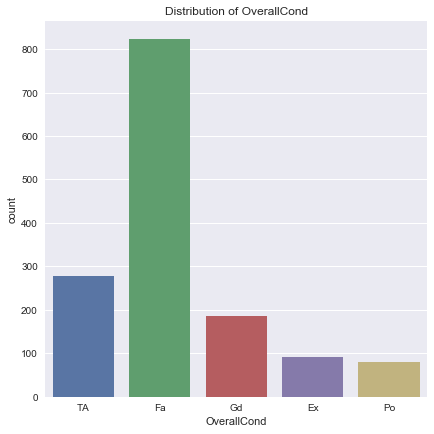

OverallCond
Ex     91
Fa    824
Gd    185
Po     80
TA    279
Name: OverallCond, dtype: int64


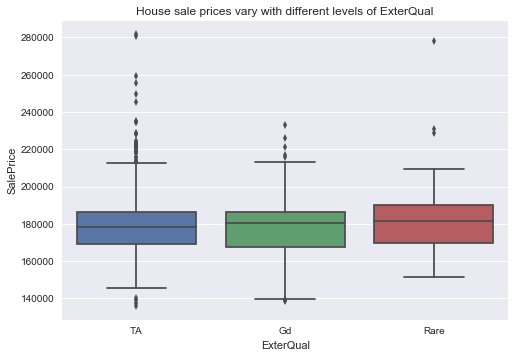

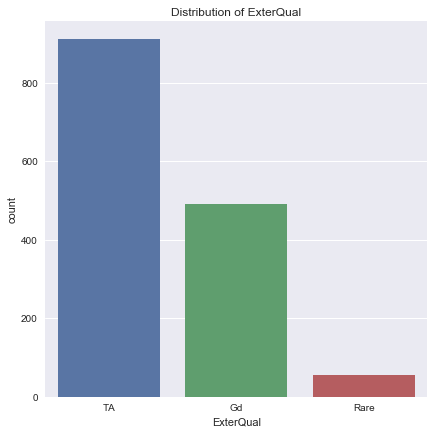

ExterQual
Gd      491
Rare     55
TA      913
Name: ExterQual, dtype: int64


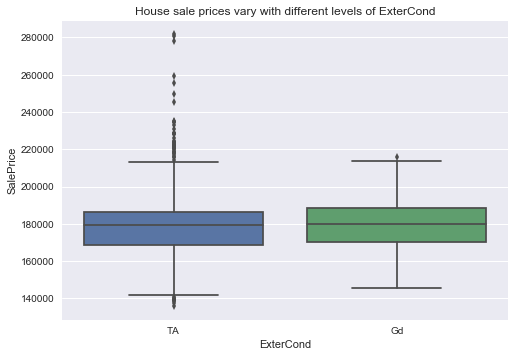

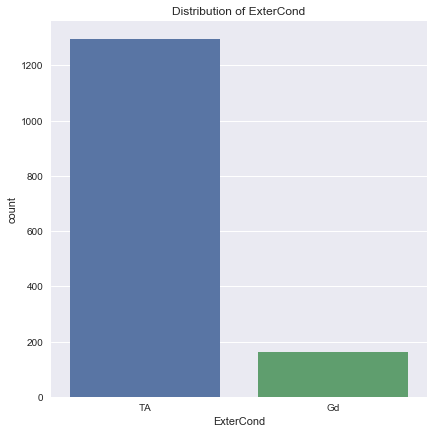

ExterCond
Gd     162
TA    1297
Name: ExterCond, dtype: int64


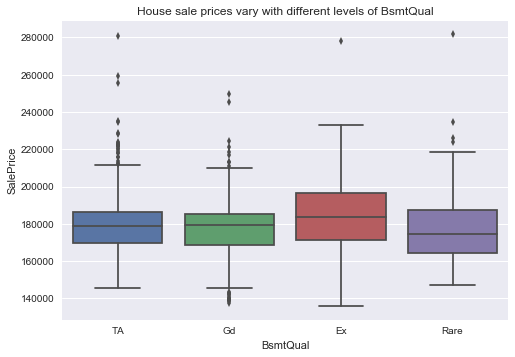

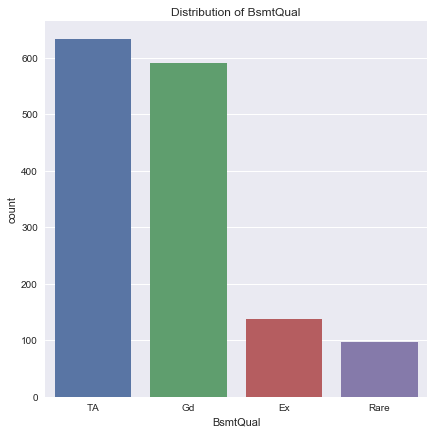

BsmtQual
Ex      137
Gd      591
Rare     97
TA      634
Name: BsmtQual, dtype: int64


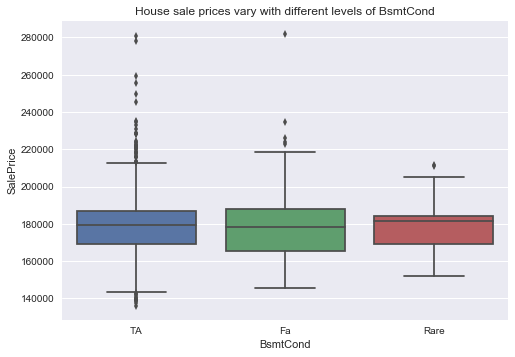

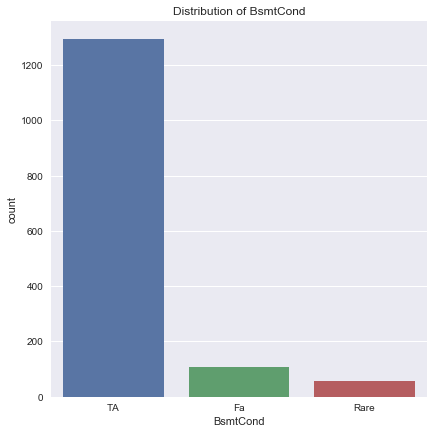

BsmtCond
Fa       107
Rare      57
TA      1295
Name: BsmtCond, dtype: int64


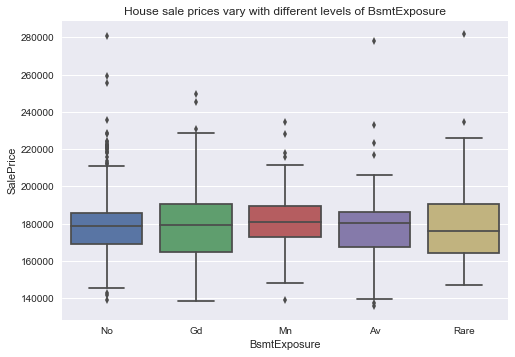

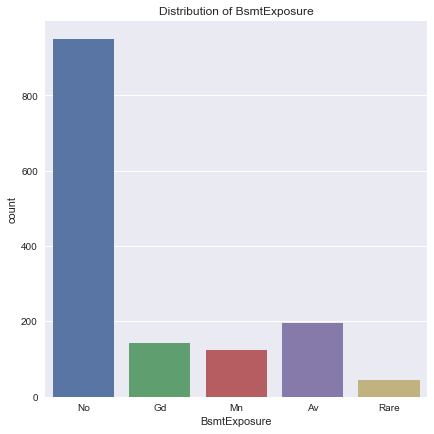

BsmtExposure
Av      197
Gd      142
Mn      125
No      951
Rare     44
Name: BsmtExposure, dtype: int64


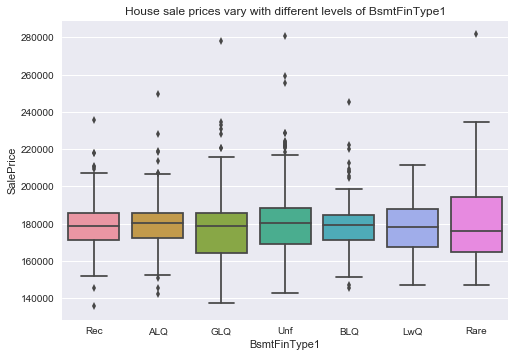

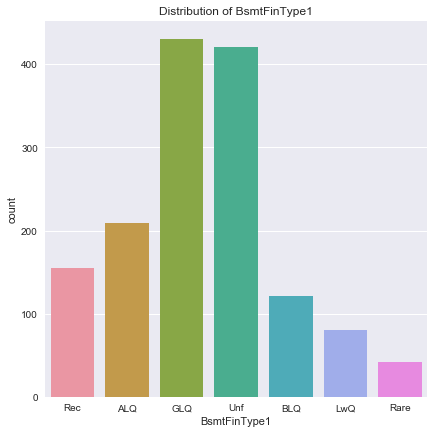

BsmtFinType1
ALQ     209
BLQ     121
GLQ     431
LwQ      80
Rare     42
Rec     155
Unf     421
Name: BsmtFinType1, dtype: int64


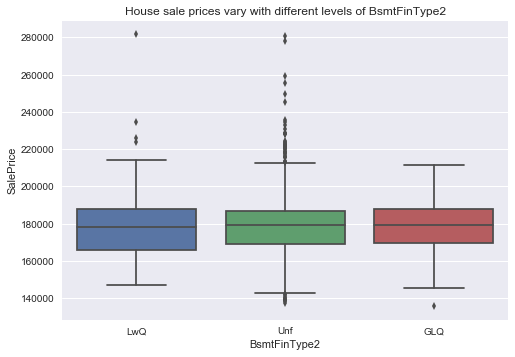

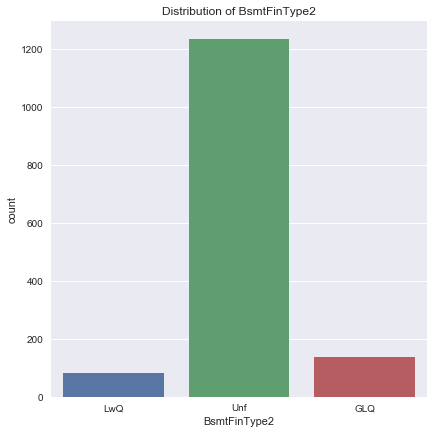

BsmtFinType2
GLQ     139
LwQ      83
Unf    1237
Name: BsmtFinType2, dtype: int64


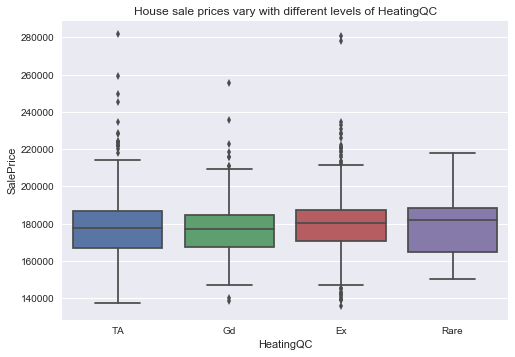

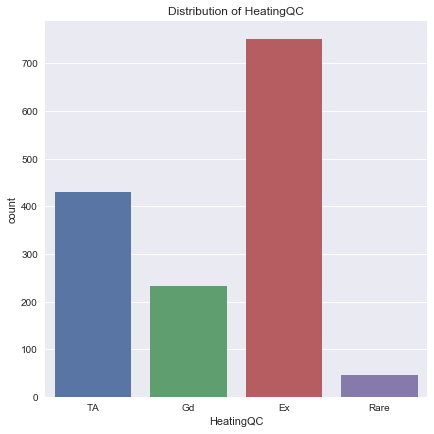

HeatingQC
Ex      752
Gd      233
Rare     45
TA      429
Name: HeatingQC, dtype: int64


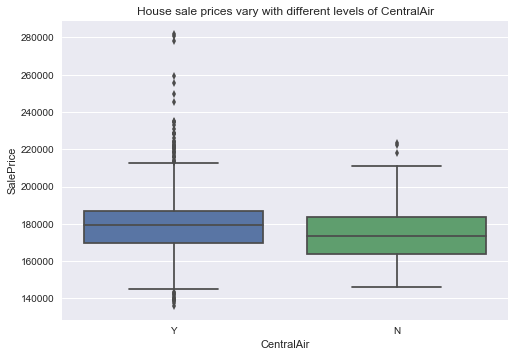

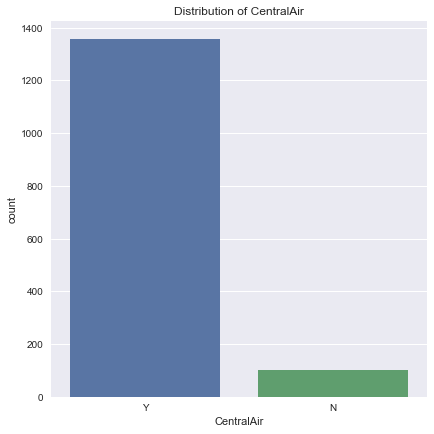

CentralAir
N     101
Y    1358
Name: CentralAir, dtype: int64


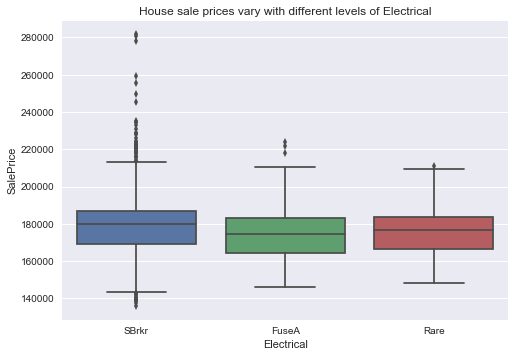

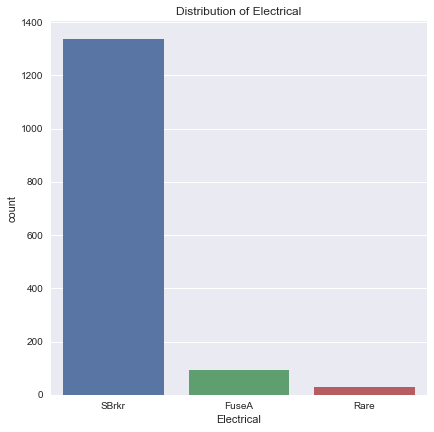

Electrical
FuseA      94
Rare       28
SBrkr    1337
Name: Electrical, dtype: int64


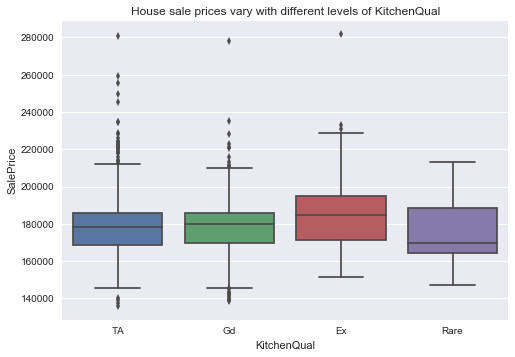

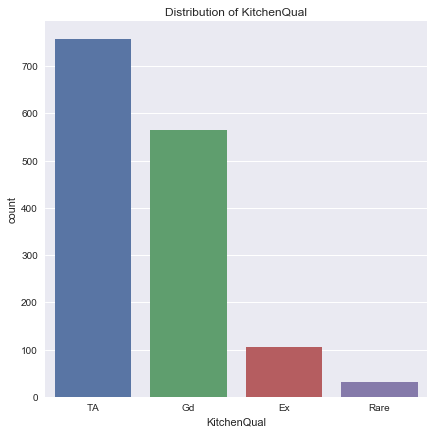

KitchenQual
Ex      105
Gd      565
Rare     31
TA      758
Name: KitchenQual, dtype: int64


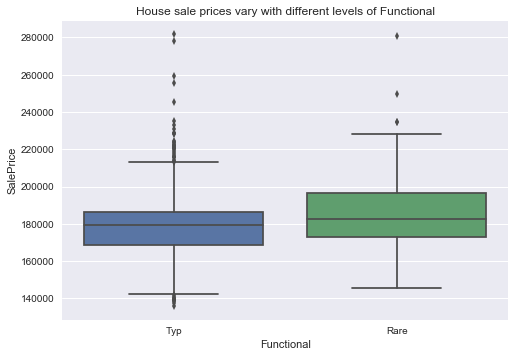

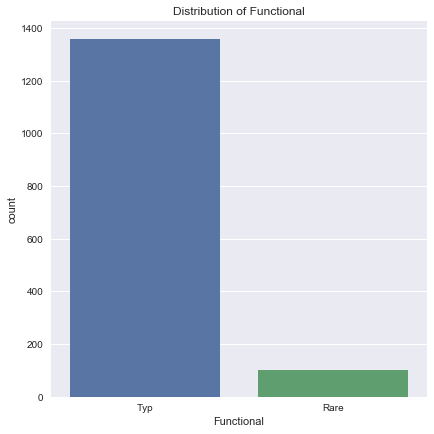

Functional
Rare     100
Typ     1359
Name: Functional, dtype: int64


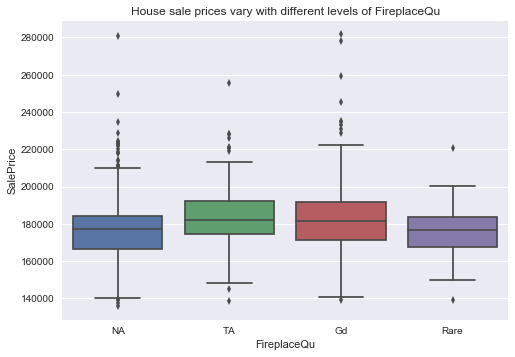

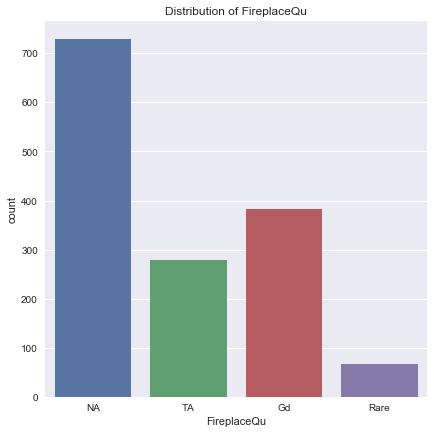

FireplaceQu
Gd      383
NA      730
Rare     67
TA      279
Name: FireplaceQu, dtype: int64


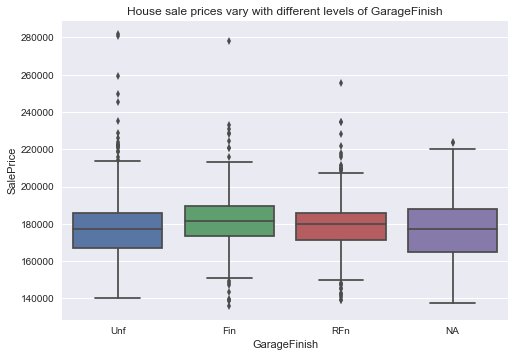

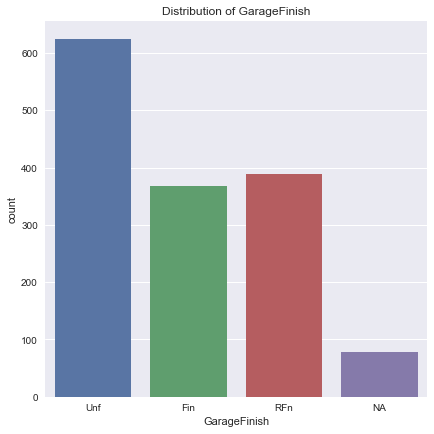

GarageFinish
Fin    367
NA      78
RFn    389
Unf    625
Name: GarageFinish, dtype: int64


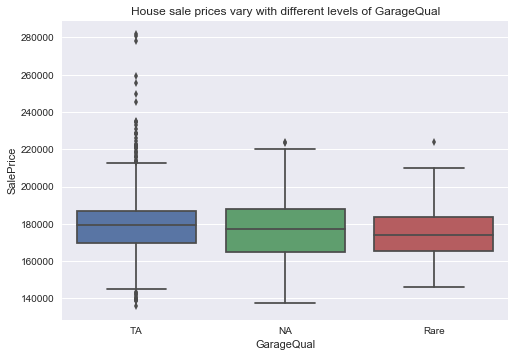

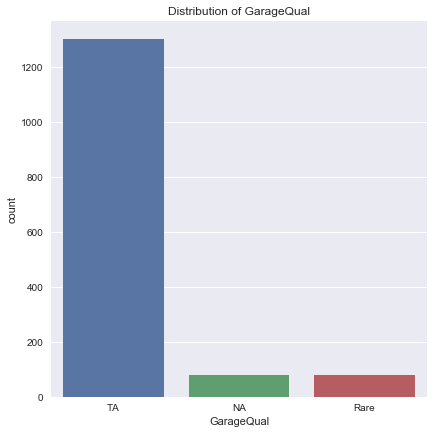

GarageQual
NA        78
Rare      78
TA      1303
Name: GarageQual, dtype: int64


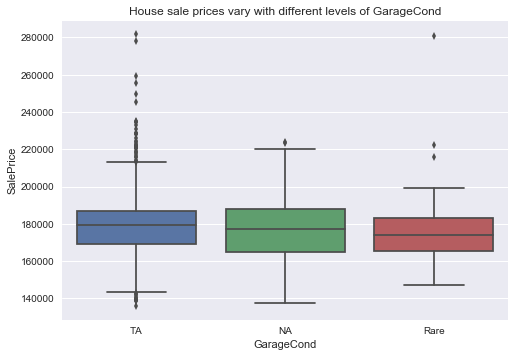

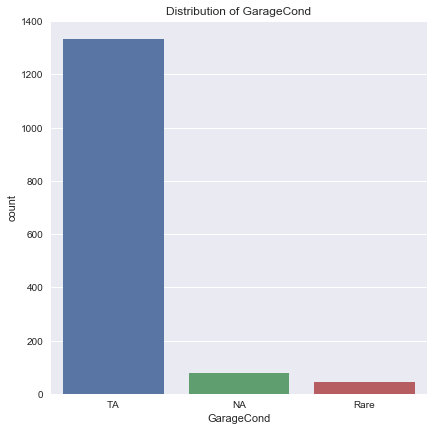

GarageCond
NA        78
Rare      46
TA      1335
Name: GarageCond, dtype: int64


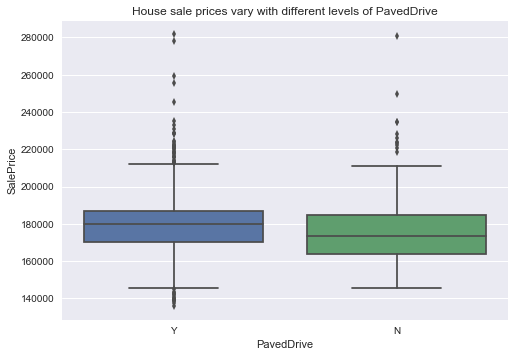

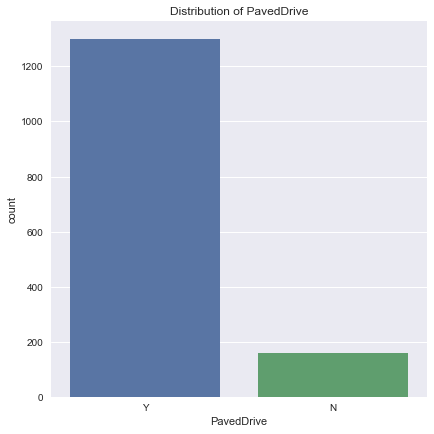

PavedDrive
N     158
Y    1301
Name: PavedDrive, dtype: int64


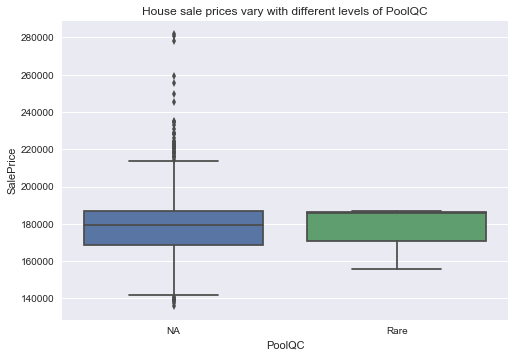

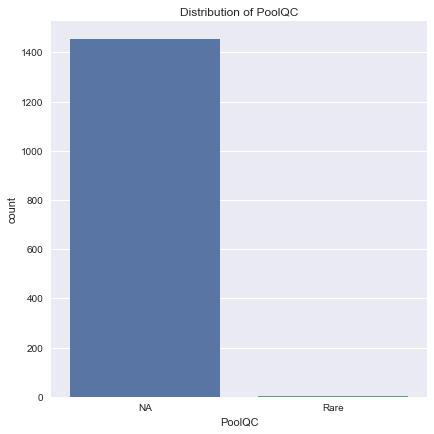

PoolQC
NA      1456
Rare       3
Name: PoolQC, dtype: int64


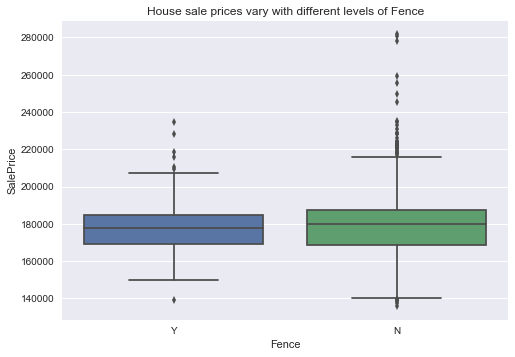

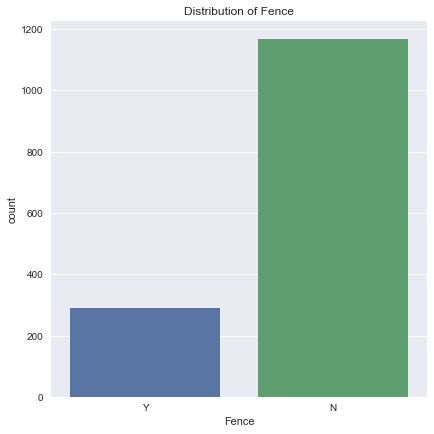

Fence
N    1169
Y     290
Name: Fence, dtype: int64


In [75]:
for var in ordinal_features:
    grid = sns.boxplot(x=var,y='SalePrice',data=test_data_clean)
    plt.title('House sale prices vary with different levels of %s' % var)
    plt.show()
    g = sns.factorplot(x=var,data=test_data_clean,kind='count',size=6,aspect=1)
    plt.title('Distribution of %s' % var)
    plt.show()
    print test_data_clean[var].groupby(test_data_clean[var]).count()

### 3 Data Exploration

##### 3.1 Univariate Analysis (SalePrice)

In [76]:
saleprice_scaled = (train_data_clean['SalePrice']-train_data_clean['SalePrice'].mean())/train_data_clean['SalePrice'].std(ddof=1)
low_range = saleprice_scaled.sort_values()[:10].values.reshape(-1,1)
high_range = saleprice_scaled.sort_values()[-10:].values.reshape(-1,1)
print 'out(low) bound of House Sale Price:\n',low_range
print 'out(high) bound of House Sale Price:\n',high_range

out(low) bound of House Sale Price:
[[-1.83807396]
 [-1.83290041]
 [-1.8003108 ]
 [-1.78268799]
 [-1.77387659]
 [-1.62282394]
 [-1.61653008]
 [-1.58506078]
 [-1.58506078]
 [-1.57256118]]
out(high) bound of House Sale Price:
[[ 3.82765891]
 [ 4.03959836]
 [ 4.49480808]
 [ 4.70879933]
 [ 4.72870051]
 [ 5.06041212]
 [ 5.42198179]
 [ 5.58993974]
 [ 7.10046617]
 [ 7.22634337]]


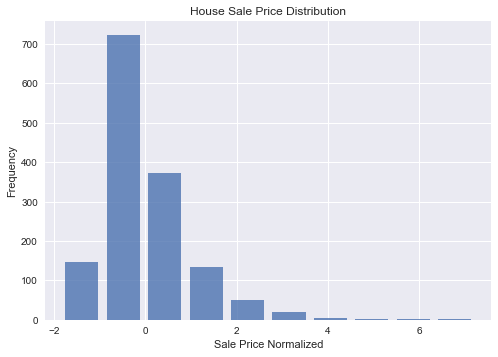

In [77]:
plt.hist(saleprice_scaled,bins=10,alpha=0.8,rwidth=0.8)
plt.title('House Sale Price Distribution')
plt.xlabel('Sale Price Normalized')
plt.ylabel('Frequency')

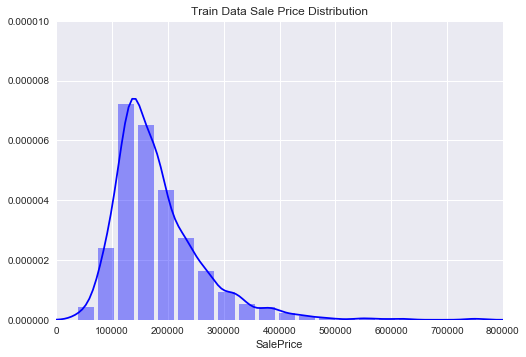

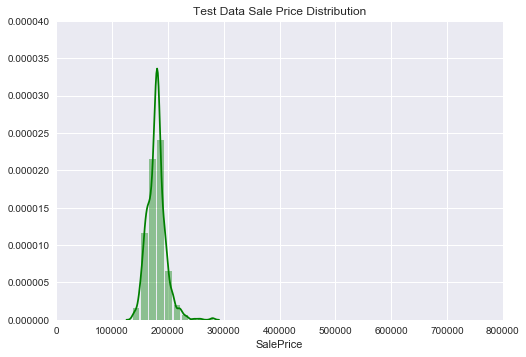

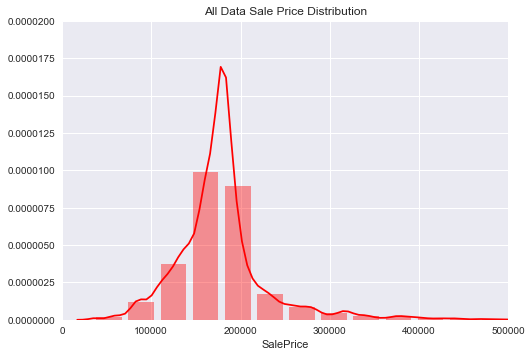

In [78]:
# Look at the distribution of SalePrice trainset, testset and total

sns.distplot(train_data_raw['SalePrice'],bins=20,hist_kws={'rwidth':0.8},color='b')
sns.plt.title('Train Data Sale Price Distribution')
plt.xlim(0,800000)
plt.ylim(0,0.00001)
plt.show()
sns.distplot(test_data_raw['SalePrice'],bins=10,hist_kws={'rwidth':0.8},color='g')
sns.plt.title('Test Data Sale Price Distribution')
plt.xlim(0,800000)
plt.ylim(0,0.00004)
plt.show()
sns.distplot(all_data_raw['SalePrice'],bins=20,hist_kws={'rwidth':0.8},color='r')
sns.plt.title('All Data Sale Price Distribution')
plt.xlim(0,500000)
plt.ylim(0,0.00002)
plt.show()
# Seems like the distribution of SalePrice train set has a positive skewness

In [79]:
# Check the skewness and kurtosis for SalePrice of train set 
print 'Skewness:', train_data_raw['SalePrice'].skew()
print 'Kurtosis:', train_data_raw['SalePrice'].kurt()

Skewness: 1.88287575977
Kurtosis: 6.53628186006


##### 3.2 Bivariate Analysis 

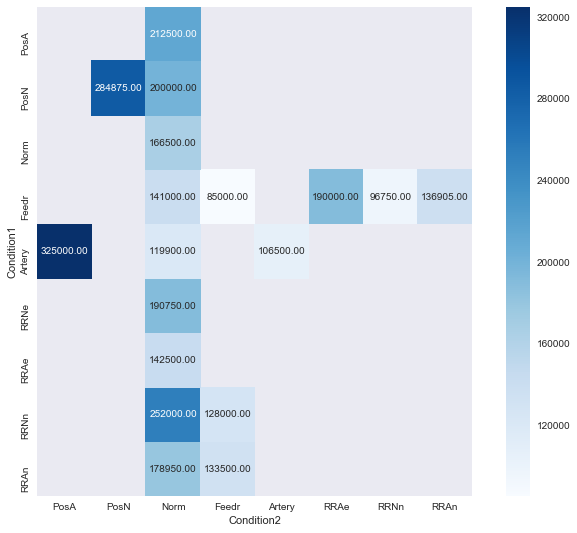

In [82]:
# Explore relationship between Condition and HousePrice
cond_order = ['PosA','PosN','Norm', 'Feedr', 'Artery', 'RRNe','RRAe', 'RRNn', 'RRAn']
price_cond1_cond2=train_data_raw[['Condition1','Condition2','SalePrice']].groupby(
    ['Condition1','Condition2']).median().reset_index()
price_cond=price_cond1_cond2.pivot(index='Condition1',columns='Condition2',values='SalePrice')
price_cond_ordered = price_cond[['PosA','PosN','Norm', 'Feedr', 'Artery', 'RRAe', 'RRNn', 'RRAn']]
price_cond_ordered = price_cond_ordered.reindex(index=cond_order)
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(price_cond_ordered,cbar=True,cmap='Blues',annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

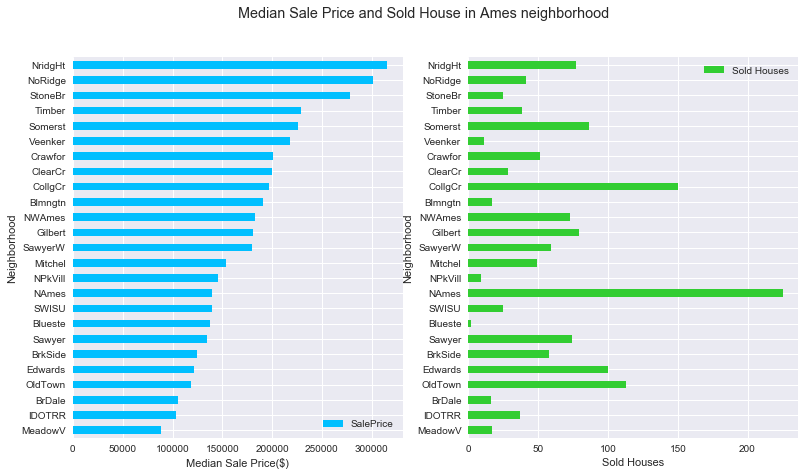

In [126]:
# Median Sale Price and Sold House in Ames neighborhood
fig,ax = plt.subplots(1,2,figsize=(13,7))
neighbor_price=train_data_raw[['Neighborhood','SalePrice']].groupby('Neighborhood').median().sort_values(by='SalePrice')
neighbor_price.plot(kind='barh',ax=ax[0],color='deepskyblue')
neighbor_order=neighbor_price.index
neighbor_houses=train_data_raw[['Neighborhood','SalePrice']].groupby('Neighborhood').count()
neighbor_houses=neighbor_houses.reindex(index=neighbor_order)
neighbor_houses.columns=['Sold Houses']
neighbor_houses.plot(kind='barh',ax=ax[1],color='limegreen')
ax[0].set_xlabel('Median Sale Price($)')
ax[1].set_xlabel('Sold Houses')
fig.suptitle('Median Sale Price and Sold House in Ames neighborhood')
plt.show()


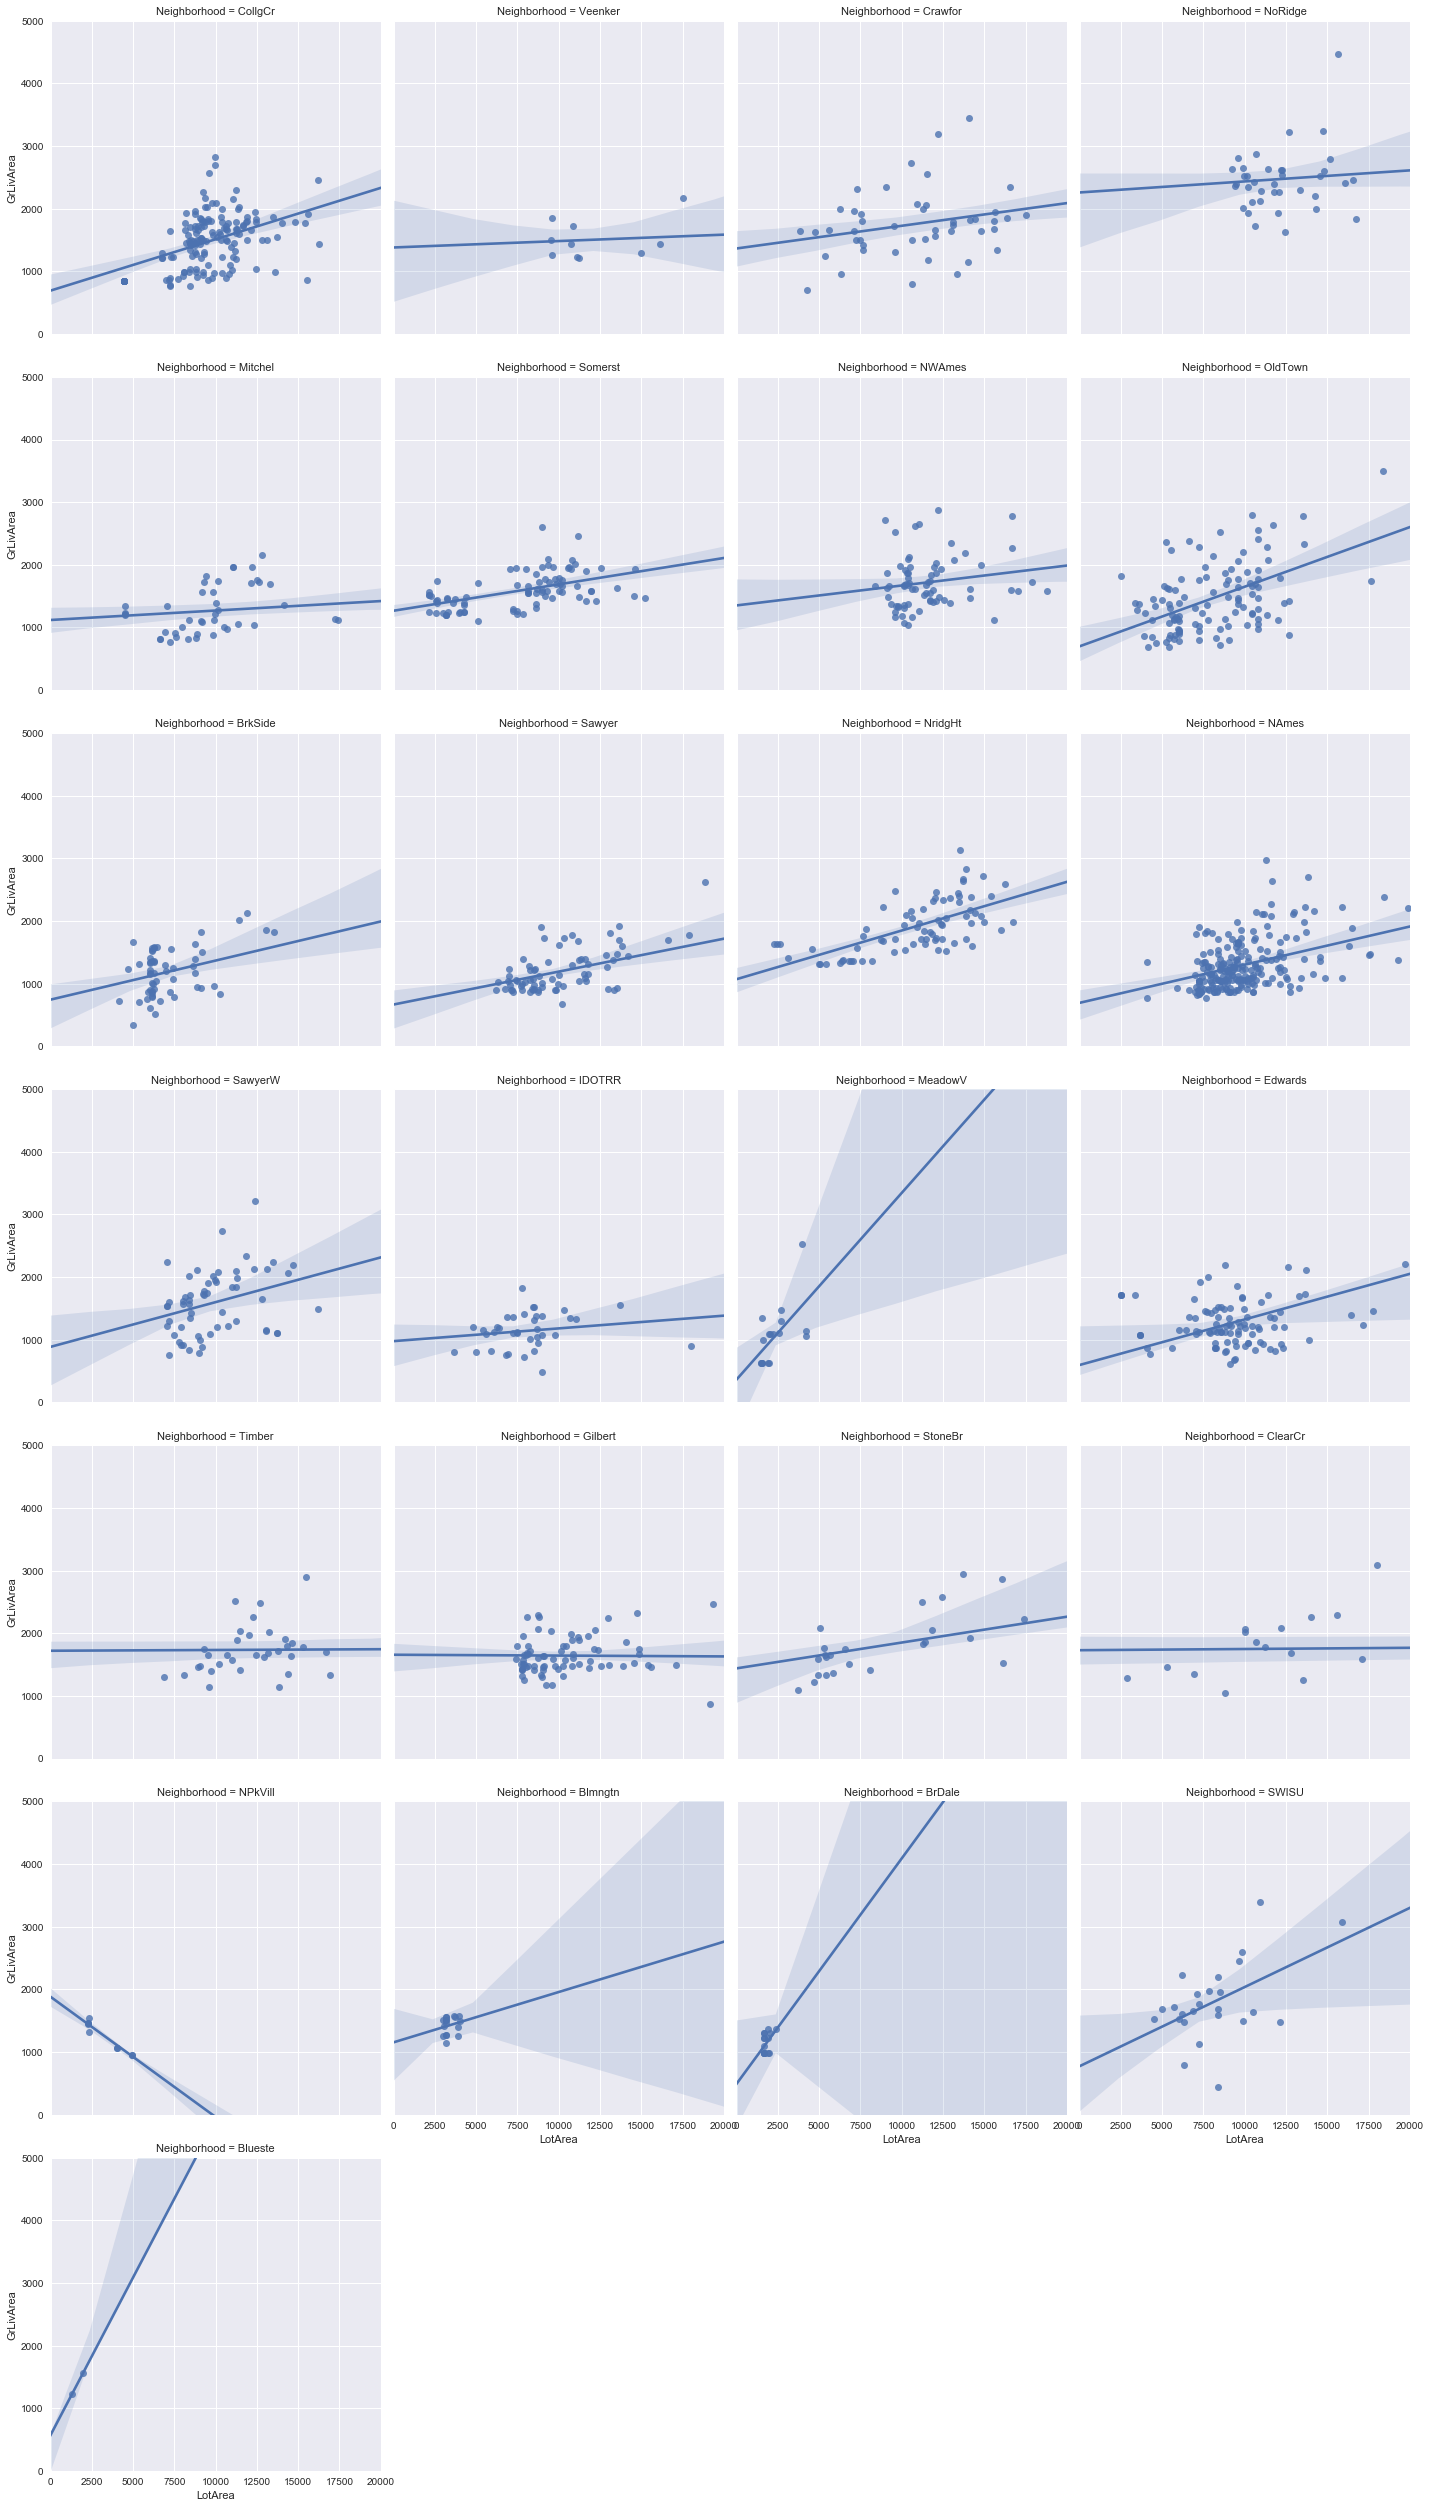

In [137]:
# Explore the relationship between LotArea and GrLivArea in the neighborhood
lm = sns.lmplot(data=train_data_raw,x='LotArea',y='GrLivArea',col='Neighborhood',col_wrap=4)
axes = lm.axes
axes[0].set_ylim(0,5000)
axes[0].set_xlim(0,20000)
plt.show()


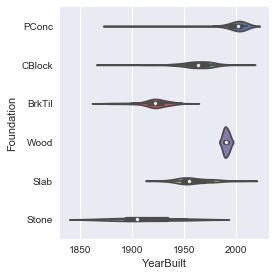

In [144]:
# Foundation could be related to the year when the house was built. New House tends to adopt PConc(poured concrete).
sns.factorplot(data=train_data_raw,x='YearBuilt',y='Foundation',kind='violin')

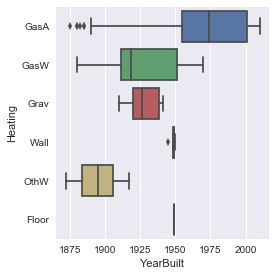

In [143]:
# Heating is also related to yearbuilt
sns.factorplot(data=train_data_raw,x='YearBuilt',y='Heating',kind='box')

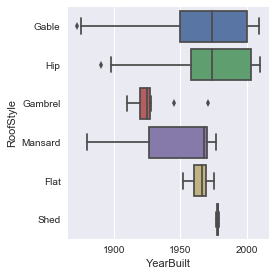

In [148]:
# RoofStyle
sns.factorplot(data=train_data_raw,x='YearBuilt',y='RoofStyle',kind='box')

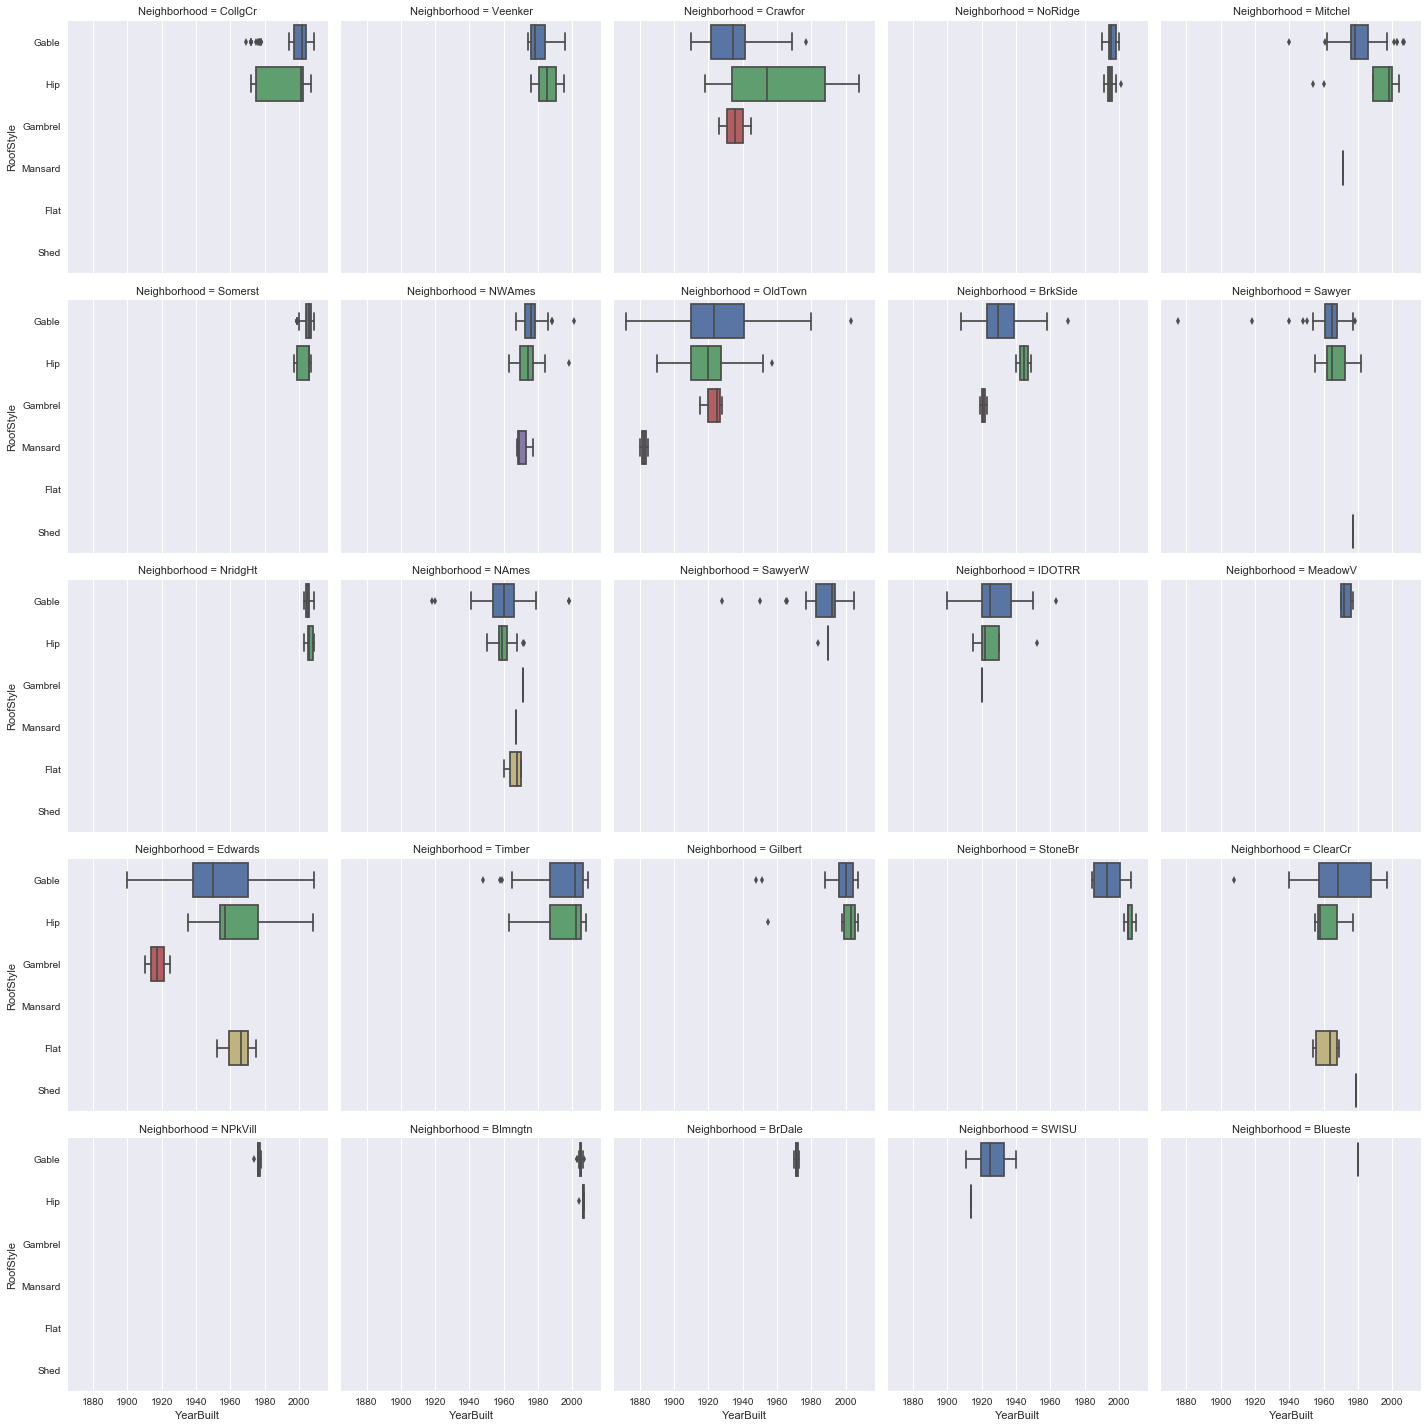

In [154]:
# RoofStyle in the neighborhood
sns.factorplot(data=train_data_raw,x='YearBuilt',y='RoofStyle',col='Neighborhood',col_wrap=5,kind='box')

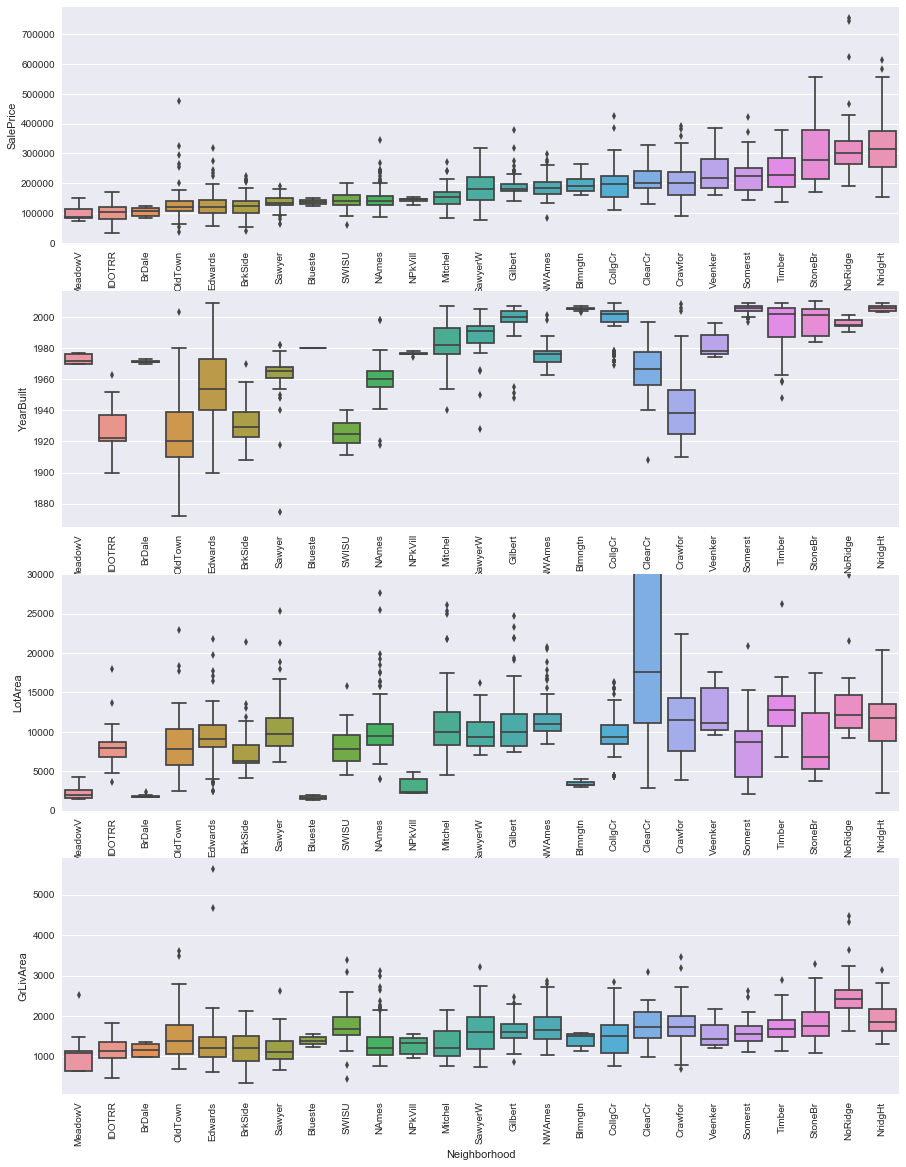

In [171]:
# Explore the SalePrice, Yearbuilt, LotArea and Ground Living Area of the houses in the neighborhood. 
fig,ax = plt.subplots(4,1,figsize=(15,20))
grid1 = sns.boxplot(x='Neighborhood',y='SalePrice',data=train_data_raw,order=neighbor_order,ax=ax[0])
grid2 = sns.boxplot(x='Neighborhood',y='YearBuilt',data=train_data_raw,order=neighbor_order,ax=ax[1])
grid3 = sns.boxplot(x='Neighborhood',y='LotArea',data=train_data_raw,order=neighbor_order,ax=ax[2])
grid4 = sns.boxplot(x='Neighborhood',y='GrLivArea',data=train_data_raw,order=neighbor_order,ax=ax[3])

ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=90)
ax[3].set_xticklabels(ax[3].get_xticklabels(),rotation=90)
ax[2].set_ylim(0,30000)
plt.show()

C:\Users\huang\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


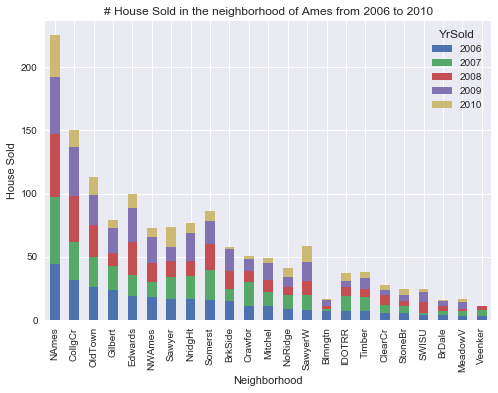

In [201]:
# Explore number of house sold from Year2006 to Year 2010
sold2006 = train_data_raw[train_data_raw['YrSold']==2006].groupby('Neighborhood').count()['SalePrice'].sort_values(
    ascending=False).index.values
train_data_raw['event']=1
ys_neighbor=train_data_raw[['event','YrSold','Neighborhood']].groupby(['YrSold','Neighborhood']).count().reset_index()
event_ys_neighbor=ys_neighbor.pivot(index='Neighborhood',columns='YrSold',values='event').reindex(sold2006)
event_ys_neighbor.plot(kind='bar',stacked=True)
plt.ylabel('House Sold')
plt.title('# House Sold in the neighborhood of Ames from 2006 to 2010')
plt.show()

##### 4.1 Log transformation and standardization

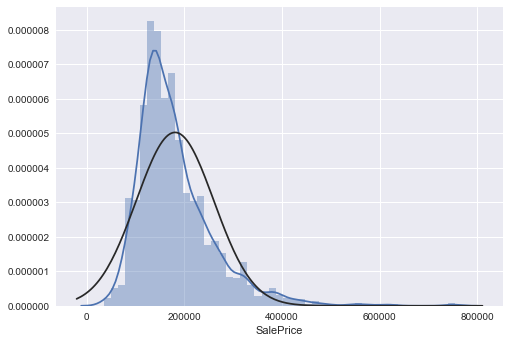

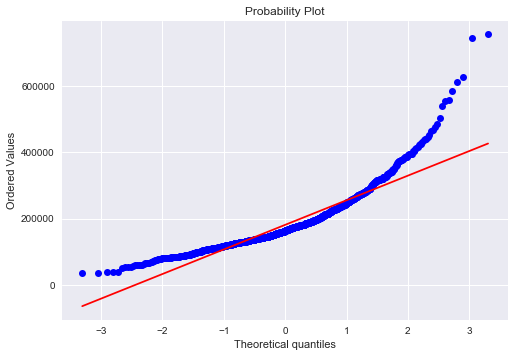

In [202]:
# Gaussian fitting of SalePrice and the residual plot
sns.distplot(train_data_clean['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data_clean['SalePrice'], plot=plt)

In [203]:
all_data_clean = pd.concat([train_data_clean,test_data_clean],join = 'inner',copy=True)

In [204]:
# Apply log transformation
all_data_clean['SalePrice']=np.log1p(all_data_clean['SalePrice'])


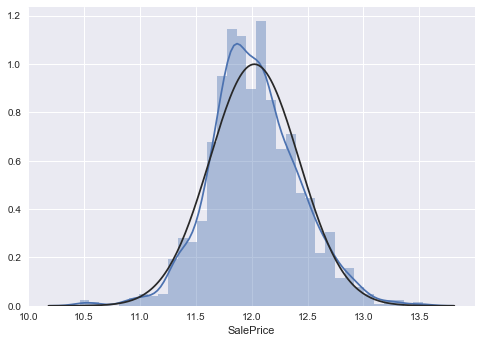

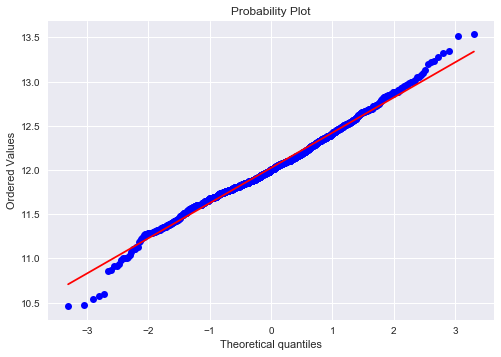

In [205]:
train_data_clean['SalePrice']=all_data_clean['SalePrice'][train_mask]
sns.distplot(train_data_clean['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data_clean['SalePrice'], plot=plt)

In [206]:
print 'Categorical Features:' + str(len(nominal_features+ordinal_features))
all_cat = all_data_clean[nominal_features+ordinal_features]
print 'Numeric Features:' + str(len(numeric_features+numeric_discrete_features))
all_num = all_data_clean[numeric_features+numeric_discrete_features]
train_cat = all_cat[train_mask]
train_num = all_num[train_mask]


Categorical Features:49
Numeric Features:32


In [207]:
skewness = train_num.skew()
skewness = skewness[abs(skewness) > 0.5]
skewness

LotFrontage       3.110594
LotArea          12.207688
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.677616
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
HalfBath          0.675897
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
dtype: float64

In [208]:
# Log transform of the skewed numerical features to lessen impact of skewness for abs of skewness > 0.5
skewness = train_num.skew()
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
all_num.loc[:,skewed_features] = np.log1p(all_num[skewed_features])

26 skewed numerical features to log transform


In [209]:
train_num = all_num[train_mask]
train_num.skew()

LotFrontage      -0.389414
LotArea          -0.137404
YearBuilt        -0.641129
YearRemodAdd     -0.511005
MasVnrArea        0.503532
BsmtFinSF1       -0.618410
BsmtFinSF2        2.523694
BsmtUnfSF        -2.186504
TotalBsmtSF      -5.154670
1stFlrSF          0.080114
2ndFlrSF          0.289643
LowQualFinSF      7.460317
GrLivArea        -0.006140
GarageArea        0.179981
WoodDeckSF        0.153537
OpenPorchSF      -0.023397
EnclosedPorch     2.112275
3SsnPorch         7.734975
ScreenPorch       3.150409
PoolArea         14.363102
MiscVal           5.170704
YrSold            0.096269
BsmtFullBath      0.419213
BsmtHalfBath      3.933064
FullBath          0.036562
HalfBath          0.566168
BedroomAbvGr      0.211790
KitchenAbvGr      3.869414
TotRmsAbvGrd     -0.058258
Fireplaces        0.182083
GarageCars       -0.342549
MoSold            0.212053
dtype: float64

In [210]:
# Normalize and Standardize numeric features
all_num=(all_num-train_num.mean())/train_num.std()
train_num = all_num[train_mask]
print 'Max mean of standardized numeric features:',train_num.mean().max()
print 
print 'std stats:'
train_num.std().describe()

Max mean of standardized numeric features: 2.71621423983e-13

std stats:


count    3.200000e+01
mean     1.000000e+00
std      9.744432e-15
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [211]:
# Perform dummy coding for nominal and ordinal features
all_cat = pd.get_dummies(all_cat,drop_first=True)
all_cat.shape

(2919, 123)

In [212]:
all_cat.head()

MSSubClass_1Story  MSSubClass_2+Stories  MSSubClass_Other  MSZoning_RL  \
Id                                                                           
1                   0                     1                 0            1   
2                   1                     0                 0            1   
3                   0                     1                 0            1   
4                   0                     1                 0            1   
5                   0                     1                 0            1   

    MSZoning_Rare  LandContour_Rare  LotConfig_CulDSac  LotConfig_Inside  \
Id                                                                         
1               0                 0                  0                 1   
2               0                 0                  0                 0   
3               0                 0                  0                 1   
4               0                 0                  0                 0   
5               0                 0                  0                 0   

    LotConfig_Rare  Neighborhood_Edwards   ...     GarageFinish_NA  \
Id                                         ...                       
1                0                     0   ...                   0   
2                1                     0   ...                   0   
3                0                     0   ...                   0   
4                0                     0   ...                   0   
5                1                     0   ...                   0   

    GarageFinish_RFn  GarageFinish_Unf  GarageQual_Rare  GarageQual_TA  \
Id                                                                       
1                  1                 0                0              1   
2                  1                 0                0              1   
3                  1                 0                0              1   
4                  0                 1                0              1   
5                  1                 0                0              1   

    GarageCond_Rare  GarageCond_TA  PavedDrive_Y  PoolQC_Rare  Fence_Y  
Id                                                                      
1                 0              1             1            0        0  
2                 0              1             1            0        0  
3                 0              1             1            0        0  
4                 0              1             1            0        0  
5                 0              1             1            0        0  

[5 rows x 123 columns]

In [213]:
data = pd.concat([all_num,all_cat],axis=1)
data.shape

(2919, 155)

In [214]:
train=data[train_mask]
test=data[~train_mask]

In [215]:
train.head()

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id                                                                           
1     -0.249904 -0.133225   1.044822      0.877240    1.203206    0.779164   
2      0.296253  0.113374   0.163389     -0.424040   -0.806564    0.887953   
3     -0.131358  0.419905   0.979939      0.829358    1.131137    0.654579   
4     -0.460001  0.103282  -1.873148     -0.715627   -0.806564    0.384407   
5      0.424801  0.878130   0.947474      0.733522    1.422923    0.754141   

    BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF   ...     GarageFinish_NA  \
Id                                                 ...                       
1    -0.355221  -0.340394     0.002512 -0.803370   ...                   0   
2    -0.355221   0.002218     0.340998  0.418335   ...                   0   
3    -0.355221   0.230293     0.065374 -0.576479   ...                   0   
4    -0.355221   0.347915    -0.105783 -0.439270   ...                   0   
5    -0.355221   0.295610     0.256149  0.112089   ...                   0   

    GarageFinish_RFn  GarageFinish_Unf  GarageQual_Rare  GarageQual_TA  \
Id                                                                       
1                  1                 0                0              1   
2                  1                 0                0              1   
3                  1                 0                0              1   
4                  0                 1                0              1   
5                  1                 0                0              1   

    GarageCond_Rare  GarageCond_TA  PavedDrive_Y  PoolQC_Rare  Fence_Y  
Id                                                                      
1                 0              1             1            0        0  
2                 0              1             1            0        0  
3                 0              1             1            0        0  
4                 0              1             1            0        0  
5                 0              1             1            0        0  

[5 rows x 155 columns]

##### 4.2 Models

In [216]:
# define official model metrics: rmse
def rmse(y,ypred):
    outcome = mean_squared_error(y,ypred)**0.5
    return outcome

LinearRegression w/o regularization

In [217]:
X_train,X_val,y_train,y_val=train_test_split(train,train_data_clean['SalePrice'],test_size=0.3,random_state=5)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)
print "RMSE on Training set:", rmse(y_train,y_train_pred)
print "RMSE on Validation set:",rmse(y_val,y_val_pred)

RMSE on Training set: 0.111062481476
RMSE on Validation set: 0.144083231925


In [218]:
# Learning Curve

In [219]:
def learning_curve(model,X_train,y_train,X_val,y_val,data_points=10,metrics=rmse):
    m = X_train.shape[0]
    train_error=[]
    val_error=[]
    for i in range(1,data_points+1):
        dim = np.int(1.0*m/data_points*i)
        model.fit(X_train.iloc[:dim],y_train.iloc[:dim])
        train_error.append(rmse(y_train.iloc[:dim],model.predict(X_train.iloc[:dim])))
        val=rmse(y_val,model.predict(X_val))
        val_error.append(rmse(y_val,model.predict(X_val)))
    return np.array(train_error),np.array(val_error)
    

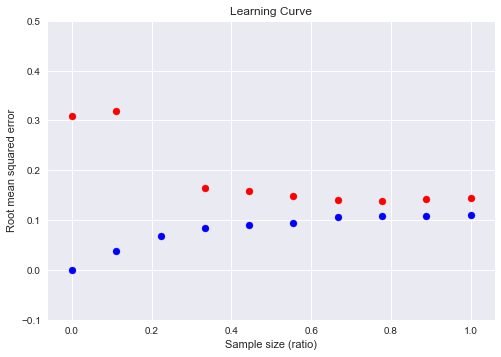

In [226]:
data_points=10
lr = LinearRegression()
train_error,val_error = learning_curve(lr,X_train,y_train,X_val,y_val,data_points=data_points)
plt.scatter(np.linspace(0,1,data_points),train_error,color='b')
plt.scatter(np.linspace(0,1,data_points),val_error,color='r')
plt.title('Learning Curve')
plt.xlabel('Sample size (ratio)')
plt.ylabel('Root mean squared error')
plt.ylim(-0.1,0.5)
plt.show()

Ridge

In [281]:
alpha=np.array([0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60,100])
ridge=RidgeCV(alphas=alpha,cv=10)
ridge.fit(X_train,y_train)
print 'Ridge Score on train set: ', rmse(y_train,ridge.predict(X_train))
print 'Ridge Score on validation set: ', rmse(y_val,ridge.predict(X_val))

Ridge Score on train set:  0.115516092529
Ridge Score on validation set:  0.136493998705


Lasso

In [282]:
lasso=LassoCV(alphas=alpha,cv=10)
lasso.fit(X_train,y_train)
print 'Lasso Score on train set: ', rmse(y_train,lasso.predict(X_train))
print 'Lasso SCore on validation set: ', rmse(y_val,lasso.predict(X_val))

Lasso Score on train set:  0.158083371378
Lasso SCore on validation set:  0.156338386754


In [283]:
en = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
en.fit(X_train,y_train)
print 'ElasticNet Score on train set: ', rmse(y_train,en.predict(X_train))
print 'ElasticNet Score on test set: ',rmse(y_val,en.predict(X_val))

ElasticNet Score on train set:  0.116388398432
ElasticNet Score on test set:  0.133569194236


In [284]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor(n_estimators=5000,max_features='sqrt',max_depth=5, random_state=0)
rfreg.fit(X_train,y_train)
print 'RandomForestRegressor Score on train set: ', rmse(y_train,rfreg.predict(X_train))
print 'RandomForestRegressor Score on validation set: ', rmse(y_val,rfreg.predict(X_val))

RandomForestRegressor Score on train set:  0.153894427288
RandomForestRegressor Score on validation set:  0.175137168585
